# Library install

In [ ]:
# !pip install category_encoders
# !pip install tqdm
# !pip install lightgbm
# !pip install xgboost
# !pip install catboost
# !pip install torch

# 제품 이상여부 판별 프로젝트

## 0. Environment & Data Loading & Shift

### Library

In [1]:
import os
import re
import gc

import numpy as np
import pandas as pd
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score)

import matplotlib as plt
import category_encoders as ce
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import KFold, StratifiedKFold
from tqdm import tqdm

import lightgbm as lgb
import xgboost as xgb
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

import warnings
pd.set_option('mode.chained_assignment', None)
warnings.filterwarnings(action='ignore')

import random
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    
seed_everything(42) # Seed 고정

### Data Loading

In [2]:
ROOT_DIR = "data"
RANDOM_STATE = 42

df_train = pd.read_csv(os.path.join(ROOT_DIR, "train.csv"))
df_test = pd.read_csv(os.path.join(ROOT_DIR, "test.csv"))

df_test_copy = df_test.copy()

In [3]:
df_test_후처리용 = pd.read_csv(os.path.join(ROOT_DIR, "test.csv"))

In [4]:
#Drop columns with percentage of missing value and drop only one unique value
drop_cols = []
for column in df_train.columns:
    if ((df_train[column].isnull().sum() / df_train.shape[0]) > 0.4) or (df_train[column].nunique() <=1):
        drop_cols.append(column)
    
df_train.drop(columns = drop_cols, inplace = True)
df_train.head()

,Equipment_Dam,Model.Suffix_Dam,Workorder_Dam,Collect Date_Dam,CURE END POSITION X Collect Result_Dam,CURE END POSITION Z Collect Result_Dam,CURE END POSITION Θ Collect Result_Dam,CURE SPEED Collect Result_Dam,CURE START POSITION X Collect Result_Dam,CURE START POSITION Θ Collect Result_Dam,...,Head Clean Position Z Collect Result_Fill2,Head Purge Position X Collect Result_Fill2,Head Purge Position Y Collect Result_Fill2,Head Purge Position Z Collect Result_Fill2,Machine Tact time Collect Result_Fill2,PalletID Collect Result_Fill2,Production Qty Collect Result_Fill2,Receip No Collect Result_Fill2,WorkMode Collect Result_Fill2,target
0,Dam dispenser #1,AJX75334505,4F1XA938-1,2024-04-25 11:10:00,240.0,2.5,-90,100,1030,-90,...,50.0,91.8,270,50,114.612,19.9,7,127,1,Normal
1,Dam dispenser #1,AJX75334505,3KPM0016-2,2023-09-19 14:30:00,240.0,2.5,-90,70,1030,-90,...,91.8,270.0,50,85,19.600,7.0,185,1,0,Normal
2,Dam dispenser #2,AJX75334501,4E1X9167-1,2024-03-05 09:30:00,1000.0,12.5,90,85,280,90,...,50.0,91.8,270,50,114.612,19.8,10,73,1,Normal
3,Dam dispenser #2,AJX75334501,3K1X0057-1,2023-09-25 15:40:00,1000.0,12.5,90,70,280,90,...,91.8,270.0,50,85,19.900,12.0,268,1,0,Normal
4,Dam dispenser #1,AJX75334501,3HPM0007-1,2023-06-27 13:20:00,240.0,2.5,-90,70,1030,-90,...,91.8,270.0,50,85,19.700,8.0,121,1,0,Normal


In [5]:
time_features_tr = df_train[['Collect Date_Dam','Collect Date_Fill1','Collect Date_Fill2','Collect Date_AutoClave']]
time_features_te = df_test[['Collect Date_Dam','Collect Date_Fill1','Collect Date_Fill2','Collect Date_AutoClave']]

df_train.drop(columns = ['Collect Date_Dam','Collect Date_Fill1','Collect Date_Fill2','Collect Date_AutoClave'],inplace=True)

### DATA SHIFT

### train

In [6]:
column  = list(df_train.columns)

In [7]:
#WorkMode Collect Result_Fill1 기준(Dam)
df_train_1 = df_train[df_train['WorkMode Collect Result_Fill1']!=7]
df_train_2 = df_train[df_train['WorkMode Collect Result_Fill1']==7]
replace_data  = df_train_1.iloc[:,15:69].shift(-1, axis=1).drop(columns=['Dispense Volume(Stage3) Collect Result_Dam','WorkMode Collect Result_Dam'])
df_train.loc[df_train_1.index,replace_data.columns] = replace_data
df_train = df_train.drop(columns  = ['WorkMode Collect Result_Dam'])

#WorkMode Collect Result_Fill1 기준(Fill1)
df_train_1 = df_train[df_train['WorkMode Collect Result_Fill1']!=7]
df_train_2 = df_train[df_train['WorkMode Collect Result_Fill1']==7]
replace_data  = df_train_1.iloc[:,89:112].shift(-1, axis=1).drop(columns=['WorkMode Collect Result_Fill1'])
df_train.loc[df_train_1.index,replace_data.columns] = replace_data
df_train = df_train.drop(columns  = ['WorkMode Collect Result_Fill1'])

#WorkMode Collect Result_Fill1 기준(Fill2)
idx = replace_data.index
df_train_1 = df_train.loc[idx]
replace_data  = df_train_1.iloc[:,120:143].shift(-1, axis=1).drop(columns=['WorkMode Collect Result_Fill2'])
df_train.loc[df_train_1.index,replace_data.columns] = replace_data
df_train = df_train.drop(columns  = ['WorkMode Collect Result_Fill2'])

df_train.isna().sum().sum()

0

### test

In [8]:
column.remove('target')
df_test = df_test[column]

In [9]:
df_test_1 = df_test[df_test['WorkMode Collect Result_Fill1']!=7]
df_test_2 = df_test[df_test['WorkMode Collect Result_Fill1']==7]
replace_data = df_test_1.iloc[:,15:69].shift(-1, axis=1).drop(columns=['Dispense Volume(Stage3) Collect Result_Dam','WorkMode Collect Result_Dam'])
df_test.loc[df_test_1.index,replace_data.columns] = replace_data
df_test = df_test.drop(columns  = ['WorkMode Collect Result_Dam'])


df_test_1 = df_test[df_test['WorkMode Collect Result_Fill1']!=7]
df_test_2 = df_test[df_test['WorkMode Collect Result_Fill1']==7]
replace_data  = df_test_1.iloc[:,89:112].shift(-1, axis=1).drop(columns=['WorkMode Collect Result_Fill1'])
df_test.loc[df_test_1.index,replace_data.columns] = replace_data
df_test = df_test.drop(columns  = ['WorkMode Collect Result_Fill1'])


idx = replace_data.index
df_test_1 = df_test.loc[idx]
replace_data  = df_test_1.iloc[:,120:143].shift(-1, axis=1).drop(columns=['WorkMode Collect Result_Fill2'])
df_test.loc[df_test_1.index,replace_data.columns] = replace_data
df_test = df_test.drop(columns  = ['WorkMode Collect Result_Fill2'])

df_test.isna().sum().sum()

0

## Float Transfrom

In [10]:
df_train['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam'] = df_train['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam'].astype(float)
df_train['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1'] = df_train['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1'].astype(float)
df_train['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2'] = df_train['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2'].astype(float)

In [11]:
df_test['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam'] = df_test['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam'].astype(float)
df_test['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1'] = df_test['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1'].astype(float)
df_test['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2'] = df_test['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2'].astype(float)

## 1. Data Preprocessing

In [12]:
#Drop columns only one unique value
drop_cols = []
for column in df_train.columns:
    if df_train[column].nunique() == 1:
        drop_cols.append(column)
        
df_train.drop(columns = drop_cols, inplace = True)
df_test.drop(columns = drop_cols, inplace = True)
display(df_train.head())
display(df_test.head())

,Equipment_Dam,Model.Suffix_Dam,Workorder_Dam,CURE END POSITION X Collect Result_Dam,CURE END POSITION Z Collect Result_Dam,CURE END POSITION Θ Collect Result_Dam,CURE SPEED Collect Result_Dam,CURE START POSITION X Collect Result_Dam,CURE START POSITION Θ Collect Result_Dam,DISCHARGED SPEED OF RESIN Collect Result_Dam,...,HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill2,HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Fill2,HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Fill2,HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Fill2,Head Purge Position Z Collect Result_Fill2,Machine Tact time Collect Result_Fill2,PalletID Collect Result_Fill2,Production Qty Collect Result_Fill2,Receip No Collect Result_Fill2,target
0,Dam dispenser #1,AJX75334505,4F1XA938-1,240.0,2.5,-90,100,1030,-90,16,...,428.0,243.7,243.7,243.7,114.612,19.9,7.0,127,1,Normal
1,Dam dispenser #1,AJX75334505,3KPM0016-2,240.0,2.5,-90,70,1030,-90,10,...,428.0,243.7,243.7,243.7,85.000,19.6,7.0,185,1,Normal
2,Dam dispenser #2,AJX75334501,4E1X9167-1,1000.0,12.5,90,85,280,90,16,...,1324.2,243.5,243.5,243.5,114.612,19.8,10.0,73,1,Normal
3,Dam dispenser #2,AJX75334501,3K1X0057-1,1000.0,12.5,90,70,280,90,10,...,1324.2,243.5,243.5,243.5,85.000,19.9,12.0,268,1,Normal
4,Dam dispenser #1,AJX75334501,3HPM0007-1,240.0,2.5,-90,70,1030,-90,10,...,428.0,243.7,243.7,243.7,85.000,19.7,8.0,121,1,Normal


,Equipment_Dam,Model.Suffix_Dam,Workorder_Dam,CURE END POSITION X Collect Result_Dam,CURE END POSITION Z Collect Result_Dam,CURE END POSITION Θ Collect Result_Dam,CURE SPEED Collect Result_Dam,CURE START POSITION X Collect Result_Dam,CURE START POSITION Θ Collect Result_Dam,DISCHARGED SPEED OF RESIN Collect Result_Dam,...,HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill2,HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill2,HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Fill2,HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Fill2,HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Fill2,Head Purge Position Z Collect Result_Fill2,Machine Tact time Collect Result_Fill2,PalletID Collect Result_Fill2,Production Qty Collect Result_Fill2,Receip No Collect Result_Fill2
0,Dam dispenser #2,AJX75334501,3J1XF767-1,1000.0,12.5,90,70,280,90,10,...,1324.2,1324.2,243.5,243.5,243.5,85.0,19.8,13.0,195,1
1,Dam dispenser #2,AJX75334501,4B1XD472-2,1000.0,12.5,90,70,280,90,16,...,1324.2,1324.2,243.5,243.5,243.5,85.0,19.8,14.0,256,1
2,Dam dispenser #1,AJX75334501,3H1XE355-1,240.0,2.5,-90,70,1030,-90,10,...,427.9,428.0,243.7,243.7,243.7,85.0,19.7,1.0,98,1
3,Dam dispenser #2,AJX75334501,3L1XA128-1,1000.0,12.5,90,70,280,90,10,...,1324.2,1324.2,243.5,243.5,243.5,85.0,20.0,14.0,0,1
4,Dam dispenser #1,AJX75334501,4A1XA639-1,240.0,2.5,-90,70,1030,-90,16,...,427.9,428.0,243.7,243.7,243.7,85.0,19.8,1.0,215,1


In [13]:
#Time rematching
df_train = pd.concat([df_train, time_features_tr], axis = 1)
df_test = pd.concat([df_test, time_features_te], axis = 1)

display(df_train.head())
display(df_test.head())

,Equipment_Dam,Model.Suffix_Dam,Workorder_Dam,CURE END POSITION X Collect Result_Dam,CURE END POSITION Z Collect Result_Dam,CURE END POSITION Θ Collect Result_Dam,CURE SPEED Collect Result_Dam,CURE START POSITION X Collect Result_Dam,CURE START POSITION Θ Collect Result_Dam,DISCHARGED SPEED OF RESIN Collect Result_Dam,...,Head Purge Position Z Collect Result_Fill2,Machine Tact time Collect Result_Fill2,PalletID Collect Result_Fill2,Production Qty Collect Result_Fill2,Receip No Collect Result_Fill2,target,Collect Date_Dam,Collect Date_Fill1,Collect Date_Fill2,Collect Date_AutoClave
0,Dam dispenser #1,AJX75334505,4F1XA938-1,240.0,2.5,-90,100,1030,-90,16,...,114.612,19.9,7.0,127,1,Normal,2024-04-25 11:10:00,2024-04-25 11:20:00,2024-04-25 11:20:00,2024-04-25 11:50:00
1,Dam dispenser #1,AJX75334505,3KPM0016-2,240.0,2.5,-90,70,1030,-90,10,...,85.000,19.6,7.0,185,1,Normal,2023-09-19 14:30:00,2023-09-19 14:30:00,2023-09-19 14:30:00,2023-09-19 15:00:00
2,Dam dispenser #2,AJX75334501,4E1X9167-1,1000.0,12.5,90,85,280,90,16,...,114.612,19.8,10.0,73,1,Normal,2024-03-05 09:30:00,2024-03-05 09:30:00,2024-03-05 09:30:00,2024-03-05 10:10:00
3,Dam dispenser #2,AJX75334501,3K1X0057-1,1000.0,12.5,90,70,280,90,10,...,85.000,19.9,12.0,268,1,Normal,2023-09-25 15:40:00,2023-09-25 15:40:00,2023-09-25 15:40:00,2023-09-25 16:20:00
4,Dam dispenser #1,AJX75334501,3HPM0007-1,240.0,2.5,-90,70,1030,-90,10,...,85.000,19.7,8.0,121,1,Normal,2023-06-27 13:20:00,2023-06-27 13:20:00,2023-06-27 13:20:00,2023-06-27 14:00:00


,Equipment_Dam,Model.Suffix_Dam,Workorder_Dam,CURE END POSITION X Collect Result_Dam,CURE END POSITION Z Collect Result_Dam,CURE END POSITION Θ Collect Result_Dam,CURE SPEED Collect Result_Dam,CURE START POSITION X Collect Result_Dam,CURE START POSITION Θ Collect Result_Dam,DISCHARGED SPEED OF RESIN Collect Result_Dam,...,HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Fill2,Head Purge Position Z Collect Result_Fill2,Machine Tact time Collect Result_Fill2,PalletID Collect Result_Fill2,Production Qty Collect Result_Fill2,Receip No Collect Result_Fill2,Collect Date_Dam,Collect Date_Fill1,Collect Date_Fill2,Collect Date_AutoClave
0,Dam dispenser #2,AJX75334501,3J1XF767-1,1000.0,12.5,90,70,280,90,10,...,243.5,85.0,19.8,13.0,195,1,2023-09-15 13:20:00,2023-09-15 13:30:00,2023-09-15 13:30:00,2023-09-15 14:00:00
1,Dam dispenser #2,AJX75334501,4B1XD472-2,1000.0,12.5,90,70,280,90,16,...,243.5,85.0,19.8,14.0,256,1,2024-02-06 16:50:00,2024-02-06 16:50:00,2024-02-06 16:50:00,2024-02-06 17:30:00
2,Dam dispenser #1,AJX75334501,3H1XE355-1,240.0,2.5,-90,70,1030,-90,10,...,243.7,85.0,19.7,1.0,98,1,2023-07-14 11:30:00,2023-07-14 11:40:00,2023-07-14 11:40:00,2023-07-14 12:10:00
3,Dam dispenser #2,AJX75334501,3L1XA128-1,1000.0,12.5,90,70,280,90,10,...,243.5,85.0,20.0,14.0,0,1,2023-11-03 08:00:00,2023-11-03 08:00:00,2023-11-03 08:00:00,2023-11-03 08:30:00
4,Dam dispenser #1,AJX75334501,4A1XA639-1,240.0,2.5,-90,70,1030,-90,16,...,243.7,85.0,19.8,1.0,215,1,2023-12-23 14:00:00,2023-12-23 14:00:00,2023-12-23 14:10:00,2023-12-23 14:40:00


In [14]:
#Int to Object Transformation
transform_col = [
                'Production Qty Collect Result_Dam','Production Qty Collect Result_Fill1','Production Qty Collect Result_Fill2',
                'PalletID Collect Result_Dam','PalletID Collect Result_Fill1','PalletID Collect Result_Fill2',
                'Receip No Collect Result_Dam','Receip No Collect Result_Fill1','Receip No Collect Result_Fill2']

df_train[transform_col] = df_train[transform_col].astype(int).astype(object)
df_test[transform_col] = df_test[transform_col].astype(int).astype(object)

In [15]:
#중복 columns 처리
##Equipment, Model.Suffix, Workorder 통일화
df_train.rename(columns = {'Equipment_Dam':'Equipment', 'Model.Suffix_Dam':'Model.Suffix', 'Workorder_Dam':'Workorder'}, inplace = True)
df_train.drop(columns = ['Equipment_Fill1', 'Equipment_Fill2',
                        'Model.Suffix_AutoClave', 'Model.Suffix_Fill1', 'Model.Suffix_Fill2',
                        'Workorder_AutoClave', 'Workorder_Fill1', 'Workorder_Fill2'], inplace = True)
df_test.rename(columns = {'Equipment_Dam':'Equipment', 'Model.Suffix_Dam':'Model.Suffix', 'Workorder_Dam':'Workorder'}, inplace = True)
df_test.drop(columns = ['Equipment_Fill1', 'Equipment_Fill2',
                        'Model.Suffix_AutoClave', 'Model.Suffix_Fill1', 'Model.Suffix_Fill2',
                        'Workorder_AutoClave', 'Workorder_Fill1', 'Workorder_Fill2'], inplace = True)

df_train['Equipment'] = df_train['Equipment'].map({'Dam dispenser #1':'Dispenser_1', 'Dam dispenser #2':'Dispneser_2'})
df_test['Equipment'] = df_test['Equipment'].map({'Dam dispenser #1':'Dispenser_1', 'Dam dispenser #2':'Dispneser_2'})

##Production Qty, PalletID, Receip No 통일화
df_train.rename(columns = {'Production Qty Collect Result_Dam':'Production Qty Collect Result', 
                           'PalletID Collect Result_Dam':'PalletID Collect Result',
                          'Receip No Collect Result_Dam':'Receip No Collect Result'}, inplace = True)
df_train.drop(columns = ['Production Qty Collect Result_Fill1', 'Production Qty Collect Result_Fill2',
                        'PalletID Collect Result_Fill1', 'PalletID Collect Result_Fill2',
                        'Receip No Collect Result_Fill1', 'Receip No Collect Result_Fill2'], inplace = True)
df_test.rename(columns = {'Production Qty Collect Result_Dam':'Production Qty Collect Result', 
                           'PalletID Collect Result_Dam':'PalletID Collect Result',
                          'Receip No Collect Result_Dam':'Receip No Collect Result'}, inplace = True)
df_test.drop(columns = ['Production Qty Collect Result_Fill1', 'Production Qty Collect Result_Fill2',
                        'PalletID Collect Result_Fill1', 'PalletID Collect Result_Fill2',
                        'Receip No Collect Result_Fill1', 'Receip No Collect Result_Fill2'], inplace = True)

In [16]:
df_train['Work_Equip'] = df_train['Equipment'] + df_train['Workorder']
df_test['Work_Equip'] = df_test['Equipment'] + df_test['Workorder']

In [17]:
#Equipment/PalletID, Model.Suffix/Receip No 통일화
df_train.rename(columns = {'Equipment':'Equipment_PalletID', 
                           'Model.Suffix':'Model_Receip'}, inplace = True)
df_train['Equipment_PalletID'] = df_train['Equipment_PalletID'] + '_' + df_train['PalletID Collect Result'].astype(str)
df_train['Model_Receip'] = df_train['Model_Receip'] + '_' + df_train['Receip No Collect Result'].astype(str)
df_test.rename(columns = {'Equipment':'Equipment_PalletID', 
                           'Model.Suffix':'Model_Receip'}, inplace = True)
df_test['Equipment_PalletID'] = df_test['Equipment_PalletID'] + '_' + df_test['PalletID Collect Result'].astype(str)
df_test['Model_Receip'] = df_test['Model_Receip'] + '_' + df_test['Receip No Collect Result'].astype(str)

df_train.drop(columns = ['PalletID Collect Result', 'Receip No Collect Result'], inplace = True)
df_test.drop(columns = ['PalletID Collect Result', 'Receip No Collect Result'], inplace = True)

In [18]:
#Production Qty Transformation
for lst in tqdm(df_train['Workorder'].unique()):
    
    tr = df_train[df_train['Workorder'] == lst]
    te = df_test[df_test['Workorder'] == lst]

    tr['Production_Sequence_Ratio'] = tr['Production Qty Collect Result'] / tr['Production Qty Collect Result'].max()
    te['Production_Sequence_Ratio'] = te['Production Qty Collect Result'] / tr['Production Qty Collect Result'].max()
    
    tr['sin_sequence'] = np.sin(2 * np.pi * tr['Production Qty Collect Result'].astype(float) / 59.0)
    te['sin_sequence'] = np.sin(2 * np.pi * te['Production Qty Collect Result'].astype(float) / 59.0)
    
    tr['cos_sequence'] = np.cos(2 * np.pi * tr['Production Qty Collect Result'].astype(float) / 59.0)
    te['cos_sequence'] = np.cos(2 * np.pi * te['Production Qty Collect Result'].astype(float) / 59.0)
    
    df_train.loc[tr.index,'Production_Sequence_ratio'] = tr['Production_Sequence_Ratio']
    df_test.loc[te.index,'Production_Sequence_ratio'] = te['Production_Sequence_Ratio']

    df_train.loc[tr.index,'sin_sequence'] = tr['sin_sequence']
    df_test.loc[te.index,'sin_sequence'] = te['sin_sequence']
    
    df_train.loc[tr.index,'cos_sequence'] = tr['cos_sequence']
    df_test.loc[te.index,'cos_sequence'] = te['cos_sequence'] 

100%|████████████████████████████████████████████████████████████████████████████████| 663/663 [00:07<00:00, 90.86it/s]


## 2. Feature Engineering

### Model detail

In [19]:
#패턴 통일
def remove_zeros(input_string):
    # 패턴 정의: - 문자 뒤에 000이 있는 경우
    pattern = r'-(000)'

    # re.sub를 사용하여 패턴을 대체
    modified_string = re.sub(pattern, '-', input_string)
    return modified_string

df_train['Workorder'] = df_train['Workorder'].apply(lambda x : remove_zeros(x))
df_test['Workorder'] = df_test['Workorder'].apply(lambda x : remove_zeros(x))

### Dam Features

#### Workorder & Production Qty

In [20]:
#문자열 정보 추출
df_train['Wo_Number'] = df_train['Workorder'].apply(lambda x : x[:1]).astype(str)
df_train['number_alpha'] = df_train['Workorder'].apply(lambda x : x[:2]).astype(str)
df_train['alpha'] = df_train['Workorder'].apply(lambda x : x[1]).astype(str)
df_train['Wo_Main'] = df_train['Workorder'].apply(lambda x : x[:3]).astype(str)
df_train['Wo_Sub'] = df_train['Workorder'].apply(lambda x : x[3]).astype(str)
df_train['Wo_Detail_1'] = df_train['Workorder'].apply(lambda x : x[4]).astype(str)
df_train['Wo_Detail_2'] = df_train['Workorder'].apply(lambda x : x[5:]).astype(str)
df_train['last'] = df_train['Workorder'].apply(lambda x : x[-1]).astype(str)

df_train['sj_1'] = df_train['Workorder'].apply(lambda x : x[:4]).astype(str)
df_train['sj_5'] = df_train['Workorder'].apply(lambda x : x[:8]).astype(str)
df_train['sj_6'] = df_train['Workorder'].apply(lambda x : x[2]).astype(str)
df_train['sj_7'] = df_train['Workorder'].apply(lambda x : x[5]).astype(str)
df_train['sj_8'] = df_train['Workorder'].apply(lambda x : x[4:8]).astype(str)
df_train['sj_9'] = df_train['Workorder'].apply(lambda x : x[-5:-2]).astype(str)

df_test['Wo_Number'] = df_test['Workorder'].apply(lambda x : x[:1]).astype(str)
df_test['number_alpha'] = df_test['Workorder'].apply(lambda x : x[:2]).astype(str)
df_test['alpha'] = df_test['Workorder'].apply(lambda x : x[1]).astype(str)
df_test['Wo_Main'] = df_test['Workorder'].apply(lambda x : x[:3]).astype(str)
df_test['Wo_Sub'] = df_test['Workorder'].apply(lambda x : x[3]).astype(str)
df_test['Wo_Detail_1'] = df_test['Workorder'].apply(lambda x : x[4]).astype(str)
df_test['Wo_Detail_2'] = df_test['Workorder'].apply(lambda x : x[5:]).astype(str)
df_test['last'] = df_test['Workorder'].apply(lambda x : x[-1]).astype(str)

df_test['sj_1'] = df_test['Workorder'].apply(lambda x : x[:4]).astype(str)
df_test['sj_5'] = df_test['Workorder'].apply(lambda x : x[:8]).astype(str)
df_test['sj_6'] = df_test['Workorder'].apply(lambda x : x[2]).astype(str)
df_test['sj_7'] = df_test['Workorder'].apply(lambda x : x[5]).astype(str)
df_test['sj_8'] = df_test['Workorder'].apply(lambda x : x[4:8]).astype(str)
df_test['sj_9'] = df_test['Workorder'].apply(lambda x : x[-5:-2]).astype(str)

#### Signal combination

In [21]:
#CURE(Dam)
##CURE 가동 방향 및 가동높이
df_train['Cure_HD_Dam'] = df_train['CURE END POSITION X Collect Result_Dam'] - df_train['CURE START POSITION X Collect Result_Dam']
df_test['Cure_HD_Dam'] = df_test['CURE END POSITION X Collect Result_Dam'] - df_test['CURE START POSITION X Collect Result_Dam']

##CURE 가동 시간
df_train['Cure_time_Dam'] = df_train['Cure_HD_Dam'] / df_train['CURE SPEED Collect Result_Dam']
df_test['Cure_time_Dam'] = df_test['Cure_HD_Dam'] / df_test['CURE SPEED Collect Result_Dam']

##CURE position category
df_train['Cure_position_category_Dam'] = df_train['CURE END POSITION X Collect Result_Dam'].map({240.0:'Down',1000.0:'Up'}).astype(str)
df_test['Cure_position_category_Dam'] = df_test['CURE END POSITION X Collect Result_Dam'].map({240.0:'Down',1000.0:'Up'}).astype(str)

##CURE Hysteresis
def f_H(x):
    return np.arccos(1 - 2 * np.tanh(5.16 * (x / (1 + 1.31 * x**0.99))**0.706))

u_c = df_train['CURE SPEED Collect Result_Dam']
theta_e_1 = df_train['CURE START POSITION Θ Collect Result_Dam']

mu = 1
gamma = 1
df_train['Theta_d_1_Dam'] = f_H((mu * u_c / gamma) + f_H(theta_e_1))

u_c = df_test['CURE SPEED Collect Result_Dam']
theta_e_1 = df_test['CURE START POSITION Θ Collect Result_Dam']  # equilibrium contact angle 데이터 배열

df_test['Theta_d_1_Dam'] = f_H((mu * u_c / gamma) + f_H(theta_e_1))

In [22]:
#DISCHARGED RESIN(Dam)
##Resin 토출기 이동거리
df_train['Discharged_Resin_distance_1_Dam'] = df_train['DISCHARGED SPEED OF RESIN Collect Result_Dam'] * df_train['DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam']
df_train['Discharged_Resin_distance_2_Dam'] = df_train['DISCHARGED SPEED OF RESIN Collect Result_Dam'] * df_train['DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam']
df_train['Discharged_Resin_distance_3_Dam'] = df_train['DISCHARGED SPEED OF RESIN Collect Result_Dam'] * df_train['DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam']
df_test['Discharged_Resin_distance_1_Dam'] = df_test['DISCHARGED SPEED OF RESIN Collect Result_Dam'] * df_test['DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam']
df_test['Discharged_Resin_distance_2_Dam'] = df_test['DISCHARGED SPEED OF RESIN Collect Result_Dam'] * df_test['DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam']
df_test['Discharged_Resin_distance_3_Dam'] = df_test['DISCHARGED SPEED OF RESIN Collect Result_Dam'] * df_test['DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam']

##Resin 토출 총 소요 시간
df_train['TotalTime_Discharged_Resin_Dam'] = df_train['DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam'] + df_train['DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam'] + df_train['DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam']
df_test['TotalTime_Discharged_Resin_Dam'] = df_test['DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam'] + df_test['DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam'] + df_test['DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam']

In [23]:
#DISPENSE(Dam)
##Dispensor 크기 변화
df_train['Dispense_volume_change1_Dam'] = df_train['Dispense Volume(Stage2) Collect Result_Dam'] - df_train['Dispense Volume(Stage1) Collect Result_Dam']
df_train['Dispense_volume_change2_Dam'] = df_train['Dispense Volume(Stage3) Collect Result_Dam'] - df_train['Dispense Volume(Stage2) Collect Result_Dam']
df_test['Dispense_volume_change1_Dam'] = df_test['Dispense Volume(Stage2) Collect Result_Dam'] - df_test['Dispense Volume(Stage1) Collect Result_Dam']
df_test['Dispense_volume_change2_Dam'] = df_test['Dispense Volume(Stage3) Collect Result_Dam'] - df_test['Dispense Volume(Stage2) Collect Result_Dam']

##Dispensor 크기 변화량
df_train['Dispense_volume_change1_abs_Dam'] = df_train['Dispense_volume_change1_Dam'].abs()
df_train['Dispense_volume_change2_abs_Dam'] = df_train['Dispense_volume_change2_Dam'].abs()
df_test['Dispense_volume_change1_abs_Dam'] = df_test['Dispense_volume_change1_Dam'].abs()
df_test['Dispense_volume_change2_abs_Dam'] = df_test['Dispense_volume_change2_Dam'].abs()

In [24]:
#DISCHARGED RESIN & DISPENSE (Dam)
##도포된 Resin 양
df_train['Total_Resin_volume1_Dam'] = df_train['Discharged_Resin_distance_1_Dam'] * df_train['Dispense Volume(Stage1) Collect Result_Dam']
df_train['Total_Resin_volume2_Dam'] = df_train['Discharged_Resin_distance_2_Dam'] * df_train['Dispense Volume(Stage2) Collect Result_Dam']
df_train['Total_Resin_volume3_Dam'] = df_train['Discharged_Resin_distance_3_Dam'] * df_train['Dispense Volume(Stage3) Collect Result_Dam']
df_test['Total_Resin_volume1_Dam'] = df_test['Discharged_Resin_distance_1_Dam'] * df_test['Dispense Volume(Stage1) Collect Result_Dam']
df_test['Total_Resin_volume2_Dam'] = df_test['Discharged_Resin_distance_2_Dam'] * df_test['Dispense Volume(Stage2) Collect Result_Dam']
df_test['Total_Resin_volume3_Dam'] = df_test['Discharged_Resin_distance_3_Dam'] * df_test['Dispense Volume(Stage3) Collect Result_Dam']

##시간당 토출량
df_train['Stage1_Dam_Volume_Speed'] = df_train['Dispense Volume(Stage1) Collect Result_Dam'] / df_train['DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam']
df_train['Stage2_Dam_Volume_Speed'] = df_train['Dispense Volume(Stage2) Collect Result_Dam'] / df_train['DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam']
df_train['Stage3_Dam_Volume_Speed'] = df_train['Dispense Volume(Stage3) Collect Result_Dam'] / df_train['DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam']
df_test['Stage1_Dam_Volume_Speed'] = df_test['Dispense Volume(Stage1) Collect Result_Dam'] / df_test['DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam']
df_test['Stage2_Dam_Volume_Speed'] = df_test['Dispense Volume(Stage2) Collect Result_Dam'] / df_test['DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam']
df_test['Stage3_Dam_Volume_Speed'] = df_test['Dispense Volume(Stage3) Collect Result_Dam'] / df_test['DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam']

In [25]:
#HEAD(Dam)
##Dam X,Y,Z
df_train['Dam_X_1'] = df_train['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam'] - df_train['HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Dam']
df_train['Dam_X_2'] = df_train['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam'] - df_train['HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam']
df_train['Dam_X_3'] = df_train['HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Dam'] - df_train['HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam']
df_test['Dam_X_1'] = df_test['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam'] - df_test['HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Dam']
df_test['Dam_X_2'] = df_test['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam'] - df_test['HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam']
df_test['Dam_X_3'] = df_test['HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Dam'] - df_test['HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam']

df_train['Dam_Y_1'] = df_train['HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam'] - df_train['HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Dam']
df_train['Dam_Y_2'] = df_train['HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam'] - df_train['HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Dam']
df_train['Dam_Y_3'] = df_train['HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Dam'] - df_train['HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Dam']
df_test['Dam_Y_1'] = df_test['HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam'] - df_test['HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Dam']
df_test['Dam_Y_2'] = df_test['HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam'] - df_test['HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Dam']
df_test['Dam_Y_3'] = df_test['HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Dam'] - df_test['HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Dam']

df_train['Dam_dist_1'] = np.sqrt(df_train['Dam_X_1']**2 +df_train['Dam_Y_1']**2)
df_train['Dam_dist_2'] = np.sqrt(df_train['Dam_X_2']**2 +df_train['Dam_Y_2']**2)
df_train['Dam_dist_3'] = np.sqrt(df_train['Dam_X_3']**2 +df_train['Dam_Y_3']**2)
df_test['Dam_dist_1'] = np.sqrt(df_test['Dam_X_1']**2 +df_test['Dam_Y_1']**2)
df_test['Dam_dist_2'] = np.sqrt(df_test['Dam_X_2']**2 +df_test['Dam_Y_2']**2)
df_test['Dam_dist_3'] = np.sqrt(df_test['Dam_X_3']**2 +df_test['Dam_Y_3']**2)

##노즐 분사 벡터 크기 & 각도
def calculate_magnitude(a,b,c):
    # 벡터 크기 계산
    return np.sqrt(a**2 + b**2 +c**2)

def calculate_angles(a,b,c):
    # 벡터 크기
    magnitude = calculate_magnitude(a,b,c)
    
    # 각 좌표축과의 각도 (cosine)
    angle_x = a / magnitude
    angle_y = b / magnitude
    angle_z = c / magnitude
    
    return angle_x, angle_y, angle_z

df_train['Vector_Dam_Stage1']= calculate_magnitude(df_train['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam'],
                                                   df_train['HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam'],
                                                    df_train['HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Dam'])
df_train['Vector_Dam_Stage2']= calculate_magnitude(df_train['HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Dam'],
                                                   df_train['HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Dam'],
                                                    df_train['HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Dam'])
df_train['Vector_Dam_Stage3']= calculate_magnitude(df_train['HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam'],
                                                   df_train['HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Dam'],
                                                    df_train['HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Dam'])
df_test['Vector_Dam_Stage1']= calculate_magnitude(df_test['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam'],
                                                   df_test['HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam'],
                                                    df_test['HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Dam'])
df_test['Vector_Dam_Stage2']= calculate_magnitude(df_test['HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Dam'],
                                                   df_test['HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Dam'],
                                                    df_test['HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Dam'])
df_test['Vector_Dam_Stage3']= calculate_magnitude(df_test['HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam'],
                                                   df_test['HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Dam'],
                                                    df_test['HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Dam'])

df_train['Angle_x_Dam_Stage1'],df_train['Angle_y_Dam_Stage1'],df_train['Angle_z_Dam_Stage1'] = calculate_angles(df_train['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam'],
                                                   df_train['HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam'],
                                                    df_train['HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Dam'])
df_train['Angle_x_Dam_Stage2'] ,df_train['Angle_y_Dam_Stage2'],df_train['Angle_z_Dam_Stage2'] = calculate_angles(df_train['HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Dam'],
                                                   df_train['HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Dam'],
                                                    df_train['HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Dam'])
df_train['Angle_x_Dam_Stage3'] ,df_train['Angle_y_Dam_Stage3'],df_train['Angle_z_Dam_Stage3'] = calculate_angles(df_train['HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam'],
                                                   df_train['HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Dam'],
                                                    df_train['HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Dam'])
df_test['Angle_x_Dam_Stage1'],df_test['Angle_y_Dam_Stage1'],df_test['Angle_z_Dam_Stage1'] = calculate_angles(df_test['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam'],
                                                   df_test['HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam'],
                                                    df_test['HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Dam'])
df_test['Angle_x_Dam_Stage2'] ,df_test['Angle_y_Dam_Stage2'],df_test['Angle_z_Dam_Stage2'] = calculate_angles(df_test['HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Dam'],
                                                   df_test['HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Dam'],
                                                    df_test['HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Dam'])
df_test['Angle_x_Dam_Stage3'] ,df_test['Angle_y_Dam_Stage3'],df_test['Angle_z_Dam_Stage3'] = calculate_angles(df_test['HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam'],
                                                   df_test['HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Dam'],
                                                    df_test['HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Dam'])

In [26]:
#Circle & Line Distance Speed(Dam)
##Circle speed sum
df_train['Stage1_Circle_sum_Speed_Dam'] = df_train['Stage1 Circle1 Distance Speed Collect Result_Dam'] + df_train['Stage1 Circle2 Distance Speed Collect Result_Dam'] + df_train['Stage1 Circle3 Distance Speed Collect Result_Dam'] + df_train['Stage1 Circle4 Distance Speed Collect Result_Dam']
df_train['Stage2_Circle_sum_Speed_Dam'] = df_train['Stage2 Circle1 Distance Speed Collect Result_Dam'] + df_train['Stage2 Circle2 Distance Speed Collect Result_Dam'] + df_train['Stage2 Circle3 Distance Speed Collect Result_Dam'] + df_train['Stage2 Circle4 Distance Speed Collect Result_Dam']
df_train['Stage3_Circle_sum_Speed_Dam'] = df_train['Stage3 Circle1 Distance Speed Collect Result_Dam'] + df_train['Stage3 Circle2 Distance Speed Collect Result_Dam'] + df_train['Stage3 Circle3 Distance Speed Collect Result_Dam'] + df_train['Stage3 Circle4 Distance Speed Collect Result_Dam']
df_test['Stage1_Circle_sum_Speed_Dam'] = df_test['Stage1 Circle1 Distance Speed Collect Result_Dam'] + df_test['Stage1 Circle2 Distance Speed Collect Result_Dam'] + df_test['Stage1 Circle3 Distance Speed Collect Result_Dam'] + df_test['Stage1 Circle4 Distance Speed Collect Result_Dam']
df_test['Stage2_Circle_sum_Speed_Dam'] = df_test['Stage2 Circle1 Distance Speed Collect Result_Dam'] + df_test['Stage2 Circle2 Distance Speed Collect Result_Dam'] + df_test['Stage2 Circle3 Distance Speed Collect Result_Dam'] + df_test['Stage2 Circle4 Distance Speed Collect Result_Dam']
df_test['Stage3_Circle_sum_Speed_Dam'] = df_test['Stage3 Circle1 Distance Speed Collect Result_Dam'] + df_test['Stage3 Circle2 Distance Speed Collect Result_Dam'] + df_test['Stage3 Circle3 Distance Speed Collect Result_Dam'] + df_test['Stage3 Circle4 Distance Speed Collect Result_Dam']

##Line speed sum
df_train['Stage1_Line_sum_Speed_Dam'] = df_train['Stage1 Line1 Distance Speed Collect Result_Dam'] + df_train['Stage1 Line2 Distance Speed Collect Result_Dam'] + df_train['Stage1 Line3 Distance Speed Collect Result_Dam'] + df_train['Stage1 Line4 Distance Speed Collect Result_Dam']
df_train['Stage2_Line_sum_Speed_Dam'] = df_train['Stage2 Line1 Distance Speed Collect Result_Dam'] + df_train['Stage2 Line2 Distance Speed Collect Result_Dam'] + df_train['Stage2 Line3 Distance Speed Collect Result_Dam'] + df_train['Stage2 Line4 Distance Speed Collect Result_Dam']
df_train['Stage3_Line_sum_Speed_Dam'] = df_train['Stage3 Line1 Distance Speed Collect Result_Dam'] + df_train['Stage3 Line2 Distance Speed Collect Result_Dam'] + df_train['Stage3 Line3 Distance Speed Collect Result_Dam'] + df_train['Stage3 Line4 Distance Speed Collect Result_Dam']
df_test['Stage1_Line_sum_Speed_Dam'] = df_test['Stage1 Line1 Distance Speed Collect Result_Dam'] + df_test['Stage1 Line2 Distance Speed Collect Result_Dam'] + df_test['Stage1 Line3 Distance Speed Collect Result_Dam'] + df_test['Stage1 Line4 Distance Speed Collect Result_Dam']
df_test['Stage2_Line_sum_Speed_Dam'] = df_test['Stage2 Line1 Distance Speed Collect Result_Dam'] + df_test['Stage2 Line2 Distance Speed Collect Result_Dam'] + df_test['Stage2 Line3 Distance Speed Collect Result_Dam'] + df_test['Stage2 Line4 Distance Speed Collect Result_Dam']
df_test['Stage3_Line_sum_Speed_Dam'] = df_test['Stage3 Line1 Distance Speed Collect Result_Dam'] + df_test['Stage3 Line2 Distance Speed Collect Result_Dam'] + df_test['Stage3 Line3 Distance Speed Collect Result_Dam'] + df_test['Stage3 Line4 Distance Speed Collect Result_Dam']

##Diff from Circle to Line
df_train['Abs_speed_Stage1_Dam'] = df_train['Stage1_Circle_sum_Speed_Dam'] - df_train['Stage1_Line_sum_Speed_Dam']
df_train['Abs_speed_Stage2_Dam'] = df_train['Stage2_Circle_sum_Speed_Dam'] - df_train['Stage2_Line_sum_Speed_Dam']
df_train['Abs_speed_Stage3_Dam'] = df_train['Stage3_Circle_sum_Speed_Dam'] - df_train['Stage3_Line_sum_Speed_Dam']
df_test['Abs_speed_Stage1_Dam'] = df_test['Stage1_Circle_sum_Speed_Dam'] - df_test['Stage1_Line_sum_Speed_Dam']
df_test['Abs_speed_Stage2_Dam'] = df_test['Stage2_Circle_sum_Speed_Dam'] - df_test['Stage2_Line_sum_Speed_Dam']
df_test['Abs_speed_Stage3_Dam'] = df_test['Stage3_Circle_sum_Speed_Dam'] - df_test['Stage3_Line_sum_Speed_Dam']

In [27]:
#Tact Time & Discharged Resin
##Diff from Tact Time to Discharged Time
df_train['Abs_Tact_discharged_time_Dam'] = df_train['Machine Tact time Collect Result_Dam'] - df_train['TotalTime_Discharged_Resin_Dam']
df_test['Abs_Tact_discharged_time_Dam'] = df_test['Machine Tact time Collect Result_Dam'] - df_test['TotalTime_Discharged_Resin_Dam']

In [28]:
#Thickness(Dam)
##Diff Thickness
df_train['THICKNESS_abs_Dam_1'] = df_train['THICKNESS 1 Collect Result_Dam'] - df_train['THICKNESS 2 Collect Result_Dam']
df_train['THICKNESS_abs_Dam_2'] = df_train['THICKNESS 1 Collect Result_Dam'] - df_train['THICKNESS 3 Collect Result_Dam']
df_train['THICKNESS_abs_Dam_3'] = df_train['THICKNESS 2 Collect Result_Dam'] - df_train['THICKNESS 3 Collect Result_Dam']
df_test['THICKNESS_abs_Dam_1'] = df_test['THICKNESS 1 Collect Result_Dam'] - df_test['THICKNESS 2 Collect Result_Dam']
df_test['THICKNESS_abs_Dam_2'] = df_test['THICKNESS 1 Collect Result_Dam'] - df_test['THICKNESS 3 Collect Result_Dam']
df_test['THICKNESS_abs_Dam_3'] = df_test['THICKNESS 2 Collect Result_Dam'] - df_test['THICKNESS 3 Collect Result_Dam']

### AutoClave Features

In [29]:
#탈포 압력 값 정제
df_train['AutoClave_1st_Pressure_str'] = df_train['1st Pressure 1st Pressure Unit Time_AutoClave'].astype(str).str[-1].astype('float')
df_train['1st Pressure Unit Time_AutoClave_new'] = df_train['1st Pressure 1st Pressure Unit Time_AutoClave'].round(-1)
df_train['AutoClave_2nd_Pressure_str'] = df_train['2nd Pressure Unit Time_AutoClave'].astype(str).str[-1].astype('float')
df_train['2nd Pressure Unit Time_AutoClave_new'] = df_train['2nd Pressure Unit Time_AutoClave'].round(-1)
df_train['AutoClave_3rd_Pressure_str'] = df_train['3rd Pressure Unit Time_AutoClave'].astype(str).str[-1].astype('float')
df_train['3rd Pressure Unit Time_AutoClave_new'] = df_train['3rd Pressure Unit Time_AutoClave'].round(-1)
df_test['AutoClave_1st_Pressure_str'] = df_test['1st Pressure 1st Pressure Unit Time_AutoClave'].astype(str).str[-1].astype('float')
df_test['1st Pressure Unit Time_AutoClave_new'] = df_test['1st Pressure 1st Pressure Unit Time_AutoClave'].round(-1)
df_test['AutoClave_2nd_Pressure_str'] = df_test['2nd Pressure Unit Time_AutoClave'].astype(str).str[-1].astype('float')
df_test['2nd Pressure Unit Time_AutoClave_new'] = df_test['2nd Pressure Unit Time_AutoClave'].round(-1)
df_test['AutoClave_3rd_Pressure_str'] = df_test['3rd Pressure Unit Time_AutoClave'].astype(str).str[-1].astype('float')
df_test['3rd Pressure Unit Time_AutoClave_new'] = df_test['3rd Pressure Unit Time_AutoClave'].round(-1)

##Pressure str sum
df_train['AutoClave_Pressure_str_Sum']= df_train['AutoClave_1st_Pressure_str'] + df_train['AutoClave_2nd_Pressure_str'] + df_train['AutoClave_3rd_Pressure_str']
df_test['AutoClave_Pressure_str_Sum']= df_test['AutoClave_1st_Pressure_str'] + df_test['AutoClave_2nd_Pressure_str'] + df_test['AutoClave_3rd_Pressure_str']

In [30]:
#탈포 압력 & 시간
##Slope of Pressure-Time Curve
df_train['Pressure_Time_slope1_AutoClave'] = df_train['1st Pressure Collect Result_AutoClave'] / (df_train['1st Pressure 1st Pressure Unit Time_AutoClave'] + 1)
df_train['Pressure_Time_slope2_AutoClave'] = (df_train['2nd Pressure Collect Result_AutoClave'] - df_train['1st Pressure Collect Result_AutoClave']) / (df_train['2nd Pressure Unit Time_AutoClave'] + 1)
df_train['Pressure_Time_slope3_AutoClave'] = (df_train['3rd Pressure Collect Result_AutoClave'] - df_train['2nd Pressure Collect Result_AutoClave']) / (df_train['3rd Pressure Unit Time_AutoClave'] + 1)
df_test['Pressure_Time_slope1_AutoClave'] = df_test['1st Pressure Collect Result_AutoClave'] / (df_test['1st Pressure 1st Pressure Unit Time_AutoClave'] + 1)
df_test['Pressure_Time_slope2_AutoClave'] = (df_test['2nd Pressure Collect Result_AutoClave'] - df_test['1st Pressure Collect Result_AutoClave']) / (df_test['2nd Pressure Unit Time_AutoClave'] + 1)
df_test['Pressure_Time_slope3_AutoClave'] = (df_test['3rd Pressure Collect Result_AutoClave'] - df_test['2nd Pressure Collect Result_AutoClave']) / (df_test['3rd Pressure Unit Time_AutoClave'] + 1)

##Total Pressure Change
df_train['Total_Pressure_change_AutoClave'] = df_train['3rd Pressure Collect Result_AutoClave'] - df_train['1st Pressure Collect Result_AutoClave']
df_test['Total_Pressure_change_AutoClave'] = df_test['3rd Pressure Collect Result_AutoClave'] - df_test['1st Pressure Collect Result_AutoClave']

##Total Pressure
df_train['Total_Pressure_AutoClave'] = df_train['1st Pressure Collect Result_AutoClave'] + df_train['2nd Pressure Collect Result_AutoClave'] + df_train['3rd Pressure Collect Result_AutoClave'] 
df_test['Total_Pressure_AutoClave'] = df_test['1st Pressure Collect Result_AutoClave'] + df_test['2nd Pressure Collect Result_AutoClave'] + df_test['3rd Pressure Collect Result_AutoClave'] 

##Average Pressure
df_train['Average_Pressure_AutoClave'] = (df_train['1st Pressure Collect Result_AutoClave'] + df_train['2nd Pressure Collect Result_AutoClave'] + df_train['3rd Pressure Collect Result_AutoClave']) / 3
df_test['Average_Pressure_AutoClave'] = (df_test['1st Pressure Collect Result_AutoClave'] + df_test['2nd Pressure Collect Result_AutoClave'] + df_test['3rd Pressure Collect Result_AutoClave']) / 3

##Totel Pressure Time
df_train['Total_pressure_time_AutoClave'] = df_train['1st Pressure 1st Pressure Unit Time_AutoClave'] + df_train['2nd Pressure Unit Time_AutoClave'] + df_train['3rd Pressure Unit Time_AutoClave']
df_test['Total_pressure_time_AutoClave'] = df_test['1st Pressure 1st Pressure Unit Time_AutoClave'] + df_test['2nd Pressure Unit Time_AutoClave'] + df_test['3rd Pressure Unit Time_AutoClave']

##Area Under Pressure Time Curve
pressure_values = df_train[['1st Pressure Collect Result_AutoClave','2nd Pressure Collect Result_AutoClave','3rd Pressure Collect Result_AutoClave']]
df_train['Area_under_pressure_time_AutoClave'] = np.trapz(pressure_values, axis = 1)
pressure_values = df_test[['1st Pressure Collect Result_AutoClave','2nd Pressure Collect Result_AutoClave','3rd Pressure Collect Result_AutoClave']]
df_test['Area_under_pressure_time_AutoClave'] = np.trapz(pressure_values, axis = 1)

##Diff Time from Chamber Temp to Total Pressure
df_train['Time_AutoClave_else'] = df_train['Chamber Temp. Unit Time_AutoClave'] - df_train['Total_pressure_time_AutoClave']
df_test['Time_AutoClave_else'] = df_test['Chamber Temp. Unit Time_AutoClave'] - df_test['Total_pressure_time_AutoClave']

##Multiply Pressure and Time
df_train['1st Pressure_multi_time'] = df_train['1st Pressure Collect Result_AutoClave']  *  df_train['1st Pressure 1st Pressure Unit Time_AutoClave']
df_train['2nd Pressure_multi_time'] = df_train['2nd Pressure Collect Result_AutoClave'] * df_train['2nd Pressure Unit Time_AutoClave']
df_train['3rd Pressure_multi_time'] = df_train['3rd Pressure Collect Result_AutoClave'] * df_train['3rd Pressure Unit Time_AutoClave']
df_train['Total_Pressure_bytime'] = df_train['1st Pressure_multi_time'] + df_train['2nd Pressure_multi_time'] + df_train['3rd Pressure_multi_time']
df_test['1st Pressure_multi_time'] = df_test['1st Pressure Collect Result_AutoClave'] * df_test['1st Pressure 1st Pressure Unit Time_AutoClave']
df_test['2nd Pressure_multi_time'] = df_test['2nd Pressure Collect Result_AutoClave'] * df_test['2nd Pressure Unit Time_AutoClave']
df_test['3rd Pressure_multi_time'] = df_test['3rd Pressure Collect Result_AutoClave'] * df_test['3rd Pressure Unit Time_AutoClave']
df_test['Total_Pressure_bytime'] = df_test['1st Pressure_multi_time'] + df_test['2nd Pressure_multi_time'] + df_test['3rd Pressure_multi_time']

##PV = NRT
df_train['Auto_vol_1_AutoClave'] = (df_train['Chamber Temp. Collect Result_AutoClave'] + 273) / df_train['1st Pressure Collect Result_AutoClave']
df_train['Auto_vol_2_AutoClave'] = (df_train['Chamber Temp. Collect Result_AutoClave'] + 273) / df_train['2nd Pressure Collect Result_AutoClave']
df_train['Auto_vol_3_AutoClave'] = (df_train['Chamber Temp. Collect Result_AutoClave'] + 273) / df_train['3rd Pressure Collect Result_AutoClave']
df_test['Auto_vol_1_AutoClave'] = (df_test['Chamber Temp. Collect Result_AutoClave'] + 273) / df_test['1st Pressure Collect Result_AutoClave']
df_test['Auto_vol_2_AutoClave'] = (df_test['Chamber Temp. Collect Result_AutoClave'] + 273) / df_test['2nd Pressure Collect Result_AutoClave']
df_test['Auto_vol_3_AutoClave'] = (df_test['Chamber Temp. Collect Result_AutoClave'] + 273) / df_test['3rd Pressure Collect Result_AutoClave']

##Absolute Chamber Temp
df_train['K_TEMP_AutoClave'] = df_train['Chamber Temp. Collect Result_AutoClave'] + 273
df_test['K_TEMP_AutoClave'] = df_test['Chamber Temp. Collect Result_AutoClave'] + 273

##Arrhenius
df_train['Arrhenius_AutoClave'] = np.exp(1 / (df_train['Chamber Temp. Collect Result_AutoClave'] + 273) - 1 / 373.15)
df_test['Arrhenius_AutoClave'] = np.exp(1 / (df_test['Chamber Temp. Collect Result_AutoClave'] + 273) - 1 / 373.15)

### Fill1 Features

#### Signal combination

In [31]:
#DISCHARGED RESIN(Fill1)
##Resin 토출기 이동거리
df_train['Discharged_Resin_distance_1_Fill1'] = df_train['DISCHARGED SPEED OF RESIN Collect Result_Fill1'] * df_train['DISCHARGED TIME OF RESIN(Stage1) Collect Result_Fill1']
df_train['Discharged_Resin_distance_2_Fill1'] = df_train['DISCHARGED SPEED OF RESIN Collect Result_Fill1'] * df_train['DISCHARGED TIME OF RESIN(Stage2) Collect Result_Fill1']
df_train['Discharged_Resin_distance_3_Fill1'] = df_train['DISCHARGED SPEED OF RESIN Collect Result_Fill1'] * df_train['DISCHARGED TIME OF RESIN(Stage3) Collect Result_Fill1']
df_test['Discharged_Resin_distance_1_Fill1'] = df_test['DISCHARGED SPEED OF RESIN Collect Result_Fill1'] * df_test['DISCHARGED TIME OF RESIN(Stage1) Collect Result_Fill1']
df_test['Discharged_Resin_distance_2_Fill1'] = df_test['DISCHARGED SPEED OF RESIN Collect Result_Fill1'] * df_test['DISCHARGED TIME OF RESIN(Stage2) Collect Result_Fill1']
df_test['Discharged_Resin_distance_3_Fill1'] = df_test['DISCHARGED SPEED OF RESIN Collect Result_Fill1'] * df_test['DISCHARGED TIME OF RESIN(Stage3) Collect Result_Fill1']

##Resin 토출 총 소요 시간
df_train['TotalTime_Discharged_Resin_Fill1'] = df_train['DISCHARGED TIME OF RESIN(Stage1) Collect Result_Fill1'] + df_train['DISCHARGED TIME OF RESIN(Stage2) Collect Result_Fill1'] + df_train['DISCHARGED TIME OF RESIN(Stage3) Collect Result_Fill1']
df_test['TotalTime_Discharged_Resin_Fill1'] = df_test['DISCHARGED TIME OF RESIN(Stage1) Collect Result_Fill1'] + df_test['DISCHARGED TIME OF RESIN(Stage2) Collect Result_Fill1'] + df_test['DISCHARGED TIME OF RESIN(Stage3) Collect Result_Fill1']

In [32]:
#DISPENSE(Fill1)
##Dispensor 크기 변화
df_train['Dispense_volume_change1_Fill1'] = df_train['Dispense Volume(Stage2) Collect Result_Fill1'] - df_train['Dispense Volume(Stage1) Collect Result_Fill1']
df_train['Dispense_volume_change2_Fill1'] = df_train['Dispense Volume(Stage3) Collect Result_Fill1'] - df_train['Dispense Volume(Stage2) Collect Result_Fill1']
df_test['Dispense_volume_change1_Fill1'] = df_test['Dispense Volume(Stage2) Collect Result_Fill1'] - df_test['Dispense Volume(Stage1) Collect Result_Fill1']
df_test['Dispense_volume_change2_Fill1'] = df_test['Dispense Volume(Stage3) Collect Result_Fill1'] - df_test['Dispense Volume(Stage2) Collect Result_Fill1']

##Dispensor 크기 변화량
df_train['Dispense_volume_change1_abs_Fill1'] = df_train['Dispense_volume_change1_Fill1'].abs()
df_train['Dispense_volume_change2_abs_Fill1'] = df_train['Dispense_volume_change2_Fill1'].abs()
df_test['Dispense_volume_change1_abs_Fill1'] = df_test['Dispense_volume_change1_Fill1'].abs()
df_test['Dispense_volume_change2_abs_Fill1'] = df_test['Dispense_volume_change2_Fill1'].abs()

In [33]:
#DISCHARGED RESIN & DISPENSE (Fill1)
##도포된 Resin 양
df_train['Total_Resin_volume1_Fill1'] = df_train['Discharged_Resin_distance_1_Fill1'] * df_train['Dispense Volume(Stage1) Collect Result_Fill1']
df_train['Total_Resin_volume2_Fill1'] = df_train['Discharged_Resin_distance_2_Fill1'] * df_train['Dispense Volume(Stage2) Collect Result_Fill1']
df_train['Total_Resin_volume3_Fill1'] = df_train['Discharged_Resin_distance_3_Fill1'] * df_train['Dispense Volume(Stage3) Collect Result_Fill1']
df_test['Total_Resin_volume1_Fill1'] = df_test['Discharged_Resin_distance_1_Fill1'] * df_test['Dispense Volume(Stage1) Collect Result_Fill1']
df_test['Total_Resin_volume2_Fill1'] = df_test['Discharged_Resin_distance_2_Fill1'] * df_test['Dispense Volume(Stage2) Collect Result_Fill1']
df_test['Total_Resin_volume3_Fill1'] = df_test['Discharged_Resin_distance_3_Fill1'] * df_test['Dispense Volume(Stage3) Collect Result_Fill1']

# 시간당 토출량
df_train['Stage1_Fill1_Volume_Speed'] = df_train['Dispense Volume(Stage1) Collect Result_Fill1'] / df_train['DISCHARGED TIME OF RESIN(Stage1) Collect Result_Fill1']
df_train['Stage2_Fill1_Volume_Speed'] = df_train['Dispense Volume(Stage2) Collect Result_Fill1'] / df_train['DISCHARGED TIME OF RESIN(Stage2) Collect Result_Fill1']
df_train['Stage3_Fill1_Volume_Speed'] = df_train['Dispense Volume(Stage3) Collect Result_Fill1'] / df_train['DISCHARGED TIME OF RESIN(Stage3) Collect Result_Fill1']
df_test['Stage1_Fill1_Volume_Speed'] = df_test['Dispense Volume(Stage1) Collect Result_Fill1'] / df_test['DISCHARGED TIME OF RESIN(Stage1) Collect Result_Fill1']
df_test['Stage2_Fill1_Volume_Speed'] = df_test['Dispense Volume(Stage2) Collect Result_Fill1'] / df_test['DISCHARGED TIME OF RESIN(Stage2) Collect Result_Fill1']
df_test['Stage3_Fill1_Volume_Speed'] = df_test['Dispense Volume(Stage3) Collect Result_Fill1'] / df_test['DISCHARGED TIME OF RESIN(Stage3) Collect Result_Fill1']

In [34]:
#HEAD(Fill1)
##Fill1 X,Y,Z
df_train['Fill1_X_1'] = df_train['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1'] - df_train['HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill1']
df_train['Fill1_X_2'] = df_train['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1'] - df_train['HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Fill1']
df_train['Fill1_X_3'] = df_train['HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill1'] - df_train['HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Fill1']
df_test['Fill1_X_1'] = df_test['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1'] - df_test['HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill1']
df_test['Fill1_X_2'] = df_test['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1'] - df_test['HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Fill1']
df_test['Fill1_X_3'] = df_test['HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill1'] - df_test['HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Fill1']

df_train['Fill1_Y_1'] = df_train['HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill1'] - df_train['HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill1']
df_train['Fill1_Y_2'] = df_train['HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill1'] - df_train['HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill1']
df_train['Fill1_Y_3'] = df_train['HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill1'] - df_train['HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill1']
df_test['Fill1_Y_1'] = df_test['HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill1'] - df_test['HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill1']
df_test['Fill1_Y_2'] = df_test['HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill1'] - df_test['HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill1']
df_test['Fill1_Y_3'] = df_test['HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill1'] - df_test['HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill1']

df_train['Fill1_dist_1'] = np.sqrt(df_train['Fill1_X_1']**2 +df_train['Fill1_Y_1']**2)
df_train['Fill1_dist_2'] = np.sqrt(df_train['Fill1_X_2']**2 +df_train['Fill1_Y_2']**2)
df_train['Fill1_dist_3'] = np.sqrt(df_train['Fill1_X_3']**2 +df_train['Fill1_Y_3']**2)
df_test['Fill1_dist_1'] = np.sqrt(df_test['Fill1_X_1']**2 +df_test['Fill1_Y_1']**2)
df_test['Fill1_dist_2'] = np.sqrt(df_test['Fill1_X_2']**2 +df_test['Fill1_Y_2']**2)
df_test['Fill1_dist_3'] = np.sqrt(df_test['Fill1_X_3']**2 +df_test['Fill1_Y_3']**2)

df_train['Vector_Fill1_Stage1']= calculate_magnitude(df_train['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1'],
                                                   df_train['HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill1'],
                                                    df_train['HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Fill1'])
df_train['Vector_Fill1_Stage2']= calculate_magnitude(df_train['HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill1'],
                                                   df_train['HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill1'],
                                                    df_train['HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Fill1'])
df_train['Vector_Fill1_Stage3']= calculate_magnitude(df_train['HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Fill1'],
                                                   df_train['HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill1'],
                                                    df_train['HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Fill1'])

df_train['Angle_x_Fill1_Stage1'],df_train['Angle_y_Fill1_Stage1'],df_train['Angle_z_Fill1_Stage1'] = calculate_angles(df_train['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1'],
                                                   df_train['HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill1'],
                                                    df_train['HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Fill1'])
df_train['Angle_x_Fill1_Stage2'] ,df_train['Angle_y_Fill1_Stage2'],df_train['Angle_z_Fill1_Stage2'] = calculate_angles(df_train['HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill1'],
                                                   df_train['HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill1'],
                                                    df_train['HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Fill1'])
df_train['Angle_x_Fill1_Stage3'] ,df_train['Angle_y_Fill1_Stage3'],df_train['Angle_z_Fill1_Stage3'] = calculate_angles(df_train['HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Fill1'],
                                                   df_train['HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill1'],
                                                    df_train['HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Fill1'])
df_test['Vector_Fill1_Stage1']= calculate_magnitude(df_test['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1'],
                                                   df_test['HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill1'],
                                                    df_test['HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Fill1'])
df_test['Vector_Fill1_Stage2']= calculate_magnitude(df_test['HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill1'],
                                                   df_test['HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill1'],
                                                    df_test['HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Fill1'])
df_test['Vector_Fill1_Stage3']= calculate_magnitude(df_test['HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Fill1'],
                                                   df_test['HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill1'],
                                                    df_test['HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Fill1'])

df_test['Angle_x_Fill1_Stage1'],df_test['Angle_y_Fill1_Stage1'],df_test['Angle_z_Fill1_Stage1'] = calculate_angles(df_test['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1'],
                                                   df_test['HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill1'],
                                                    df_test['HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Fill1'])
df_test['Angle_x_Fill1_Stage2'] ,df_test['Angle_y_Fill1_Stage2'],df_test['Angle_z_Fill1_Stage2'] = calculate_angles(df_test['HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill1'],
                                                   df_test['HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill1'],
                                                    df_test['HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Fill1'])
df_test['Angle_x_Fill1_Stage3'] ,df_test['Angle_y_Fill1_Stage3'],df_test['Angle_z_Fill1_Stage3'] = calculate_angles(df_test['HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Fill1'],
                                                   df_test['HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill1'],
                                                    df_test['HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Fill1'])

In [35]:
#Tact Time & Discharged Resin
##Diff from Tact Time to Discharged Time
df_train['Abs_Tact_discharged_time_Fill1'] = df_train['Machine Tact time Collect Result_Fill1'] - df_train['TotalTime_Discharged_Resin_Fill1']
df_test['Abs_Tact_discharged_time_Fill1'] = df_test['Machine Tact time Collect Result_Fill1'] - df_test['TotalTime_Discharged_Resin_Fill1']

### Fill2 Features

#### Signal combination

In [36]:
#CURE(Fill2)
##CURE 가동 방향 및 가동높이
df_train['Cure_HD_Fill2'] = df_train['CURE END POSITION X Collect Result_Fill2'] - df_train['CURE START POSITION X Collect Result_Fill2']
df_test['Cure_HD_Fill2'] = df_test['CURE END POSITION X Collect Result_Fill2'] - df_test['CURE START POSITION X Collect Result_Fill2']

##CURE 가동 시간
df_train['Cure_time_Fill2'] = df_train['Cure_HD_Fill2'] / df_train['CURE SPEED Collect Result_Fill2']
df_test['Cure_time_Fill2'] = df_test['Cure_HD_Fill2'] / df_test['CURE SPEED Collect Result_Fill2']

##CURE position category
df_train['Cure_position_category_Fill2'] = df_train['CURE END POSITION X Collect Result_Fill2'].map({240:'Down',1020:'Up'}).astype(str)
df_test['Cure_position_category_Fill2'] = df_test['CURE END POSITION X Collect Result_Fill2'].map({240:'Down',1020:'Up'}).astype(str)

In [37]:
#HEAD(Fill2)
# Fill2 X,Y,Z
df_train['Fill2_X_1'] = df_train['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2'] - df_train['HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill2']
df_train['Fill2_X_2'] = df_train['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2'] - df_train['HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Fill2']
df_train['Fill2_X_3'] = df_train['HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill2'] - df_train['HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Fill2']
df_test['Fill2_X_1'] = df_test['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2'] - df_test['HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill2']
df_test['Fill2_X_2'] = df_test['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2'] - df_test['HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Fill2']
df_test['Fill2_X_3'] = df_test['HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill2'] - df_test['HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Fill2']

df_train['Fill2_Y_1'] = df_train['HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill2'] - df_train['HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill2']
df_train['Fill2_Y_2'] = df_train['HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill2'] - df_train['HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill2']
df_train['Fill2_Y_3'] = df_train['HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill2'] - df_train['HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill2']
df_test['Fill2_Y_1'] = df_test['HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill2'] - df_test['HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill2']
df_test['Fill2_Y_2'] = df_test['HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill2'] - df_test['HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill2']
df_test['Fill2_Y_3'] = df_test['HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill2'] - df_test['HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill2']

df_train['Fill2_dist_1'] = np.sqrt(df_train['Fill2_X_1']**2 +df_train['Fill2_Y_1']**2)
df_train['Fill2_dist_2'] = np.sqrt(df_train['Fill2_X_2']**2 +df_train['Fill2_Y_2']**2)
df_train['Fill2_dist_3'] = np.sqrt(df_train['Fill2_X_3']**2 +df_train['Fill2_Y_3']**2)
df_test['Fill2_dist_1'] = np.sqrt(df_test['Fill2_X_1']**2 +df_test['Fill2_Y_1']**2)
df_test['Fill2_dist_2'] = np.sqrt(df_test['Fill2_X_2']**2 +df_test['Fill2_Y_2']**2)
df_test['Fill2_dist_3'] = np.sqrt(df_test['Fill2_X_3']**2 +df_test['Fill2_Y_3']**2)

df_train['Vector_Fill2_Stage1']= calculate_magnitude(df_train['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2'],
                                                   df_train['HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill2'],
                                                    df_train['HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Fill2'])
df_train['Vector_Fill2_Stage2']= calculate_magnitude(df_train['HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill2'],
                                                   df_train['HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill2'],
                                                    df_train['HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Fill2'])
df_train['Vector_Fill2_Stage3']= calculate_magnitude(df_train['HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Fill2'],
                                                   df_train['HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill2'],
                                                    df_train['HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Fill2'])
df_test['Vector_Fill2_Stage1']= calculate_magnitude(df_test['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2'],
                                                   df_test['HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill2'],
                                                    df_test['HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Fill2'])
df_test['Vector_Fill2_Stage2']= calculate_magnitude(df_test['HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill2'],
                                                   df_test['HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill2'],
                                                    df_test['HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Fill2'])
df_test['Vector_Fill2_Stage3']= calculate_magnitude(df_test['HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Fill2'],
                                                   df_test['HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill2'],
                                                    df_test['HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Fill2'])

df_train['Angle_x_Fill2_Stage1'],df_train['Angle_y_Fill2_Stage1'],df_train['Angle_z_Fill2_Stage1'] = calculate_angles(df_train['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2'],
                                                   df_train['HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill2'],
                                                    df_train['HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Fill2'])
df_train['Angle_x_Fill2_Stage2'] ,df_train['Angle_y_Fill2_Stage2'],df_train['Angle_z_Fill2_Stage2'] = calculate_angles(df_train['HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill2'],
                                                   df_train['HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill2'],
                                                    df_train['HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Fill2'])
df_train['Angle_x_Fill2_Stage3'] ,df_train['Angle_y_Fill2_Stage3'],df_train['Angle_z_Fill2_Stage3'] = calculate_angles(df_train['HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Fill2'],
                                                   df_train['HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill2'],
                                                    df_train['HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Fill2'])
df_test['Angle_x_Fill2_Stage1'],df_test['Angle_y_Fill2_Stage1'],df_test['Angle_z_Fill2_Stage1'] = calculate_angles(df_test['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2'],
                                                   df_test['HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill2'],
                                                    df_test['HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Fill2'])
df_test['Angle_x_Fill2_Stage2'] ,df_test['Angle_y_Fill2_Stage2'],df_test['Angle_z_Fill2_Stage2'] = calculate_angles(df_test['HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill2'],
                                                   df_test['HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill2'],
                                                    df_test['HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Fill2'])
df_test['Angle_x_Fill2_Stage3'] ,df_test['Angle_y_Fill2_Stage3'],df_test['Angle_z_Fill2_Stage3'] = calculate_angles(df_test['HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Fill2'],
                                                   df_test['HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill2'],
                                                    df_test['HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Fill2'])

### Total Features

In [38]:
#Sum Time
##Tact Time 
df_train['Machine Tact time Collect Result_Total'] = df_train['Machine Tact time Collect Result_Dam'] + df_train['Machine Tact time Collect Result_Fill1'] + df_train['Machine Tact time Collect Result_Fill2']
df_test['Machine Tact time Collect Result_Total'] = df_test['Machine Tact time Collect Result_Dam'] + df_test['Machine Tact time Collect Result_Fill1'] + df_test['Machine Tact time Collect Result_Fill2']

##Sum Tact and Chamber 
df_train['Total_time'] = df_train['Chamber Temp. Unit Time_AutoClave'] + df_train['Machine Tact time Collect Result_Dam'] + df_train['Machine Tact time Collect Result_Fill1'] + df_train['Machine Tact time Collect Result_Fill2']
df_test['Total_time'] = df_test['Chamber Temp. Unit Time_AutoClave'] + df_test['Machine Tact time Collect Result_Dam'] + df_test['Machine Tact time Collect Result_Fill1'] + df_test['Machine Tact time Collect Result_Fill2']

In [39]:
df_train['Q_1'] = df_train['Dispense Volume(Stage1) Collect Result_Dam'] / df_train['DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam']
df_train['Q_2'] = df_train['Dispense Volume(Stage2) Collect Result_Dam'] / df_train['DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam']
df_train['Q_3'] = df_train['Dispense Volume(Stage3) Collect Result_Dam'] / df_train['DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam']

df_train['Q_4'] = df_train['Dispense Volume(Stage1) Collect Result_Fill1'] / df_train['DISCHARGED TIME OF RESIN(Stage1) Collect Result_Fill1']
df_train['Q_5'] = df_train['Dispense Volume(Stage2) Collect Result_Fill1'] / df_train['DISCHARGED TIME OF RESIN(Stage2) Collect Result_Fill1']
df_train['Q_6'] = df_train['Dispense Volume(Stage3) Collect Result_Fill1'] / df_train['DISCHARGED TIME OF RESIN(Stage3) Collect Result_Fill1']

df_test['Q_1'] = df_test['Dispense Volume(Stage1) Collect Result_Dam'] / df_test['DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam']
df_test['Q_2'] = df_test['Dispense Volume(Stage2) Collect Result_Dam'] / df_test['DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam']
df_test['Q_3'] = df_test['Dispense Volume(Stage3) Collect Result_Dam'] / df_test['DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam']

df_test['Q_4'] = df_test['Dispense Volume(Stage1) Collect Result_Fill1'] / df_test['DISCHARGED TIME OF RESIN(Stage1) Collect Result_Fill1']
df_test['Q_5'] = df_test['Dispense Volume(Stage2) Collect Result_Fill1'] / df_test['DISCHARGED TIME OF RESIN(Stage2) Collect Result_Fill1']
df_test['Q_6'] = df_test['Dispense Volume(Stage3) Collect Result_Fill1'] / df_test['DISCHARGED TIME OF RESIN(Stage3) Collect Result_Fill1']

In [40]:
df_train['Pressure/Time_Stage1'] = df_train['1st Pressure Collect Result_AutoClave'] / df_train['1st Pressure 1st Pressure Unit Time_AutoClave']
df_train['Pressure/Time_Stage2'] = df_train['2nd Pressure Collect Result_AutoClave'] / df_train['2nd Pressure Unit Time_AutoClave']
df_train['Pressure/Time_Stage3'] = df_train['3rd Pressure Collect Result_AutoClave'] / df_train['3rd Pressure Unit Time_AutoClave']

df_train['np_1'] = df_train['Q_1'] * df_train['1st Pressure 1st Pressure Unit Time_AutoClave']
df_train['np_2'] = df_train['Q_2'] * df_train['2nd Pressure Unit Time_AutoClave']
df_train['np_3'] = df_train['Q_3'] * df_train['3rd Pressure Unit Time_AutoClave']

df_train['두께_유량_1'] = df_train['THICKNESS 1 Collect Result_Dam'] / df_train['Q_1']
df_train['두께_유량_2'] = df_train['THICKNESS 2 Collect Result_Dam'] / df_train['Q_2']
df_train['두께_유량_3'] = df_train['THICKNESS 3 Collect Result_Dam'] / df_train['Q_3']

df_train['부피_유량_1'] = df_train['Dispense Volume(Stage1) Collect Result_Dam'] / df_train['THICKNESS 1 Collect Result_Dam']
df_train['부피_유량_2'] = df_train['Dispense Volume(Stage2) Collect Result_Dam'] / df_train['THICKNESS 2 Collect Result_Dam']
df_train['부피_유량_3'] = df_train['Dispense Volume(Stage3) Collect Result_Dam'] / df_train['THICKNESS 3 Collect Result_Dam']

df_test['Pressure/Time_Stage1'] = df_test['1st Pressure Collect Result_AutoClave'] / df_test['1st Pressure 1st Pressure Unit Time_AutoClave']
df_test['Pressure/Time_Stage2'] = df_test['2nd Pressure Collect Result_AutoClave'] / df_test['2nd Pressure Unit Time_AutoClave']
df_test['Pressure/Time_Stage3'] = df_test['3rd Pressure Collect Result_AutoClave'] / df_test['3rd Pressure Unit Time_AutoClave']

df_test['np_1'] = df_test['Q_1'] * df_test['1st Pressure 1st Pressure Unit Time_AutoClave']
df_test['np_2'] = df_test['Q_2'] * df_test['2nd Pressure Unit Time_AutoClave']
df_test['np_3'] = df_test['Q_3'] * df_test['3rd Pressure Unit Time_AutoClave']

df_test['두께_유량_1'] = df_test['THICKNESS 1 Collect Result_Dam'] / df_test['Q_1']
df_test['두께_유량_2'] = df_test['THICKNESS 2 Collect Result_Dam'] / df_test['Q_2']
df_test['두께_유량_3'] = df_test['THICKNESS 3 Collect Result_Dam'] / df_test['Q_3']

df_test['부피_유량_1'] = df_test['Dispense Volume(Stage1) Collect Result_Dam'] / df_test['THICKNESS 1 Collect Result_Dam']
df_test['부피_유량_2'] = df_test['Dispense Volume(Stage2) Collect Result_Dam'] / df_test['THICKNESS 2 Collect Result_Dam']
df_test['부피_유량_3'] = df_test['Dispense Volume(Stage3) Collect Result_Dam'] / df_test['THICKNESS 3 Collect Result_Dam']

In [41]:
df_train['volume_sum_stage_1']=df_train['Dispense Volume(Stage1) Collect Result_Dam'] + df_train['Dispense Volume(Stage1) Collect Result_Fill1']
df_train['volume_sum_stage_2']=df_train['Dispense Volume(Stage2) Collect Result_Dam'] + df_train['Dispense Volume(Stage2) Collect Result_Fill1']
df_train['volume_sum_stage_3']=df_train['Dispense Volume(Stage3) Collect Result_Dam'] + df_train['Dispense Volume(Stage3) Collect Result_Fill1']

df_train['pv_1'] = df_train['volume_sum_stage_1'] * df_train['1st Pressure Collect Result_AutoClave']
df_train['pv_2'] = df_train['volume_sum_stage_2'] * df_train['2nd Pressure Collect Result_AutoClave']
df_train['pv_3'] = df_train['volume_sum_stage_3'] * df_train['3rd Pressure Collect Result_AutoClave']

df_train['pvt_1'] = df_train['volume_sum_stage_1'] * df_train['1st Pressure Collect Result_AutoClave'] * df_train['1st Pressure 1st Pressure Unit Time_AutoClave']
df_train['pvt_2'] = df_train['volume_sum_stage_2'] * df_train['2nd Pressure Collect Result_AutoClave'] * df_train['2nd Pressure Unit Time_AutoClave']
df_train['pvt_3'] = df_train['volume_sum_stage_3'] * df_train['3rd Pressure Collect Result_AutoClave'] * df_train['3rd Pressure Unit Time_AutoClave']

df_train['speed_1'] = df_train['Stage1 Line1 Distance Speed Collect Result_Dam'] / df_train['Stage1 Circle1 Distance Speed Collect Result_Dam']
df_train['speed_2'] = df_train['Stage1 Line2 Distance Speed Collect Result_Dam'] / df_train['Stage1 Circle2 Distance Speed Collect Result_Dam']
df_train['speed_3'] = df_train['Stage1 Line3 Distance Speed Collect Result_Dam'] / df_train['Stage1 Circle3 Distance Speed Collect Result_Dam']
df_train['speed_4'] = df_train['Stage1 Line4 Distance Speed Collect Result_Dam'] / df_train['Stage1 Circle4 Distance Speed Collect Result_Dam']

df_train['speed_5'] = df_train['Stage2 Line1 Distance Speed Collect Result_Dam'] / df_train['Stage2 Circle1 Distance Speed Collect Result_Dam']
df_train['speed_6'] = df_train['Stage2 Line2 Distance Speed Collect Result_Dam'] / df_train['Stage2 Circle2 Distance Speed Collect Result_Dam']
df_train['speed_7'] = df_train['Stage2 Line3 Distance Speed Collect Result_Dam'] / df_train['Stage2 Circle3 Distance Speed Collect Result_Dam']
df_train['speed_8'] = df_train['Stage2 Line4 Distance Speed Collect Result_Dam'] / df_train['Stage2 Circle4 Distance Speed Collect Result_Dam']

df_train['speed_9'] = df_train['Stage3 Line1 Distance Speed Collect Result_Dam'] / df_train['Stage3 Circle1 Distance Speed Collect Result_Dam']
df_train['speed_10'] = df_train['Stage3 Line2 Distance Speed Collect Result_Dam'] / df_train['Stage3 Circle2 Distance Speed Collect Result_Dam']
df_train['speed_11'] = df_train['Stage3 Line3 Distance Speed Collect Result_Dam'] / df_train['Stage3 Circle3 Distance Speed Collect Result_Dam']
df_train['speed_12'] = df_train['Stage3 Line4 Distance Speed Collect Result_Dam'] / df_train['Stage3 Circle4 Distance Speed Collect Result_Dam']

df_test['volume_sum_stage_1']=df_test['Dispense Volume(Stage1) Collect Result_Dam'] + df_test['Dispense Volume(Stage1) Collect Result_Fill1']
df_test['volume_sum_stage_2']=df_test['Dispense Volume(Stage2) Collect Result_Dam'] + df_test['Dispense Volume(Stage2) Collect Result_Fill1']
df_test['volume_sum_stage_3']=df_test['Dispense Volume(Stage3) Collect Result_Dam'] + df_test['Dispense Volume(Stage3) Collect Result_Fill1']

df_test['pv_1'] = df_test['volume_sum_stage_1'] * df_test['1st Pressure Collect Result_AutoClave']
df_test['pv_2'] = df_test['volume_sum_stage_2'] * df_test['2nd Pressure Collect Result_AutoClave']
df_test['pv_3'] = df_test['volume_sum_stage_3'] * df_test['3rd Pressure Collect Result_AutoClave']

df_test['pvt_1'] = df_test['volume_sum_stage_1'] * df_test['1st Pressure Collect Result_AutoClave'] * df_test['1st Pressure 1st Pressure Unit Time_AutoClave']
df_test['pvt_2'] = df_test['volume_sum_stage_2'] * df_test['2nd Pressure Collect Result_AutoClave'] * df_test['2nd Pressure Unit Time_AutoClave']
df_test['pvt_3'] = df_test['volume_sum_stage_3'] * df_test['3rd Pressure Collect Result_AutoClave'] * df_test['3rd Pressure Unit Time_AutoClave']

df_test['speed_1'] = df_test['Stage1 Line1 Distance Speed Collect Result_Dam'] / df_test['Stage1 Circle1 Distance Speed Collect Result_Dam']
df_test['speed_2'] = df_test['Stage1 Line2 Distance Speed Collect Result_Dam'] / df_test['Stage1 Circle2 Distance Speed Collect Result_Dam']
df_test['speed_3'] = df_test['Stage1 Line3 Distance Speed Collect Result_Dam'] / df_test['Stage1 Circle3 Distance Speed Collect Result_Dam']
df_test['speed_4'] = df_test['Stage1 Line4 Distance Speed Collect Result_Dam'] / df_test['Stage1 Circle4 Distance Speed Collect Result_Dam']

df_test['speed_5'] = df_test['Stage2 Line1 Distance Speed Collect Result_Dam'] / df_test['Stage2 Circle1 Distance Speed Collect Result_Dam']
df_test['speed_6'] = df_test['Stage2 Line2 Distance Speed Collect Result_Dam'] / df_test['Stage2 Circle2 Distance Speed Collect Result_Dam']
df_test['speed_7'] = df_test['Stage2 Line3 Distance Speed Collect Result_Dam'] / df_test['Stage2 Circle3 Distance Speed Collect Result_Dam']
df_test['speed_8'] = df_test['Stage2 Line4 Distance Speed Collect Result_Dam'] / df_test['Stage2 Circle4 Distance Speed Collect Result_Dam']

df_test['speed_9'] = df_test['Stage3 Line1 Distance Speed Collect Result_Dam'] / df_test['Stage3 Circle1 Distance Speed Collect Result_Dam']
df_test['speed_10'] = df_test['Stage3 Line2 Distance Speed Collect Result_Dam'] / df_test['Stage3 Circle2 Distance Speed Collect Result_Dam']
df_test['speed_11'] = df_test['Stage3 Line3 Distance Speed Collect Result_Dam'] / df_test['Stage3 Circle3 Distance Speed Collect Result_Dam']
df_test['speed_12'] = df_test['Stage3 Line4 Distance Speed Collect Result_Dam'] / df_test['Stage3 Circle4 Distance Speed Collect Result_Dam']

In [42]:
df_train['CURE_START_END_DISTANCE_Fill2_X'] = df_train['CURE START POSITION X Collect Result_Fill2'] - df_train['CURE END POSITION X Collect Result_Fill2']
df_train['CURE_STANDBY_END_DISTANCE_Fill2_Z'] = df_train['CURE STANDBY POSITION Z Collect Result_Fill2'] - df_train['CURE END POSITION Z Collect Result_Fill2']
df_train['CURE_TIME_X_Fill2'] = df_train['CURE_START_END_DISTANCE_Fill2_X'] / df_train['CURE SPEED Collect Result_Fill2']
df_train['CURE_TIME_Z_Fill2'] = df_train['CURE_STANDBY_END_DISTANCE_Fill2_Z'] / df_train['CURE SPEED Collect Result_Fill2']
df_train['CURE_START_END_DISTANCE_Dam_X'] = df_train['CURE START POSITION X Collect Result_Dam'] - df_train['CURE END POSITION X Collect Result_Dam']
df_train['CURE_TIME_X_Dam'] = df_train['CURE_START_END_DISTANCE_Dam_X'] / df_train['CURE SPEED Collect Result_Dam']

df_test['CURE_START_END_DISTANCE_Fill2_X'] = df_test['CURE START POSITION X Collect Result_Fill2'] - df_test['CURE END POSITION X Collect Result_Fill2']
df_test['CURE_STANDBY_END_DISTANCE_Fill2_Z'] = df_test['CURE STANDBY POSITION Z Collect Result_Fill2'] - df_test['CURE END POSITION Z Collect Result_Fill2']
df_test['CURE_TIME_X_Fill2'] = df_test['CURE_START_END_DISTANCE_Fill2_X'] / df_test['CURE SPEED Collect Result_Fill2']
df_test['CURE_TIME_Z_Fill2'] = df_test['CURE_STANDBY_END_DISTANCE_Fill2_Z'] / df_test['CURE SPEED Collect Result_Fill2']
df_test['CURE_START_END_DISTANCE_Dam_X'] = df_test['CURE START POSITION X Collect Result_Dam'] - df_test['CURE END POSITION X Collect Result_Dam']
df_test['CURE_TIME_X_Dam'] = df_test['CURE_START_END_DISTANCE_Dam_X'] / df_test['CURE SPEED Collect Result_Dam']

In [43]:
df_train_tt = df_train.copy()
df_test_tt = df_test.copy()

In [44]:
#Time Features
df_train['Collect Date_Dam'] = pd.to_datetime(df_train['Collect Date_Dam'])
df_train['Collect Date_Fill1'] = pd.to_datetime(df_train['Collect Date_Fill1'])
df_train['Collect Date_Fill2'] = pd.to_datetime(df_train['Collect Date_Fill2'])
df_train['Collect Date_AutoClave'] = pd.to_datetime(df_train['Collect Date_AutoClave'])

##Time diff
df_train['Dam_Fill1_Time_Diff'] = (df_train['Collect Date_Fill1'] - df_train['Collect Date_Dam']).dt.total_seconds()
df_train['Fill1_Fill2_Time_Diff'] = (df_train['Collect Date_Fill2'] - df_train['Collect Date_Fill1']).dt.total_seconds()
df_train['Fill2_Auto_Time_Diff'] = (df_train['Collect Date_AutoClave'] - df_train['Collect Date_Fill2']).dt.total_seconds()
df_train['Total_Time_Diff'] = (df_train['Collect Date_AutoClave'] - df_train['Collect Date_Dam']).dt.total_seconds()

##Fill1&Fill2 Match
df_train['Fill1_Fill2_match'] = (df_train['Collect Date_Fill1'] == df_train['Collect Date_Fill2']).astype(int)

##Time Transform
df_train['year_Dam'] = df_train['Collect Date_Dam'].dt.year
df_train['month_Dam'] = df_train['Collect Date_Dam'].dt.month
df_train['day_Dam'] = df_train['Collect Date_Dam'].dt.day
df_train['weekday_Dam'] = df_train['Collect Date_Dam'].dt.weekday
df_train['hour_Dam'] = df_train['Collect Date_Dam'].dt.hour
df_train['minute_Dam'] = df_train['Collect Date_Dam'].dt.minute
df_train['second_Dam'] = df_train['Collect Date_Dam'].dt.second

df_train['year_Fill1'] = df_train['Collect Date_Fill1'].dt.year
df_train['month_Fill1'] = df_train['Collect Date_Fill1'].dt.month
df_train['day_Fill1'] = df_train['Collect Date_Fill1'].dt.day
df_train['weekday_Fill1'] = df_train['Collect Date_Fill1'].dt.weekday
df_train['hour_Fill1'] = df_train['Collect Date_Fill1'].dt.hour
df_train['minute_Fill1'] = df_train['Collect Date_Fill1'].dt.minute
df_train['second_Fill1'] = df_train['Collect Date_Fill1'].dt.second

df_train['year_Fill2'] = df_train['Collect Date_Fill2'].dt.year
df_train['month_Fill2'] = df_train['Collect Date_Fill2'].dt.month
df_train['day_Fill2'] = df_train['Collect Date_Fill2'].dt.day
df_train['weekday_Fill2'] = df_train['Collect Date_Fill2'].dt.weekday
df_train['hour_Fill2'] = df_train['Collect Date_Fill2'].dt.hour
df_train['minute_Fill2'] = df_train['Collect Date_Fill2'].dt.minute
df_train['second_Fill2'] = df_train['Collect Date_Fill2'].dt.second

df_train['sin_hour_Dam'] = np.sin(2 * np.pi * df_train['hour_Dam']/23.0)
df_train['cos_hour_Dam'] = np.cos(2 * np.pi * df_train['hour_Dam']/23.0)
df_train['sin_minute_Dam'] = np.sin(2 * np.pi * df_train['minute_Dam']/59.0)
df_train['cos_minute_Dam'] = np.cos(2 * np.pi * df_train['minute_Dam']/59.0)
df_train['sin_date_Dam'] = -np.sin(2 * np.pi * (df_train['month_Dam']+df_train['day_Dam']/31)/12)
df_train['cos_date_Dam'] = -np.sin(2 * np.pi * (df_train['month_Dam']+df_train['day_Dam']/31)/12)
df_train['sin_month_Dam'] = -np.sin(2 * np.pi * df_train['month_Dam']/12.0)
df_train['cos_month_Dam'] = -np.cos(2 * np.pi * df_train['month_Dam']/12.0)

##Cycling Transform
df_train['sin_hour_Fill1'] = np.sin(2 * np.pi * df_train['hour_Fill1']/23.0)
df_train['cos_hour_Fill1'] = np.cos(2 * np.pi * df_train['hour_Fill1']/23.0)
df_train['sin_minute_Fill1'] = np.sin(2 * np.pi * df_train['minute_Fill1']/59.0)
df_train['cos_minute_Fill1'] = np.cos(2 * np.pi * df_train['minute_Fill1']/59.0)
df_train['sin_date_Fill1'] = -np.sin(2 * np.pi * (df_train['month_Fill1']+df_train['day_Fill1']/31)/12)
df_train['cos_date_Fill1'] = -np.sin(2 * np.pi * (df_train['month_Fill1']+df_train['day_Fill1']/31)/12)
df_train['sin_month_Fill1'] = -np.sin(2 * np.pi * df_train['month_Fill1']/12.0)
df_train['cos_month_Fill1'] = -np.cos(2 * np.pi * df_train['month_Fill1']/12.0)

df_train['sin_hour_Fill2'] = np.sin(2 * np.pi * df_train['hour_Fill2']/23.0)
df_train['cos_hour_Fill2'] = np.cos(2 * np.pi * df_train['hour_Fill2']/23.0)
df_train['sin_minute_Fill2'] = np.sin(2 * np.pi * df_train['minute_Fill2']/59.0)
df_train['cos_minute_Fill2'] = np.cos(2 * np.pi * df_train['minute_Fill2']/59.0)
df_train['sin_date_Fill2'] = -np.sin(2 * np.pi * (df_train['month_Fill2']+df_train['day_Fill2']/31)/12)
df_train['cos_date_Fill2'] = -np.sin(2 * np.pi * (df_train['month_Fill2']+df_train['day_Fill2']/31)/12)
df_train['sin_month_Fill2'] = -np.sin(2 * np.pi * df_train['month_Fill2']/12.0)
df_train['cos_month_Fill2'] = -np.cos(2 * np.pi * df_train['month_Fill2']/12.0)

#Time Features
df_test['Collect Date_Dam'] = pd.to_datetime(df_test['Collect Date_Dam'])
df_test['Collect Date_Fill1'] = pd.to_datetime(df_test['Collect Date_Fill1'])
df_test['Collect Date_Fill2'] = pd.to_datetime(df_test['Collect Date_Fill2'])
df_test['Collect Date_AutoClave'] = pd.to_datetime(df_test['Collect Date_AutoClave'])

##Time diff
df_test['Dam_Fill1_Time_Diff'] = (df_test['Collect Date_Fill1'] - df_test['Collect Date_Dam']).dt.total_seconds()
df_test['Fill1_Fill2_Time_Diff'] = (df_test['Collect Date_Fill2'] - df_test['Collect Date_Fill1']).dt.total_seconds()
df_test['Fill2_Auto_Time_Diff'] = (df_test['Collect Date_AutoClave'] - df_test['Collect Date_Fill2']).dt.total_seconds()
df_test['Total_Time_Diff'] = (df_test['Collect Date_AutoClave'] - df_test['Collect Date_Dam']).dt.total_seconds()

##Fill1&Fill2 Match
df_test['Fill1_Fill2_match'] = (df_test['Collect Date_Fill1'] == df_test['Collect Date_Fill2']).astype(int)

##Time Transform
df_test['year_Dam'] = df_test['Collect Date_Dam'].dt.year
df_test['month_Dam'] = df_test['Collect Date_Dam'].dt.month
df_test['day_Dam'] = df_test['Collect Date_Dam'].dt.day
df_test['weekday_Dam'] = df_test['Collect Date_Dam'].dt.weekday
df_test['hour_Dam'] = df_test['Collect Date_Dam'].dt.hour
df_test['minute_Dam'] = df_test['Collect Date_Dam'].dt.minute
df_test['second_Dam'] = df_test['Collect Date_Dam'].dt.second

df_test['year_Fill1'] = df_test['Collect Date_Fill1'].dt.year
df_test['month_Fill1'] = df_test['Collect Date_Fill1'].dt.month
df_test['day_Fill1'] = df_test['Collect Date_Fill1'].dt.day
df_test['weekday_Fill1'] = df_test['Collect Date_Fill1'].dt.weekday
df_test['hour_Fill1'] = df_test['Collect Date_Fill1'].dt.hour
df_test['minute_Fill1'] = df_test['Collect Date_Fill1'].dt.minute
df_test['second_Fill1'] = df_test['Collect Date_Fill1'].dt.second

df_test['year_Fill2'] = df_test['Collect Date_Fill2'].dt.year
df_test['month_Fill2'] = df_test['Collect Date_Fill2'].dt.month
df_test['day_Fill2'] = df_test['Collect Date_Fill2'].dt.day
df_test['weekday_Fill2'] = df_test['Collect Date_Fill2'].dt.weekday
df_test['hour_Fill2'] = df_test['Collect Date_Fill2'].dt.hour
df_test['minute_Fill2'] = df_test['Collect Date_Fill2'].dt.minute
df_test['second_Fill2'] = df_test['Collect Date_Fill2'].dt.second

df_test['sin_hour_Dam'] = np.sin(2 * np.pi * df_test['hour_Dam']/23.0)
df_test['cos_hour_Dam'] = np.cos(2 * np.pi * df_test['hour_Dam']/23.0)
df_test['sin_minute_Dam'] = np.sin(2 * np.pi * df_test['minute_Dam']/59.0)
df_test['cos_minute_Dam'] = np.cos(2 * np.pi * df_test['minute_Dam']/59.0)
df_test['sin_date_Dam'] = -np.sin(2 * np.pi * (df_test['month_Dam']+df_test['day_Dam']/31)/12)
df_test['cos_date_Dam'] = -np.sin(2 * np.pi * (df_test['month_Dam']+df_test['day_Dam']/31)/12)
df_test['sin_month_Dam'] = -np.sin(2 * np.pi * df_test['month_Dam']/12.0)
df_test['cos_month_Dam'] = -np.cos(2 * np.pi * df_test['month_Dam']/12.0)

##Cycling Transform
df_test['sin_hour_Fill1'] = np.sin(2 * np.pi * df_test['hour_Fill1']/23.0)
df_test['cos_hour_Fill1'] = np.cos(2 * np.pi * df_test['hour_Fill1']/23.0)
df_test['sin_minute_Fill1'] = np.sin(2 * np.pi * df_test['minute_Fill1']/59.0)
df_test['cos_minute_Fill1'] = np.cos(2 * np.pi * df_test['minute_Fill1']/59.0)
df_test['sin_date_Fill1'] = -np.sin(2 * np.pi * (df_test['month_Fill1']+df_test['day_Fill1']/31)/12)
df_test['cos_date_Fill1'] = -np.sin(2 * np.pi * (df_test['month_Fill1']+df_test['day_Fill1']/31)/12)
df_test['sin_month_Fill1'] = -np.sin(2 * np.pi * df_test['month_Fill1']/12.0)
df_test['cos_month_Fill1'] = -np.cos(2 * np.pi * df_test['month_Fill1']/12.0)

df_test['sin_hour_Fill2'] = np.sin(2 * np.pi * df_test['hour_Fill2']/23.0)
df_test['cos_hour_Fill2'] = np.cos(2 * np.pi * df_test['hour_Fill2']/23.0)
df_test['sin_minute_Fill2'] = np.sin(2 * np.pi * df_test['minute_Fill2']/59.0)
df_test['cos_minute_Fill2'] = np.cos(2 * np.pi * df_test['minute_Fill2']/59.0)
df_test['sin_date_Fill2'] = -np.sin(2 * np.pi * (df_test['month_Fill2']+df_test['day_Fill2']/31)/12)
df_test['cos_date_Fill2'] = -np.sin(2 * np.pi * (df_test['month_Fill2']+df_test['day_Fill2']/31)/12)
df_test['sin_month_Fill2'] = -np.sin(2 * np.pi * df_test['month_Fill2']/12.0)
df_test['cos_month_Fill2'] = -np.cos(2 * np.pi * df_test['month_Fill2']/12.0)

df_train.drop(columns = ['Collect Date_Dam','Collect Date_Fill1','Collect Date_Fill2','Collect Date_AutoClave'], inplace=True)
df_test.drop(columns = ['Collect Date_Dam','Collect Date_Fill1','Collect Date_Fill2','Collect Date_AutoClave'], inplace=True)

In [45]:
#중복열 제거
duplicated_col = set(df_train.columns) - set(df_train.loc[:,~df_train.T.duplicated()].columns)
duplicated_col = list(duplicated_col)

print("중복 제거 전 컬럼 개수 : ", df_train.shape[1])
df_train.drop(columns = duplicated_col, inplace = True)
df_test.drop(columns = duplicated_col, inplace = True)
print("중복 제거 후 컬럼 개수 : ", df_train.shape[1])

display(df_train.head())
display(df_test.head())

중복 제거 전 컬럼 개수 :  355
중복 제거 후 컬럼 개수 :  307


,Equipment_PalletID,Model_Receip,Workorder,CURE END POSITION X Collect Result_Dam,CURE END POSITION Z Collect Result_Dam,CURE END POSITION Θ Collect Result_Dam,CURE SPEED Collect Result_Dam,CURE START POSITION X Collect Result_Dam,DISCHARGED SPEED OF RESIN Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam,...,sin_hour_Fill1,cos_hour_Fill1,sin_minute_Fill1,cos_minute_Fill1,sin_date_Fill1,sin_hour_Fill2,cos_hour_Fill2,sin_minute_Fill2,cos_minute_Fill2,sin_date_Fill2
0,Dispenser_1_7,AJX75334505_1,4F1XA938-1,240.0,2.5,-90,100,1030,16,14.9,...,0.136167,-0.990686,0.847734,-0.530421,-0.585049,0.136167,-0.990686,0.847734,-0.530421,-0.585049
1,Dispenser_1_7,AJX75334505_1,3KPM0016-2,240.0,2.5,-90,70,1030,10,21.3,...,-0.631088,-0.775711,-0.053222,-0.998583,0.948947,-0.631088,-0.775711,-0.053222,-0.998583,0.948947
2,Dispneser_2_10,AJX75334501_1,4E1X9167-1,1000.0,12.5,90,85,280,16,14.7,...,0.631088,-0.775711,-0.053222,-0.998583,-0.996436,0.631088,-0.775711,-0.053222,-0.998583,-0.996436
3,Dispneser_2_12,AJX75334501_1,3K1X0057-1,1000.0,12.5,90,70,280,10,21.3,...,-0.816970,-0.576680,-0.899312,-0.437307,0.912166,-0.816970,-0.576680,-0.899312,-0.437307,0.912166
4,Dispenser_1_8,AJX75334501_1,3HPM0007-1,240.0,2.5,-90,70,1030,10,9.7,...,-0.398401,-0.917211,0.847734,-0.530421,0.440394,-0.398401,-0.917211,0.847734,-0.530421,0.440394


,Equipment_PalletID,Model_Receip,Workorder,CURE END POSITION X Collect Result_Dam,CURE END POSITION Z Collect Result_Dam,CURE END POSITION Θ Collect Result_Dam,CURE SPEED Collect Result_Dam,CURE START POSITION X Collect Result_Dam,DISCHARGED SPEED OF RESIN Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam,...,sin_hour_Fill1,cos_hour_Fill1,sin_minute_Fill1,cos_minute_Fill1,sin_date_Fill1,sin_hour_Fill2,cos_hour_Fill2,sin_minute_Fill2,cos_minute_Fill2,sin_date_Fill2
0,Dispneser_2_13,AJX75334501_1,3J1XF767-1,1000.0,12.5,90,70,280,10,17.0,...,-0.398401,-0.917211,-0.053222,-0.998583,0.968077,-0.398401,-0.917211,-0.053222,-0.998583,0.968077
1,Dispneser_2_14,AJX75334501_1,4B1XD472-2,1000.0,12.5,90,70,280,16,14.2,...,-0.942261,-0.334880,-0.818303,0.574787,-0.912166,-0.942261,-0.334880,-0.818303,0.574787,-0.912166
2,Dispenser_1_1,AJX75334501_1,3H1XE355-1,240.0,2.5,-90,70,1030,10,9.7,...,0.136167,-0.990686,-0.899312,-0.437307,0.688967,0.136167,-0.990686,-0.899312,-0.437307,0.688967
3,Dispneser_2_14,AJX75334501_1,3L1XA128-1,1000.0,12.5,90,70,280,10,21.3,...,0.816970,-0.576680,0.000000,1.000000,0.455495,0.816970,-0.576680,0.000000,1.000000,0.455495
4,Dispenser_1_1,AJX75334501_1,4A1XA639-1,240.0,2.5,-90,70,1030,16,13.2,...,-0.631088,-0.775711,0.000000,1.000000,-0.378779,-0.631088,-0.775711,0.874763,0.484551,-0.378779


In [46]:
df_train_org = df_train.iloc[:,:271]
df_train_time = df_train.iloc[:,271:]

df_test_org = df_test.iloc[:,:270]
df_test_time = df_test.iloc[:,270:]

In [47]:
df_train.fillna(0.0, inplace = True)
df_test.fillna(0.0, inplace = True)

df_train = df_train.replace([np.inf, -np.inf], 0.0)
df_test = df_test.replace([np.inf, -np.inf], 0.0)

df_train['Production Qty Collect Result'] = df_train['Production Qty Collect Result'].astype(int)
df_train['Production_Sequence_ratio'] = df_train['Production_Sequence_ratio'].astype(float)

df_test['Production Qty Collect Result'] = df_test['Production Qty Collect Result'].astype(int)
df_test['Production_Sequence_ratio'] = df_test['Production_Sequence_ratio'].astype(float)

In [48]:
df_train_org.fillna(0.0, inplace = True)
df_test_org.fillna(0.0, inplace = True)

df_train_org = df_train_org.replace([np.inf, -np.inf], 0.0)
df_test_org = df_test_org.replace([np.inf, -np.inf], 0.0)

df_train_org['Production Qty Collect Result'] = df_train_org['Production Qty Collect Result'].astype(int)
df_train_org['Production_Sequence_ratio'] = df_train_org['Production_Sequence_ratio'].astype(float)

df_test_org['Production Qty Collect Result'] = df_test_org['Production Qty Collect Result'].astype(int)
df_test_org['Production_Sequence_ratio'] = df_test_org['Production_Sequence_ratio'].astype(float)

In [49]:
df_train_clof  = df_train.copy()
df_test_clof = df_test.copy()

### Scaling(Normalizing) & Labeling

In [50]:
#Target mapping
mapping = {'Normal': 0, 'AbNormal': 1}
df_train['target'] = df_train['target'].map(mapping)

#Identify numerical columns
numerical_cols = df_train.select_dtypes(include=['float','int']).columns.to_list()
numerical_cols.remove("target")

#Initialize the Normalizer
scaler = Normalizer()

#Fit and transform the numerical columns
df_train[numerical_cols] = scaler.fit_transform(df_train[numerical_cols])
df_test[numerical_cols] = scaler.transform(df_test[numerical_cols])

#Target Encoding
str_col = []
for col in df_train.columns:
    if df_train[col].dtype == "object":
        str_col.append(col)

for col in str_col:
    te = ce.TargetEncoder()
    df_train[col] = te.fit_transform(df_train[col], df_train['target'])
    df_test[col] = te.transform(df_test[col])

In [51]:
#Target mapping
mapping = {'Normal': 0, 'AbNormal': 1}
df_train_org['target'] = df_train_org['target'].map(mapping)

#Identify numerical columns
numerical_cols = df_train_org.select_dtypes(include=['float','int']).columns.to_list()
numerical_cols.remove("target")

#Initialize the Normalizer
scaler = Normalizer()

#Fit and transform the numerical columns
df_train_org[numerical_cols] = scaler.fit_transform(df_train_org[numerical_cols])
df_test_org[numerical_cols] = scaler.transform(df_test_org[numerical_cols])

#Target Encoding
str_col = []
for col in df_train_org.columns:
    if df_train_org[col].dtype == "object":
        str_col.append(col)

for col in str_col:
    te = ce.TargetEncoder()
    df_train_org[col] = te.fit_transform(df_train_org[col], df_train_org['target'])
    df_test_org[col] = te.transform(df_test_org[col])

### Validation Strategy based on Hard and Easy Sample 

In [52]:
from scipy.spatial.distance import mahalanobis
from numpy.linalg import inv

# Label 'normal' is mapped to 0, and 'abnormal' is mapped to 1 for clarity

# Separate the data by label
normal_data = df_train_org[df_train_org['target'] == 0].drop(columns=['target'])
abnormal_data = df_train_org[df_train_org['target'] == 1].drop(columns=['target'])

# Calculate covariance matrices
cov_normal = np.cov(normal_data.T)
cov_abnormal = np.cov(abnormal_data.T)

# Add a small value to the diagonal for regularization
reg_value = 1e-6
cov_normal += np.eye(cov_normal.shape[0]) * reg_value
cov_abnormal += np.eye(cov_abnormal.shape[0]) * reg_value

# Calculate inverse covariance matrices
inv_cov_normal = inv(cov_normal)
inv_cov_abnormal = inv(cov_abnormal)

# Calculate means
mean_normal = np.mean(normal_data, axis=0)
mean_abnormal = np.mean(abnormal_data, axis=0)

hard_samples = []
easy_samples = []

# Define a threshold for classifying a sample as hard
threshold = 0.3 # You can adjust this threshold as needed

# Classify samples based on Mahalanobis distance
for index, row in df_train_org.drop(columns=['target']).iterrows():
    row_values = row.values
    dist_normal = mahalanobis(row_values, mean_normal, inv_cov_normal)
    dist_abnormal = mahalanobis(row_values, mean_abnormal, inv_cov_abnormal)

    # If the distances are similar, consider it a hard sample
    if abs(dist_normal - dist_abnormal) < threshold:
        hard_samples.append(df_train_org.iloc[index])
    else:
        easy_samples.append(df_train_org.iloc[index])

print(f"Hard samples: {len(hard_samples)}, Easy samples: {len(easy_samples)}")

# Convert hard_samples and easy_samples into DataFrames for easy viewing
hard_samples_df = pd.DataFrame(hard_samples)
easy_samples_df = pd.DataFrame(easy_samples)

hard_samples_df['easy_hard'] = "HARD"
easy_samples_df['easy_hard'] = "EASY"

df_train_org = pd.concat([hard_samples_df, easy_samples_df], axis = 0).sort_index()
df_train_org.head()

Hard samples: 15284, Easy samples: 25222


,Equipment_PalletID,Model_Receip,Workorder,CURE END POSITION X Collect Result_Dam,CURE END POSITION Z Collect Result_Dam,CURE END POSITION Θ Collect Result_Dam,CURE SPEED Collect Result_Dam,CURE START POSITION X Collect Result_Dam,DISCHARGED SPEED OF RESIN Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam,...,speed_7,speed_9,speed_11,CURE_START_END_DISTANCE_Fill2_X,CURE_STANDBY_END_DISTANCE_Fill2_Z,CURE_TIME_X_Fill2,CURE_TIME_Z_Fill2,CURE_START_END_DISTANCE_Dam_X,CURE_TIME_X_Dam,easy_hard
0,0.054457,0.048600,0.158416,0.004127,0.000043,-0.001548,0.001720,0.017714,0.000275,0.000256,...,0.000017,0.000017,0.000017,0.013414,0.000000,0.000279,0.000000e+00,0.013586,0.000136,EASY
1,0.054457,0.048600,0.014925,0.003764,0.000039,-0.001412,0.001098,0.016154,0.000157,0.000334,...,0.000016,0.000016,0.000016,0.012233,0.000000,0.000245,0.000000e+00,0.012390,0.000177,EASY
2,0.052058,0.056695,0.009524,0.017099,0.000214,0.001539,0.001453,0.004788,0.000274,0.000251,...,0.000017,0.000017,0.000017,0.013337,0.000000,0.000267,0.000000e+00,-0.012311,-0.000145,EASY
3,0.042871,0.056695,0.057143,0.021956,0.000274,0.001976,0.001537,0.006148,0.000220,0.000468,...,0.000022,0.000022,0.000022,0.017126,0.000000,0.000343,0.000000e+00,-0.015809,-0.000226,EASY
4,0.060155,0.056695,0.125000,0.002586,0.000027,-0.000970,0.000754,0.011097,0.000108,0.000105,...,0.000011,0.000011,0.000011,0.008404,0.000011,0.000168,2.154775e-07,0.008511,0.000122,EASY


In [53]:
df_train['easy_hard'] = df_train_org['easy_hard']

In [54]:
#DL 시드 고정
def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # GPU 사용 시 추가
    torch.backends.cudnn.deterministic = True  # Reproducibility를 위한 설정
    torch.backends.cudnn.benchmark = False

# clof

In [55]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import StratifiedKFold

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

seed_everything(42)

class CustomLabelEncoder(LabelEncoder):
    def fit(self, y):
        super().fit(y)
        return self

    def transform(self, y):
        known_classes = set(self.classes_)
        y_transformed = []
        new_label = len(self.classes_)
        class_mapping = {label: idx for idx, label in enumerate(self.classes_)}

        for label in y:
            if label in known_classes:
                y_transformed.append(class_mapping[label])
            else:
                y_transformed.append(new_label)
                new_label += 1

        return np.array(y_transformed)

    def fit_transform(self, y):
        self.fit(y)
        return self.transform(y)
    
train = df_train_clof.drop(columns = ['sj_1','sj_5','sj_6','sj_7','sj_8','sj_9'])
test = df_test_clof.drop(columns = ['sj_1','sj_5','sj_6','sj_7','sj_8','sj_9'])

columns_to_keep = train.columns[train.columns != 'target']
train = train[columns_to_keep.tolist() + ['target']]  # Keep 'target' in train
test = test[columns_to_keep.tolist()]  # Exclude 'target' in test

train['target'] = train['target'].map({'AbNormal': 1, 'Normal': 0}).astype(int)

label_encoders = {}
for col in train.columns:
    if train[col].dtype == 'object':
        le = CustomLabelEncoder()
        train[col] = le.fit_transform(train[col].astype(str))
        test[col] = le.transform(test[col].astype(str))
        label_encoders[col] = le
        
# Initialize an empty array to store predictions
ensemble_predictions = np.zeros((test.shape[0],))

# Set up Stratified K-Fold
n_splits = 10
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Improved Contrastive Loss function
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss = torch.mean((1 - label) * torch.pow(euclidean_distance, 2) +
                          label * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        return loss

# Enhanced encoder network with residual connections for CLOF
class EnhancedCLOFEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(EnhancedCLOFEncoder, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
        self.fc_residual = nn.Linear(input_dim, output_dim)  # Residual connection

    def forward(self, x):
        residual = self.fc_residual(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x + residual  # Add the residual connection

# Create a custom dataset for contrastive learning
class ContrastiveDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x1 = self.data[idx]
        label = self.labels[idx]

        if label == 0:  # Inlier
            idx2 = idx  # Choose the same index
        else:  # Outlier
            idx2 = torch.randint(0, len(self.data), (1,)).item()  # Choose a random different index

        x2 = self.data[idx2]
        label = torch.tensor(int(label != self.labels[idx2]), dtype=torch.float32)  # 1 if different, 0 if same

        return x1, x2, label

# Hyperparameters
input_dim = train.drop(columns=['target']).shape[1]
hidden_dim = 128
output_dim = 64
batch_size = 128
test_batch_size = 256  # Larger batch size for test data to process faster
inlier_batch_size = 512  # Batch size for processing inliers
learning_rate = 0.00001
n_epochs = 100
margin = 1.0

# Stratified K-Fold Cross-Validation
for fold, (train_idx, val_idx) in enumerate(skf.split(train, train['target'])):
    print(f"Training fold {fold + 1}/{n_splits}...")

    # Split the data
    train_fold = train.iloc[train_idx]
    val_fold = train.iloc[val_idx]

    # Scale the data
    scaler = StandardScaler()
    X_train = scaler.fit_transform(train_fold.drop(columns=['target']))
    X_val = scaler.transform(val_fold.drop(columns=['target']))
    X_test = scaler.transform(test)

    y_train = train_fold['target'].values

    # Convert to tensors
    train_data = torch.tensor(X_train, dtype=torch.float32).to(device)
    test_data = torch.tensor(X_test, dtype=torch.float32).to(device)
    y_train = torch.tensor(y_train, dtype=torch.float32).to(device)

    # Create dataset and dataloader
    dataset = ContrastiveDataset(train_data, y_train)
    train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # Initialize the model, loss function, and optimizer
    model = EnhancedCLOFEncoder(input_dim, hidden_dim, output_dim).to(device)
    criterion = ContrastiveLoss(margin=margin).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, verbose=True)

    # Training loop
    for epoch in range(n_epochs):
        model.train()
        total_loss = 0
        for x1, x2, label in train_loader:
            x1, x2, label = x1.to(device), x2.to(device), label.to(device)
            optimizer.zero_grad()

            output1 = model(x1)
            output2 = model(x2)
            loss = criterion(output1, output2, label)

            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        scheduler.step(total_loss)
        print(f"Epoch {epoch + 1}/{n_epochs}, Loss: {total_loss / len(train_loader):.4f}")

    # Generate predictions on the test set for the current fold
    model.eval()
    with torch.no_grad():
        test_loader = DataLoader(test_data, batch_size=test_batch_size, shuffle=False)
        encoded_test_data_list = []

        for x in test_loader:
            x = x.to(device)
            encoded_x = model(x)
            encoded_test_data_list.append(encoded_x)

        encoded_test_data = torch.cat(encoded_test_data_list)

        # Process inliers in batches to manage memory usage
        inlier_data = train_data[y_train == 0]  # Using only known inliers
        inlier_loader = DataLoader(inlier_data, batch_size=inlier_batch_size, shuffle=False)
        encoded_inliers_list = []

        for inlier_batch in inlier_loader:
            inlier_batch = inlier_batch.to(device)
            encoded_inlier_batch = model(inlier_batch)
            encoded_inliers_list.append(encoded_inlier_batch)

        encoded_inliers = torch.cat(encoded_inliers_list)

        # Compute distances in batches
        min_distances = []

        for test_vector in encoded_test_data:
            test_vector = test_vector.unsqueeze(0)  # Add batch dimension
            distances = F.pairwise_distance(test_vector, encoded_inliers)
            min_distance = torch.min(distances).item()
            min_distances.append(min_distance)

        min_distances = torch.tensor(min_distances, device=device)

        # Ensemble: Add predictions from the current fold to the ensemble
        ensemble_predictions += min_distances.cpu().numpy()

# Average the predictions from all folds
ensemble_predictions /= n_splits

# Improved thresholding for outlier detection using mean and standard deviation
threshold = np.mean(ensemble_predictions) + np.std(ensemble_predictions)  # Threshold for detecting outliers
outliers = ensemble_predictions > threshold

submission_clof = pd.read_csv("submission.csv")
submission_clof['target'] = ensemble_predictions
submission_clof.to_csv('submission_clof.csv', index=False)

Using device: cpu
Training fold 1/10...
Epoch 1/100, Loss: 0.1537
Epoch 2/100, Loss: 0.1288
Epoch 3/100, Loss: 0.1961
Epoch 4/100, Loss: 0.1898
Epoch 5/100, Loss: 0.2101
Epoch 6/100, Loss: 0.0689
Epoch 7/100, Loss: 0.1770
Epoch 8/100, Loss: 0.0902
Epoch 9/100, Loss: 0.0867
Epoch 10/100, Loss: 0.0894
Epoch 11/100, Loss: 0.1449
Epoch 12/100, Loss: 0.0608
Epoch 13/100, Loss: 0.0804
Epoch 14/100, Loss: 0.0757
Epoch 15/100, Loss: 0.0665
Epoch 16/100, Loss: 0.0504
Epoch 17/100, Loss: 0.0946
Epoch 18/100, Loss: 0.0660
Epoch 19/100, Loss: 0.0838
Epoch 20/100, Loss: 0.0582
Epoch 21/100, Loss: 0.0473
Epoch 22/100, Loss: 0.0680
Epoch 23/100, Loss: 0.1426
Epoch 24/100, Loss: 0.0714
Epoch 25/100, Loss: 0.0529
Epoch 26/100, Loss: 0.0356
Epoch 27/100, Loss: 0.0706
Epoch 28/100, Loss: 0.0744
Epoch 29/100, Loss: 0.0599
Epoch 30/100, Loss: 0.0257
Epoch 31/100, Loss: 0.0564
Epoch 32/100, Loss: 0.1180
Epoch 33/100, Loss: 0.0690
Epoch 34/100, Loss: 0.0439
Epoch 35/100, Loss: 0.0695
Epoch 00036: reducing le

Epoch 82/100, Loss: 0.0437
Epoch 83/100, Loss: 0.0473
Epoch 84/100, Loss: 0.0887
Epoch 85/100, Loss: 0.1344
Epoch 86/100, Loss: 0.0686
Epoch 87/100, Loss: 0.1645
Epoch 88/100, Loss: 0.0542
Epoch 89/100, Loss: 0.0578
Epoch 90/100, Loss: 0.0476
Epoch 91/100, Loss: 0.0836
Epoch 92/100, Loss: 0.0513
Epoch 93/100, Loss: 0.0777
Epoch 94/100, Loss: 0.0715
Epoch 95/100, Loss: 0.1738
Epoch 96/100, Loss: 0.1370
Epoch 97/100, Loss: 0.0350
Epoch 98/100, Loss: 0.0967
Epoch 99/100, Loss: 0.0655
Epoch 100/100, Loss: 0.0729
Training fold 4/10...
Epoch 1/100, Loss: 0.1878
Epoch 2/100, Loss: 0.1250
Epoch 3/100, Loss: 0.0784
Epoch 4/100, Loss: 0.1205
Epoch 5/100, Loss: 0.1029
Epoch 6/100, Loss: 0.1309
Epoch 7/100, Loss: 0.1164
Epoch 8/100, Loss: 0.0904
Epoch 00009: reducing learning rate of group 0 to 1.0000e-06.
Epoch 9/100, Loss: 0.0936
Epoch 10/100, Loss: 0.0948
Epoch 11/100, Loss: 0.1042
Epoch 12/100, Loss: 0.1433
Epoch 13/100, Loss: 0.1111
Epoch 14/100, Loss: 0.0938
Epoch 15/100, Loss: 0.0742
Epoch 

Epoch 64/100, Loss: 0.0677
Epoch 65/100, Loss: 0.0691
Epoch 66/100, Loss: 0.1262
Epoch 67/100, Loss: 0.1566
Epoch 68/100, Loss: 0.0633
Epoch 69/100, Loss: 0.0554
Epoch 70/100, Loss: 0.0701
Epoch 71/100, Loss: 0.0910
Epoch 72/100, Loss: 0.0828
Epoch 73/100, Loss: 0.0484
Epoch 74/100, Loss: 0.0711
Epoch 75/100, Loss: 0.0456
Epoch 76/100, Loss: 0.1472
Epoch 77/100, Loss: 0.0520
Epoch 78/100, Loss: 0.0556
Epoch 79/100, Loss: 0.1672
Epoch 80/100, Loss: 0.0561
Epoch 81/100, Loss: 0.0662
Epoch 82/100, Loss: 0.0693
Epoch 83/100, Loss: 0.0440
Epoch 84/100, Loss: 0.0480
Epoch 85/100, Loss: 0.0772
Epoch 86/100, Loss: 0.0573
Epoch 87/100, Loss: 0.0604
Epoch 88/100, Loss: 0.0639
Epoch 89/100, Loss: 0.1035
Epoch 90/100, Loss: 0.1061
Epoch 91/100, Loss: 0.1042
Epoch 92/100, Loss: 0.1010
Epoch 93/100, Loss: 0.0620
Epoch 94/100, Loss: 0.0524
Epoch 95/100, Loss: 0.2200
Epoch 96/100, Loss: 0.1435
Epoch 97/100, Loss: 0.1017
Epoch 98/100, Loss: 0.0908
Epoch 99/100, Loss: 0.0557
Epoch 100/100, Loss: 0.0542


Epoch 46/100, Loss: 0.0433
Epoch 47/100, Loss: 0.0364
Epoch 48/100, Loss: 0.0920
Epoch 49/100, Loss: 0.0825
Epoch 50/100, Loss: 0.0678
Epoch 51/100, Loss: 0.0631
Epoch 52/100, Loss: 0.1308
Epoch 53/100, Loss: 0.0721
Epoch 54/100, Loss: 0.1303
Epoch 55/100, Loss: 0.1653
Epoch 56/100, Loss: 0.1309
Epoch 57/100, Loss: 0.0501
Epoch 58/100, Loss: 0.0412
Epoch 59/100, Loss: 0.0562
Epoch 60/100, Loss: 0.1481
Epoch 61/100, Loss: 0.0493
Epoch 62/100, Loss: 0.0483
Epoch 63/100, Loss: 0.0565
Epoch 64/100, Loss: 0.0663
Epoch 65/100, Loss: 0.0807
Epoch 66/100, Loss: 0.0737
Epoch 67/100, Loss: 0.0821
Epoch 68/100, Loss: 0.0645
Epoch 69/100, Loss: 0.0472
Epoch 70/100, Loss: 0.1049
Epoch 71/100, Loss: 0.0455
Epoch 72/100, Loss: 0.0698
Epoch 73/100, Loss: 0.0489
Epoch 74/100, Loss: 0.1043
Epoch 75/100, Loss: 0.0585
Epoch 76/100, Loss: 0.0996
Epoch 77/100, Loss: 0.0719
Epoch 78/100, Loss: 0.0703
Epoch 79/100, Loss: 0.0471
Epoch 80/100, Loss: 0.1009
Epoch 81/100, Loss: 0.0652
Epoch 82/100, Loss: 0.0779
E

# dbn

In [56]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from torch.utils.data import DataLoader, Dataset

seed_sum = 0

for i in range(42,45):
    
    seed_everything(i)  # 원하는 시드 값으로 고정

    # Custom Label Encoder to handle unseen labels
#     class CustomLabelEncoder(LabelEncoder):
#         def fit(self, y):
#             super().fit(y)
#             return self

#         def transform(self, y):
#             known_classes = set(self.classes_)
#             y_transformed = []
#             new_label = len(self.classes_)
#             class_mapping = {label: idx for idx, label in enumerate(self.classes_)}

#             for label in y:
#                 if label in known_classes:
#                     y_transformed.append(class_mapping[label])
#                 else:
#                     y_transformed.append(new_label)
#                     new_label += 1

#             return np.array(y_transformed)

#         def fit_transform(self, y):
#             self.fit(y)
#             return self.transform(y)

    train = df_train.drop(columns = ['sj_1','sj_5','sj_6','sj_7','sj_8','sj_9'])
    test = df_test.drop(columns = ['sj_1','sj_5','sj_6','sj_7','sj_8','sj_9'])

    columns_to_keep = train.columns[train.columns != 'target']
    train = train[columns_to_keep.tolist() + ['target']]  # Keep 'target' in train
    columns_to_keep = train.columns[(train.columns != 'target') & (train.columns != 'easy_hard')]
    test = test[columns_to_keep.tolist()]  # Exclude 'target' in test

#     train['target'] = train['target'].map({'AbNormal': 1, 'Normal': 0}).astype(int)

#     label_encoders = {}
#     for col in train.columns:
#         if train[col].dtype == 'object':
#             le = CustomLabelEncoder()
#             train[col] = le.fit_transform(train[col].astype(str))
#             test[col] = le.transform(test[col].astype(str))
#             label_encoders[col] = le

    # Convert to PyTorch Datasets
    class TabularDataset(Dataset):
        def __init__(self, data, target=None):
            self.data = torch.tensor(data, dtype=torch.float32)
            self.target = torch.tensor(target, dtype=torch.float32) if target is not None else None

        def __len__(self):
            return len(self.data)

        def __getitem__(self, index):
            if self.target is not None:
                return self.data[index], self.target[index]
            else:
                return self.data[index]

    test_dataset = TabularDataset(X_test)

    # Define the enhanced DBN with a feedforward architecture
    class EnhancedDBN(nn.Module):
        def __init__(self, input_dim, hidden_dims):
            super(EnhancedDBN, self).__init__()
            layers = []
            for i in range(len(hidden_dims)):
                if i == 0:
                    layers.append(nn.Linear(input_dim, hidden_dims[i]))
                else:
                    layers.append(nn.Linear(hidden_dims[i-1], hidden_dims[i]))
                layers.append(nn.BatchNorm1d(hidden_dims[i]))
                layers.append(nn.ReLU())
                layers.append(nn.Dropout(0.3))
            self.hidden_layers = nn.Sequential(*layers)
            self.output_layer = nn.Linear(hidden_dims[-1], 1)
            self.sigmoid = nn.Sigmoid()

        def forward(self, x):
            x = self.hidden_layers(x)
            x = self.output_layer(x)
            return self.sigmoid(x)

    # Initialize the model, loss function, and optimizer
    input_dim = train.shape[1] - 2
    hidden_dims = [256, 128, 64]  # Enhanced hidden layers

    # Stratified K-Fold Cross-Validation with ensembling
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    oof_predictions = np.zeros(len(train))
    test_predictions = np.zeros(len(test))
    best_val_losses = []

    for fold, (train_index, val_index) in enumerate(skf.split(train, train['easy_hard'])):
        print(f"Fold {fold+1}")
        X_train, X_val = train.drop(columns=['target','easy_hard']).values[train_index], train.drop(columns=['target','easy_hard']).values[val_index]
        y_train, y_val = train['target'].values[train_index], train['target'].values[val_index]
        
        # Normalize the data
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_val = scaler.transform(X_val)
        X_test = scaler.transform(test)
        
        train_dataset = TabularDataset(X_train, y_train)
        val_dataset = TabularDataset(X_val, y_val)
        test_dataset = TabularDataset(X_test)
        
        train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
        
        model = EnhancedDBN(input_dim, hidden_dims)
        criterion = nn.BCELoss()
        optimizer = optim.AdamW(model.parameters(), lr=0.001)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)
        
        # Training loop
        epochs = 30
        best_val_loss = np.inf
        patience = 5
        patience_counter = 0
    
        for epoch in range(epochs):
            model.train()
            train_loss = 0
            for data, target in train_loader:
                optimizer.zero_grad()
                output = model(data).squeeze()
                loss = criterion(output, target)
                loss.backward()
                optimizer.step()
                train_loss += loss.item() * data.size(0)

            train_loss /= len(train_loader.dataset)

            model.eval()
            val_loss = 0
            val_preds = []
            with torch.no_grad():
                for data, target in val_loader:
                    output = model(data).squeeze()
                    loss = criterion(output, target)
                    val_loss += loss.item() * data.size(0)
                    val_preds.extend(output.cpu().numpy())

            val_loss /= len(val_loader.dataset)
            scheduler.step(val_loss)

            print(f"Epoch {epoch+1}/{epochs}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

            # Early stopping
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print("Early stopping triggered.")
                    break

        # Out-of-Fold Predictions and Test Set Predictions
        oof_predictions[val_index] = val_preds
        test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
        test_preds = []
        with torch.no_grad():
            for data in test_loader:
                output = model(data).squeeze()
                test_preds.extend(output.cpu().numpy())
        test_predictions += np.array(test_preds) / skf.n_splits

        best_val_losses.append(best_val_loss)
    
    seed_sum += 1
    
# Save the submission file
submission_dbn = pd.read_csv("submission.csv")
submission_dbn['target'] = test_predictions / seed_sum
submission_dbn.to_csv('submission_dbn_원본.csv', index=False)

Fold 1
Epoch 1/30, Training Loss: 0.2521, Validation Loss: 0.1922
Epoch 2/30, Training Loss: 0.2036, Validation Loss: 0.1869
Epoch 3/30, Training Loss: 0.2013, Validation Loss: 0.1841
Epoch 4/30, Training Loss: 0.1980, Validation Loss: 0.1843
Epoch 5/30, Training Loss: 0.1971, Validation Loss: 0.1857
Epoch 6/30, Training Loss: 0.1962, Validation Loss: 0.1839
Epoch 7/30, Training Loss: 0.1946, Validation Loss: 0.1799
Epoch 8/30, Training Loss: 0.1935, Validation Loss: 0.1804
Epoch 9/30, Training Loss: 0.1918, Validation Loss: 0.1805
Epoch 10/30, Training Loss: 0.1924, Validation Loss: 0.1790
Epoch 11/30, Training Loss: 0.1908, Validation Loss: 0.1798
Epoch 12/30, Training Loss: 0.1904, Validation Loss: 0.1804
Epoch 13/30, Training Loss: 0.1890, Validation Loss: 0.1789
Epoch 14/30, Training Loss: 0.1897, Validation Loss: 0.1802
Epoch 15/30, Training Loss: 0.1895, Validation Loss: 0.1808
Epoch 16/30, Training Loss: 0.1868, Validation Loss: 0.1784
Epoch 17/30, Training Loss: 0.1877, Valida

Epoch 1/30, Training Loss: 0.2398, Validation Loss: 0.1939
Epoch 2/30, Training Loss: 0.2050, Validation Loss: 0.1925
Epoch 3/30, Training Loss: 0.2006, Validation Loss: 0.1880
Epoch 4/30, Training Loss: 0.1978, Validation Loss: 0.1900
Epoch 5/30, Training Loss: 0.1970, Validation Loss: 0.1880
Epoch 6/30, Training Loss: 0.1940, Validation Loss: 0.1881
Epoch 7/30, Training Loss: 0.1930, Validation Loss: 0.1845
Epoch 8/30, Training Loss: 0.1926, Validation Loss: 0.1843
Epoch 9/30, Training Loss: 0.1914, Validation Loss: 0.1867
Epoch 10/30, Training Loss: 0.1913, Validation Loss: 0.1846
Epoch 11/30, Training Loss: 0.1897, Validation Loss: 0.1827
Epoch 12/30, Training Loss: 0.1902, Validation Loss: 0.1861
Epoch 13/30, Training Loss: 0.1891, Validation Loss: 0.1835
Epoch 14/30, Training Loss: 0.1888, Validation Loss: 0.1819
Epoch 15/30, Training Loss: 0.1888, Validation Loss: 0.1827
Epoch 16/30, Training Loss: 0.1872, Validation Loss: 0.1841
Epoch 17/30, Training Loss: 0.1875, Validation Lo

Epoch 10/30, Training Loss: 0.1901, Validation Loss: 0.1895
Epoch 11/30, Training Loss: 0.1898, Validation Loss: 0.1878
Epoch 12/30, Training Loss: 0.1899, Validation Loss: 0.1887
Epoch 13/30, Training Loss: 0.1891, Validation Loss: 0.1919
Epoch 14/30, Training Loss: 0.1884, Validation Loss: 0.1886
Epoch 15/30, Training Loss: 0.1875, Validation Loss: 0.1871
Epoch 16/30, Training Loss: 0.1877, Validation Loss: 0.1872
Epoch 17/30, Training Loss: 0.1865, Validation Loss: 0.1890
Epoch 18/30, Training Loss: 0.1867, Validation Loss: 0.1878
Epoch 19/30, Training Loss: 0.1873, Validation Loss: 0.1866
Epoch 20/30, Training Loss: 0.1864, Validation Loss: 0.1883
Epoch 21/30, Training Loss: 0.1854, Validation Loss: 0.1884
Epoch 22/30, Training Loss: 0.1851, Validation Loss: 0.1886
Epoch 00023: reducing learning rate of group 0 to 5.0000e-04.
Epoch 23/30, Training Loss: 0.1853, Validation Loss: 0.1906
Epoch 24/30, Training Loss: 0.1824, Validation Loss: 0.1889
Early stopping triggered.
Fold 3
Epoch

Epoch 8/30, Training Loss: 0.1916, Validation Loss: 0.2025
Epoch 9/30, Training Loss: 0.1896, Validation Loss: 0.2018
Epoch 10/30, Training Loss: 0.1896, Validation Loss: 0.2018
Epoch 11/30, Training Loss: 0.1886, Validation Loss: 0.1997
Epoch 12/30, Training Loss: 0.1893, Validation Loss: 0.1988
Epoch 13/30, Training Loss: 0.1877, Validation Loss: 0.2027
Epoch 14/30, Training Loss: 0.1865, Validation Loss: 0.2011
Epoch 15/30, Training Loss: 0.1867, Validation Loss: 0.2000
Epoch 00016: reducing learning rate of group 0 to 5.0000e-04.
Epoch 16/30, Training Loss: 0.1860, Validation Loss: 0.1994
Epoch 17/30, Training Loss: 0.1849, Validation Loss: 0.1970
Epoch 18/30, Training Loss: 0.1839, Validation Loss: 0.1959
Epoch 19/30, Training Loss: 0.1828, Validation Loss: 0.1961
Epoch 20/30, Training Loss: 0.1832, Validation Loss: 0.1981
Epoch 21/30, Training Loss: 0.1823, Validation Loss: 0.1967
Epoch 00022: reducing learning rate of group 0 to 2.5000e-04.
Epoch 22/30, Training Loss: 0.1825, Va

Epoch 3/30, Training Loss: 0.2003, Validation Loss: 0.1884
Epoch 4/30, Training Loss: 0.1977, Validation Loss: 0.1863
Epoch 5/30, Training Loss: 0.1968, Validation Loss: 0.1878
Epoch 6/30, Training Loss: 0.1933, Validation Loss: 0.1891
Epoch 7/30, Training Loss: 0.1936, Validation Loss: 0.1857
Epoch 8/30, Training Loss: 0.1913, Validation Loss: 0.1824
Epoch 9/30, Training Loss: 0.1916, Validation Loss: 0.1874
Epoch 10/30, Training Loss: 0.1910, Validation Loss: 0.1838
Epoch 11/30, Training Loss: 0.1900, Validation Loss: 0.1819
Epoch 12/30, Training Loss: 0.1893, Validation Loss: 0.1821
Epoch 13/30, Training Loss: 0.1899, Validation Loss: 0.1823
Epoch 14/30, Training Loss: 0.1888, Validation Loss: 0.1825
Epoch 00015: reducing learning rate of group 0 to 5.0000e-04.
Epoch 15/30, Training Loss: 0.1875, Validation Loss: 0.1833
Epoch 16/30, Training Loss: 0.1867, Validation Loss: 0.1816
Epoch 17/30, Training Loss: 0.1866, Validation Loss: 0.1833
Epoch 18/30, Training Loss: 0.1849, Validatio

Epoch 15/30, Training Loss: 0.1868, Validation Loss: 0.1907
Early stopping triggered.
Fold 10
Epoch 1/30, Training Loss: 0.2634, Validation Loss: 0.1952
Epoch 2/30, Training Loss: 0.2060, Validation Loss: 0.1881
Epoch 3/30, Training Loss: 0.2012, Validation Loss: 0.1826
Epoch 4/30, Training Loss: 0.1985, Validation Loss: 0.1863
Epoch 5/30, Training Loss: 0.1970, Validation Loss: 0.1827
Epoch 6/30, Training Loss: 0.1948, Validation Loss: 0.1825
Epoch 7/30, Training Loss: 0.1936, Validation Loss: 0.1817
Epoch 8/30, Training Loss: 0.1930, Validation Loss: 0.1822
Epoch 9/30, Training Loss: 0.1922, Validation Loss: 0.1854
Epoch 10/30, Training Loss: 0.1917, Validation Loss: 0.1805
Epoch 11/30, Training Loss: 0.1904, Validation Loss: 0.1817
Epoch 12/30, Training Loss: 0.1900, Validation Loss: 0.1816
Epoch 13/30, Training Loss: 0.1901, Validation Loss: 0.1795
Epoch 14/30, Training Loss: 0.1891, Validation Loss: 0.1797
Epoch 15/30, Training Loss: 0.1890, Validation Loss: 0.1797
Epoch 16/30, Tr

# transformer

In [57]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import roc_auc_score

seed_sum = 0

for i in range(42,43):
    
    seed_everything(i)  # 원하는 시드 값으로 고정

    # Check if GPU is available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Identify columns to keep
    train = df_train.drop(columns = ['sj_1','sj_5','sj_6','sj_7','sj_8','sj_9'])
    test = df_test.drop(columns = ['sj_1','sj_5','sj_6','sj_7','sj_8','sj_9'])

    columns_to_keep = train.columns[train.columns != 'target']
    train = train[columns_to_keep.tolist() + ['target']]  # Keep 'target' in train
    columns_to_keep = train.columns[(train.columns != 'target') & (train.columns != 'easy_hard')]
    test = test[columns_to_keep.tolist()]  # Exclude 'target' in test

#     train['target'] = train['target'].map({'AbNormal': 1, 'Normal': 0}).astype(int)

#     str_col = []
#     for col in train.columns:
#         if train[col].dtype == "object":
#             str_col.append(col)

#     for col in str_col:
#         te = ce.TargetEncoder()
#         train[col] = te.fit_transform(train[col], train['target'])
#         test[col] = te.transform(test[col])

    # Convert to PyTorch Datasets
    class TabularDataset(Dataset):
        def __init__(self, data, target=None):
            self.data = torch.tensor(data, dtype=torch.float32).to(device)
            self.target = torch.tensor(target, dtype=torch.float32).to(device) if target is not None else None

        def __len__(self):
            return len(self.data)

        def __getitem__(self, index):
            if self.target is not None:
                return self.data[index], self.target[index]
            else:
                return self.data[index]

    # Define the Transformer-based model with enhancements
    class EnhancedTransformer(nn.Module):
        def __init__(self, input_dim, n_heads=8, n_layers=4, dim_feedforward=256, dropout=0.1):
            super(EnhancedTransformer, self).__init__()
            self.embedding = nn.Linear(input_dim, dim_feedforward)
            encoder_layer = nn.TransformerEncoderLayer(d_model=dim_feedforward, nhead=n_heads, dim_feedforward=dim_feedforward, dropout=dropout)
            self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)
            self.fc_out = nn.Linear(dim_feedforward, 1)
            self.sigmoid = nn.Sigmoid()

        def forward(self, x):
            # Embed the input
            x = self.embedding(x)
            x = self.transformer_encoder(x.unsqueeze(0))  # Adding sequence dimension
            # Apply the final fully connected layer and sigmoid activation
            x = self.fc_out(x.squeeze(0))
            return self.sigmoid(x)

    input_dim = train.shape[1] - 2

    # Stratified K-Fold Cross-Validation with ensembling
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    oof_predictions = np.zeros(len(train))
    test_predictions = np.zeros(len(test))

    # Initialize the model, loss function, and optimizer
    model = EnhancedTransformer(input_dim=input_dim).to(device)
    criterion = nn.BCELoss()
    optimizer = optim.AdamW(model.parameters(), lr=0.00001)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

    for fold, (train_index, val_index) in enumerate(skf.split(train, train['easy_hard'])):
        print(f"Fold {fold+1}")
        X_train, X_val = train.drop(columns=['target','easy_hard']).values[train_index], train.drop(columns=['target','easy_hard']).values[val_index]
        y_train, y_val = train['target'].values[train_index], train['target'].values[val_index]
        
        # Normalize data
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_val = scaler.transform(X_val)
        X_test = scaler.transform(test)
        
        train_dataset = TabularDataset(X_train, y_train)
        val_dataset = TabularDataset(X_val, y_val)
        test_dataset = TabularDataset(X_test)
                                                                                                   
        train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

        # Training loop
        epochs = 30
        for epoch in range(epochs):
            model.train()
            train_loss = 0
            for data, target in train_loader:
                optimizer.zero_grad()
                output = model(data).squeeze()
                loss = criterion(output, target)
                loss.backward()
                optimizer.step()
                train_loss += loss.item() * data.size(0)

            train_loss /= len(train_loader.dataset)

            model.eval()
            val_loss = 0
            val_preds = []
            with torch.no_grad():
                for data, target in val_loader:
                    output = model(data).squeeze()
                    loss = criterion(output, target)
                    val_loss += loss.item() * data.size(0)
                    val_preds.extend(output.cpu().numpy())

            val_loss /= len(val_loader.dataset)
            scheduler.step()

            print(f"Epoch {epoch+1}/{epochs}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

        # Out-of-Fold Predictions and Test Set Predictions
        oof_predictions[val_index] = val_preds
        test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
        test_preds = []
        with torch.no_grad():
            for data in test_loader:
                output = model(data).squeeze()
                test_preds.extend(output.cpu().numpy())
        test_predictions += np.array(test_preds) / skf.n_splits
    
    seed_sum += 1
    
# Save the submission file
submission_tf = pd.read_csv("submission.csv")
submission_tf['target'] = test_predictions / seed_sum
submission_tf.to_csv('submission_tf_원본.csv', index=False)

Fold 1
Epoch 1/30, Training Loss: 0.2337, Validation Loss: 0.1929
Epoch 2/30, Training Loss: 0.1982, Validation Loss: 0.1892
Epoch 3/30, Training Loss: 0.1947, Validation Loss: 0.1865
Epoch 4/30, Training Loss: 0.1927, Validation Loss: 0.1856
Epoch 5/30, Training Loss: 0.1914, Validation Loss: 0.1851
Epoch 6/30, Training Loss: 0.1911, Validation Loss: 0.1847
Epoch 7/30, Training Loss: 0.1901, Validation Loss: 0.1836
Epoch 8/30, Training Loss: 0.1894, Validation Loss: 0.1837
Epoch 9/30, Training Loss: 0.1892, Validation Loss: 0.1836
Epoch 10/30, Training Loss: 0.1890, Validation Loss: 0.1837
Epoch 11/30, Training Loss: 0.1888, Validation Loss: 0.1837
Epoch 12/30, Training Loss: 0.1888, Validation Loss: 0.1837
Epoch 13/30, Training Loss: 0.1896, Validation Loss: 0.1837
Epoch 14/30, Training Loss: 0.1897, Validation Loss: 0.1839
Epoch 15/30, Training Loss: 0.1890, Validation Loss: 0.1834
Epoch 16/30, Training Loss: 0.1888, Validation Loss: 0.1828
Epoch 17/30, Training Loss: 0.1885, Valida

Epoch 18/30, Training Loss: 0.1698, Validation Loss: 0.1754
Epoch 19/30, Training Loss: 0.1703, Validation Loss: 0.1742
Epoch 20/30, Training Loss: 0.1699, Validation Loss: 0.1749
Epoch 21/30, Training Loss: 0.1694, Validation Loss: 0.1743
Epoch 22/30, Training Loss: 0.1689, Validation Loss: 0.1756
Epoch 23/30, Training Loss: 0.1684, Validation Loss: 0.1763
Epoch 24/30, Training Loss: 0.1680, Validation Loss: 0.1757
Epoch 25/30, Training Loss: 0.1671, Validation Loss: 0.1760
Epoch 26/30, Training Loss: 0.1667, Validation Loss: 0.1755
Epoch 27/30, Training Loss: 0.1661, Validation Loss: 0.1755
Epoch 28/30, Training Loss: 0.1653, Validation Loss: 0.1754
Epoch 29/30, Training Loss: 0.1644, Validation Loss: 0.1753
Epoch 30/30, Training Loss: 0.1645, Validation Loss: 0.1753
Fold 6
Epoch 1/30, Training Loss: 0.1663, Validation Loss: 0.1622
Epoch 2/30, Training Loss: 0.1661, Validation Loss: 0.1625
Epoch 3/30, Training Loss: 0.1657, Validation Loss: 0.1630
Epoch 4/30, Training Loss: 0.1670, V

Epoch 5/30, Training Loss: 0.1511, Validation Loss: 0.1337
Epoch 6/30, Training Loss: 0.1521, Validation Loss: 0.1362
Epoch 7/30, Training Loss: 0.1518, Validation Loss: 0.1364
Epoch 8/30, Training Loss: 0.1541, Validation Loss: 0.1392
Epoch 9/30, Training Loss: 0.1516, Validation Loss: 0.1396
Epoch 10/30, Training Loss: 0.1532, Validation Loss: 0.1424
Epoch 11/30, Training Loss: 0.1537, Validation Loss: 0.1456
Epoch 12/30, Training Loss: 0.1513, Validation Loss: 0.1446
Epoch 13/30, Training Loss: 0.1511, Validation Loss: 0.1452
Epoch 14/30, Training Loss: 0.1504, Validation Loss: 0.1440
Epoch 15/30, Training Loss: 0.1494, Validation Loss: 0.1442
Epoch 16/30, Training Loss: 0.1487, Validation Loss: 0.1448
Epoch 17/30, Training Loss: 0.1479, Validation Loss: 0.1444
Epoch 18/30, Training Loss: 0.1471, Validation Loss: 0.1446
Epoch 19/30, Training Loss: 0.1467, Validation Loss: 0.1444
Epoch 20/30, Training Loss: 0.1468, Validation Loss: 0.1444
Epoch 21/30, Training Loss: 0.1441, Validatio

# ML

In [54]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    
seed_everything(42) # Seed 고정

# LGBM CLASSIFIER

In [55]:
#X, y definition
X = df_train.drop(columns = ['target'])
columns_to_keep = X.columns[X.columns != 'easy_hard']
X_test = df_test[columns_to_keep]
y = df_train['target'].values

In [56]:
import pandas as pd
import numpy as np
import lightgbm as lgbm
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, matthews_corrcoef, roc_auc_score, confusion_matrix
import gc

models_1 = []
f1_scores = []
mcc_scores = []  # MCC 점수를 저장할 리스트 추가
ber_scores = []  # BER 점수를 저장할 리스트 추가
n_split_list = [5]

# Custom F1 score evaluation function for LightGBM
def lgb_f1_score(y_hat, data):
    y_true = data.get_label()
    y_hat = np.where(y_hat < 0.5, 0, 1)  # Threshold를 0.5로 적용
    return 'f1', f1_score(y_true, y_hat), True

# Function to calculate Balanced Error Rate (BER)
def balanced_error_rate(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
    tpr = cm[1, 1] / (cm[1, 1] + cm[1, 0])  # True Positive Rate (Sensitivity)
    tnr = cm[0, 0] / (cm[0, 0] + cm[0, 1])  # True Negative Rate (Specificity)
    ber = 1 - 0.5 * (tpr + tnr)
    return ber

# For reproducibility
for state in [1, 5, 42, 77, 777]:
    for split in n_split_list:
        fold_idx = 1
        cv = StratifiedKFold(n_splits=split, shuffle=True, random_state=state)
        for train_index, valid_index in cv.split(X, X['easy_hard']):
            X_train, X_valid = X.drop(columns=['easy_hard']).iloc[train_index], X.drop(columns=['easy_hard']).iloc[valid_index]
            Y_train, Y_valid = y[train_index], y[valid_index]
            print("="*50)
            
            # LightGBM 파라미터 설정
            params = {
                "objective": "binary",
                "metric": "binary_error",
                "verbosity": -1,
                "boosting_type": "gbdt",
                'max_depth': 25,
                'num_leaves': 362,
                'learning_rate': 0.046370921779368225,
                'lambda_l1': 0.024642915353579757,
                'lambda_l2': 0.06870119528218616,
                'bagging_fraction': 0.6854130371192677,
                'feature_fraction': 0.5004143807034069,
                'max_bin': 96,
                "early_stopping_round": 100
            }

            # 학습 데이터 및 검증 데이터 준비
            dtrain = lgbm.Dataset(X_train, Y_train)
            dvalid = lgbm.Dataset(X_valid, Y_valid)

            # 모델 학습
            model = lgbm.train(
                params,
                dtrain,
                valid_sets=[dvalid],
                feval=lgb_f1_score,
                num_boost_round=1000,
            )
            
            # 예측
            pred = model.predict(X_valid)
            threshold = 0.5
            pred_binary = np.where(pred >= threshold, True, False)
            
            # F1 score 계산
            f1 = f1_score(Y_valid, pred_binary, labels=[True, False], average='binary')
            # MCC 계산
            mcc = matthews_corrcoef(Y_valid, pred_binary)
            # BER 계산
            ber = balanced_error_rate(Y_valid, pred_binary)
            
            print(fold_idx, "Fold Validation F1 score:", f1)
            print(fold_idx, "Fold Validation MCC score:", mcc)
            print(fold_idx, "Fold Validation BER score:", ber)
            
            f1_scores.append(f1)
            mcc_scores.append(mcc)  # MCC 점수를 리스트에 추가
            ber_scores.append(ber)  # BER 점수를 리스트에 추가
            models_1.append(model)
            fold_idx += 1
            
            # 메모리 관리
            gc.collect()
            
    print(state, '학습 완료')
    
# 최종 F1, MCC, BER 평균 출력
print("Validation : F1:", np.mean(f1_scores))
print("Validation : MCC:", np.mean(mcc_scores))
print("Validation : BER:", np.mean(ber_scores))

[1]	valid_0's binary_error: 0.0587509	valid_0's f1: 0
Training until validation scores don't improve for 100 rounds
[2]	valid_0's binary_error: 0.0587509	valid_0's f1: 0
[3]	valid_0's binary_error: 0.0587509	valid_0's f1: 0
[4]	valid_0's binary_error: 0.0587509	valid_0's f1: 0
[5]	valid_0's binary_error: 0.0587509	valid_0's f1: 0
[6]	valid_0's binary_error: 0.0587509	valid_0's f1: 0
[7]	valid_0's binary_error: 0.0587509	valid_0's f1: 0
[8]	valid_0's binary_error: 0.0587509	valid_0's f1: 0
[9]	valid_0's binary_error: 0.0587509	valid_0's f1: 0
[10]	valid_0's binary_error: 0.0587509	valid_0's f1: 0
[11]	valid_0's binary_error: 0.0587509	valid_0's f1: 0
[12]	valid_0's binary_error: 0.0586275	valid_0's f1: 0.00419287
[13]	valid_0's binary_error: 0.0575167	valid_0's f1: 0.0411523
[14]	valid_0's binary_error: 0.0562824	valid_0's f1: 0.0806452
[15]	valid_0's binary_error: 0.0556653	valid_0's f1: 0.0998004
[16]	valid_0's binary_error: 0.0548013	valid_0's f1: 0.125984
[17]	valid_0's binary_error

[133]	valid_0's binary_error: 0.0529499	valid_0's f1: 0.248687
[134]	valid_0's binary_error: 0.0529499	valid_0's f1: 0.251309
[135]	valid_0's binary_error: 0.0529499	valid_0's f1: 0.248687
[136]	valid_0's binary_error: 0.0529499	valid_0's f1: 0.248687
[137]	valid_0's binary_error: 0.0529499	valid_0's f1: 0.248687
[138]	valid_0's binary_error: 0.0528265	valid_0's f1: 0.251748
[139]	valid_0's binary_error: 0.0529499	valid_0's f1: 0.248687
[140]	valid_0's binary_error: 0.0528265	valid_0's f1: 0.251748
[141]	valid_0's binary_error: 0.0528265	valid_0's f1: 0.251748
[142]	valid_0's binary_error: 0.052703	valid_0's f1: 0.254799
[143]	valid_0's binary_error: 0.052703	valid_0's f1: 0.254799
[144]	valid_0's binary_error: 0.052703	valid_0's f1: 0.254799
[145]	valid_0's binary_error: 0.052703	valid_0's f1: 0.254799
[146]	valid_0's binary_error: 0.0528265	valid_0's f1: 0.254355
[147]	valid_0's binary_error: 0.052703	valid_0's f1: 0.254799
[148]	valid_0's binary_error: 0.052703	valid_0's f1: 0.25479

[99]	valid_0's binary_error: 0.0530799	valid_0's f1: 0.256055
[100]	valid_0's binary_error: 0.0530799	valid_0's f1: 0.256055
[101]	valid_0's binary_error: 0.0530799	valid_0's f1: 0.256055
[102]	valid_0's binary_error: 0.0530799	valid_0's f1: 0.256055
[103]	valid_0's binary_error: 0.0530799	valid_0's f1: 0.256055
[104]	valid_0's binary_error: 0.0530799	valid_0's f1: 0.256055
[105]	valid_0's binary_error: 0.0530799	valid_0's f1: 0.256055
[106]	valid_0's binary_error: 0.0532033	valid_0's f1: 0.255613
[107]	valid_0's binary_error: 0.0532033	valid_0's f1: 0.255613
[108]	valid_0's binary_error: 0.0532033	valid_0's f1: 0.255613
[109]	valid_0's binary_error: 0.0532033	valid_0's f1: 0.255613
[110]	valid_0's binary_error: 0.0530799	valid_0's f1: 0.258621
[111]	valid_0's binary_error: 0.0530799	valid_0's f1: 0.258621
[112]	valid_0's binary_error: 0.0530799	valid_0's f1: 0.258621
[113]	valid_0's binary_error: 0.0530799	valid_0's f1: 0.258621
[114]	valid_0's binary_error: 0.0530799	valid_0's f1: 0.

[91]	valid_0's binary_error: 0.0499938	valid_0's f1: 0.237288
[92]	valid_0's binary_error: 0.0498704	valid_0's f1: 0.237736
[93]	valid_0's binary_error: 0.0499938	valid_0's f1: 0.237288
[94]	valid_0's binary_error: 0.0499938	valid_0's f1: 0.237288
[95]	valid_0's binary_error: 0.0501173	valid_0's f1: 0.236842
[96]	valid_0's binary_error: 0.0501173	valid_0's f1: 0.236842
[97]	valid_0's binary_error: 0.0501173	valid_0's f1: 0.236842
[98]	valid_0's binary_error: 0.0501173	valid_0's f1: 0.236842
[99]	valid_0's binary_error: 0.0501173	valid_0's f1: 0.236842
[100]	valid_0's binary_error: 0.0499938	valid_0's f1: 0.237288
[101]	valid_0's binary_error: 0.0499938	valid_0's f1: 0.237288
[102]	valid_0's binary_error: 0.0499938	valid_0's f1: 0.237288
[103]	valid_0's binary_error: 0.0501173	valid_0's f1: 0.236842
[104]	valid_0's binary_error: 0.0501173	valid_0's f1: 0.236842
[105]	valid_0's binary_error: 0.0501173	valid_0's f1: 0.236842
[106]	valid_0's binary_error: 0.0501173	valid_0's f1: 0.236842
[

[79]	valid_0's binary_error: 0.0533267	valid_0's f1: 0.217391
[80]	valid_0's binary_error: 0.0533267	valid_0's f1: 0.217391
[81]	valid_0's binary_error: 0.0533267	valid_0's f1: 0.217391
[82]	valid_0's binary_error: 0.0535736	valid_0's f1: 0.216606
[83]	valid_0's binary_error: 0.0535736	valid_0's f1: 0.216606
[84]	valid_0's binary_error: 0.0535736	valid_0's f1: 0.216606
[85]	valid_0's binary_error: 0.0534502	valid_0's f1: 0.216998
[86]	valid_0's binary_error: 0.0538205	valid_0's f1: 0.212996
[87]	valid_0's binary_error: 0.0536971	valid_0's f1: 0.216216
[88]	valid_0's binary_error: 0.0535736	valid_0's f1: 0.219424
[89]	valid_0's binary_error: 0.0534502	valid_0's f1: 0.21982
[90]	valid_0's binary_error: 0.0533267	valid_0's f1: 0.220217
[91]	valid_0's binary_error: 0.0536971	valid_0's f1: 0.216216
[92]	valid_0's binary_error: 0.0536971	valid_0's f1: 0.216216
[93]	valid_0's binary_error: 0.0536971	valid_0's f1: 0.216216
[94]	valid_0's binary_error: 0.0536971	valid_0's f1: 0.216216
[95]	vali

[212]	valid_0's binary_error: 0.0538205	valid_0's f1: 0.229682
[213]	valid_0's binary_error: 0.0538205	valid_0's f1: 0.229682
[214]	valid_0's binary_error: 0.053944	valid_0's f1: 0.229277
[215]	valid_0's binary_error: 0.053944	valid_0's f1: 0.229277
[216]	valid_0's binary_error: 0.053944	valid_0's f1: 0.229277
[217]	valid_0's binary_error: 0.053944	valid_0's f1: 0.229277
[218]	valid_0's binary_error: 0.0540674	valid_0's f1: 0.228873
[219]	valid_0's binary_error: 0.0540674	valid_0's f1: 0.228873
[220]	valid_0's binary_error: 0.0540674	valid_0's f1: 0.228873
[221]	valid_0's binary_error: 0.0540674	valid_0's f1: 0.228873
[222]	valid_0's binary_error: 0.0540674	valid_0's f1: 0.228873
[223]	valid_0's binary_error: 0.0540674	valid_0's f1: 0.228873
[224]	valid_0's binary_error: 0.0541908	valid_0's f1: 0.228471
Early stopping, best iteration is:
[124]	valid_0's binary_error: 0.0529564	valid_0's f1: 0.232558
4 Fold Validation F1 score: 0.23255813953488372
4 Fold Validation MCC score: 0.32093123

[121]	valid_0's binary_error: 0.0503642	valid_0's f1: 0.25
[122]	valid_0's binary_error: 0.0504876	valid_0's f1: 0.249541
[123]	valid_0's binary_error: 0.0503642	valid_0's f1: 0.25
[124]	valid_0's binary_error: 0.0504876	valid_0's f1: 0.249541
[125]	valid_0's binary_error: 0.0502407	valid_0's f1: 0.25046
[126]	valid_0's binary_error: 0.0501173	valid_0's f1: 0.253676
[127]	valid_0's binary_error: 0.0501173	valid_0's f1: 0.253676
[128]	valid_0's binary_error: 0.0501173	valid_0's f1: 0.25641
[129]	valid_0's binary_error: 0.0501173	valid_0's f1: 0.253676
[130]	valid_0's binary_error: 0.0501173	valid_0's f1: 0.253676
[131]	valid_0's binary_error: 0.0502407	valid_0's f1: 0.253211
[132]	valid_0's binary_error: 0.0502407	valid_0's f1: 0.253211
[133]	valid_0's binary_error: 0.0502407	valid_0's f1: 0.255941
[134]	valid_0's binary_error: 0.0502407	valid_0's f1: 0.253211
[135]	valid_0's binary_error: 0.0502407	valid_0's f1: 0.253211
[136]	valid_0's binary_error: 0.0502407	valid_0's f1: 0.253211
[1

[100]	valid_0's binary_error: 0.0519625	valid_0's f1: 0.244165
[101]	valid_0's binary_error: 0.0519625	valid_0's f1: 0.244165
[102]	valid_0's binary_error: 0.0520859	valid_0's f1: 0.241007
[103]	valid_0's binary_error: 0.0520859	valid_0's f1: 0.241007
[104]	valid_0's binary_error: 0.0518391	valid_0's f1: 0.244604
[105]	valid_0's binary_error: 0.0518391	valid_0's f1: 0.244604
[106]	valid_0's binary_error: 0.0519625	valid_0's f1: 0.244165
[107]	valid_0's binary_error: 0.0520859	valid_0's f1: 0.243728
[108]	valid_0's binary_error: 0.0522093	valid_0's f1: 0.240575
[109]	valid_0's binary_error: 0.0520859	valid_0's f1: 0.241007
[110]	valid_0's binary_error: 0.0520859	valid_0's f1: 0.241007
[111]	valid_0's binary_error: 0.0520859	valid_0's f1: 0.243728
[112]	valid_0's binary_error: 0.0519625	valid_0's f1: 0.244165
[113]	valid_0's binary_error: 0.0520859	valid_0's f1: 0.243728
[114]	valid_0's binary_error: 0.0520859	valid_0's f1: 0.241007
[115]	valid_0's binary_error: 0.0519625	valid_0's f1: 0

[83]	valid_0's binary_error: 0.0545612	valid_0's f1: 0.227273
[84]	valid_0's binary_error: 0.0545612	valid_0's f1: 0.227273
[85]	valid_0's binary_error: 0.0544377	valid_0's f1: 0.227671
[86]	valid_0's binary_error: 0.0544377	valid_0's f1: 0.227671
[87]	valid_0's binary_error: 0.0544377	valid_0's f1: 0.227671
[88]	valid_0's binary_error: 0.0544377	valid_0's f1: 0.227671
[89]	valid_0's binary_error: 0.0544377	valid_0's f1: 0.227671
[90]	valid_0's binary_error: 0.0541908	valid_0's f1: 0.233857
[91]	valid_0's binary_error: 0.0543143	valid_0's f1: 0.230769
[92]	valid_0's binary_error: 0.0543143	valid_0's f1: 0.230769
[93]	valid_0's binary_error: 0.0543143	valid_0's f1: 0.230769
[94]	valid_0's binary_error: 0.0543143	valid_0's f1: 0.230769
[95]	valid_0's binary_error: 0.0541908	valid_0's f1: 0.231173
[96]	valid_0's binary_error: 0.0544377	valid_0's f1: 0.230366
[97]	valid_0's binary_error: 0.0545612	valid_0's f1: 0.229965
[98]	valid_0's binary_error: 0.0545612	valid_0's f1: 0.229965
[99]	val

[41]	valid_0's binary_error: 0.0493766	valid_0's f1: 0.224806
[42]	valid_0's binary_error: 0.0492532	valid_0's f1: 0.22824
[43]	valid_0's binary_error: 0.0492532	valid_0's f1: 0.22824
[44]	valid_0's binary_error: 0.0492532	valid_0's f1: 0.22824
[45]	valid_0's binary_error: 0.0492532	valid_0's f1: 0.22824
[46]	valid_0's binary_error: 0.0491297	valid_0's f1: 0.23166
[47]	valid_0's binary_error: 0.0491297	valid_0's f1: 0.23166
[48]	valid_0's binary_error: 0.0491297	valid_0's f1: 0.23166
[49]	valid_0's binary_error: 0.0491297	valid_0's f1: 0.23166
[50]	valid_0's binary_error: 0.0491297	valid_0's f1: 0.23166
[51]	valid_0's binary_error: 0.0491297	valid_0's f1: 0.234615
[52]	valid_0's binary_error: 0.0491297	valid_0's f1: 0.234615
[53]	valid_0's binary_error: 0.0491297	valid_0's f1: 0.234615
[54]	valid_0's binary_error: 0.0491297	valid_0's f1: 0.234615
[55]	valid_0's binary_error: 0.0491297	valid_0's f1: 0.234615
[56]	valid_0's binary_error: 0.0491297	valid_0's f1: 0.234615
[57]	valid_0's bi

[24]	valid_0's binary_error: 0.0518455	valid_0's f1: 0.195402
[25]	valid_0's binary_error: 0.0518455	valid_0's f1: 0.198473
[26]	valid_0's binary_error: 0.0514751	valid_0's f1: 0.208729
[27]	valid_0's binary_error: 0.0515986	valid_0's f1: 0.205323
[28]	valid_0's binary_error: 0.0513517	valid_0's f1: 0.212121
[29]	valid_0's binary_error: 0.0512282	valid_0's f1: 0.212524
[30]	valid_0's binary_error: 0.0512282	valid_0's f1: 0.215501
[31]	valid_0's binary_error: 0.0511048	valid_0's f1: 0.218868
[32]	valid_0's binary_error: 0.0512282	valid_0's f1: 0.215501
[33]	valid_0's binary_error: 0.0512282	valid_0's f1: 0.215501
[34]	valid_0's binary_error: 0.0513517	valid_0's f1: 0.212121
[35]	valid_0's binary_error: 0.0513517	valid_0's f1: 0.212121
[36]	valid_0's binary_error: 0.0512282	valid_0's f1: 0.215501
[37]	valid_0's binary_error: 0.0512282	valid_0's f1: 0.215501
[38]	valid_0's binary_error: 0.0512282	valid_0's f1: 0.215501
[39]	valid_0's binary_error: 0.0512282	valid_0's f1: 0.218456
[40]	val

[5]	valid_0's binary_error: 0.0586347	valid_0's f1: 0
[6]	valid_0's binary_error: 0.0586347	valid_0's f1: 0
[7]	valid_0's binary_error: 0.0586347	valid_0's f1: 0
[8]	valid_0's binary_error: 0.0586347	valid_0's f1: 0
[9]	valid_0's binary_error: 0.0586347	valid_0's f1: 0
[10]	valid_0's binary_error: 0.0586347	valid_0's f1: 0
[11]	valid_0's binary_error: 0.0586347	valid_0's f1: 0
[12]	valid_0's binary_error: 0.0585113	valid_0's f1: 0.00420168
[13]	valid_0's binary_error: 0.0569066	valid_0's f1: 0.0572597
[14]	valid_0's binary_error: 0.0560425	valid_0's f1: 0.0846774
[15]	valid_0's binary_error: 0.0553018	valid_0's f1: 0.111111
[16]	valid_0's binary_error: 0.0546846	valid_0's f1: 0.129666
[17]	valid_0's binary_error: 0.0543143	valid_0's f1: 0.140625
[18]	valid_0's binary_error: 0.0541908	valid_0's f1: 0.14425
[19]	valid_0's binary_error: 0.0540674	valid_0's f1: 0.14786
[20]	valid_0's binary_error: 0.0540674	valid_0's f1: 0.14786
[21]	valid_0's binary_error: 0.0536971	valid_0's f1: 0.158607

[142]	valid_0's binary_error: 0.0515986	valid_0's f1: 0.264085
[143]	valid_0's binary_error: 0.051722	valid_0's f1: 0.26362
[144]	valid_0's binary_error: 0.051722	valid_0's f1: 0.26362
[145]	valid_0's binary_error: 0.0515986	valid_0's f1: 0.264085
[146]	valid_0's binary_error: 0.051722	valid_0's f1: 0.26362
[147]	valid_0's binary_error: 0.0518455	valid_0's f1: 0.263158
[148]	valid_0's binary_error: 0.0515986	valid_0's f1: 0.266667
[149]	valid_0's binary_error: 0.051722	valid_0's f1: 0.26362
[150]	valid_0's binary_error: 0.051722	valid_0's f1: 0.26362
[151]	valid_0's binary_error: 0.051722	valid_0's f1: 0.26362
[152]	valid_0's binary_error: 0.0520923	valid_0's f1: 0.259649
[153]	valid_0's binary_error: 0.0520923	valid_0's f1: 0.259649
[154]	valid_0's binary_error: 0.0520923	valid_0's f1: 0.259649
[155]	valid_0's binary_error: 0.0522158	valid_0's f1: 0.26178
[156]	valid_0's binary_error: 0.0522158	valid_0's f1: 0.26178
[157]	valid_0's binary_error: 0.0522158	valid_0's f1: 0.26178
[158]	v

[87]	valid_0's binary_error: 0.0513453	valid_0's f1: 0.257143
[88]	valid_0's binary_error: 0.0513453	valid_0's f1: 0.25448
[89]	valid_0's binary_error: 0.0513453	valid_0's f1: 0.25448
[90]	valid_0's binary_error: 0.0514688	valid_0's f1: 0.256684
[91]	valid_0's binary_error: 0.0514688	valid_0's f1: 0.256684
[92]	valid_0's binary_error: 0.0514688	valid_0's f1: 0.256684
[93]	valid_0's binary_error: 0.0515922	valid_0's f1: 0.256228
[94]	valid_0's binary_error: 0.0515922	valid_0's f1: 0.256228
[95]	valid_0's binary_error: 0.0514688	valid_0's f1: 0.256684
[96]	valid_0's binary_error: 0.0515922	valid_0's f1: 0.256228
[97]	valid_0's binary_error: 0.0515922	valid_0's f1: 0.256228
[98]	valid_0's binary_error: 0.0517156	valid_0's f1: 0.255773
[99]	valid_0's binary_error: 0.0514688	valid_0's f1: 0.259325
[100]	valid_0's binary_error: 0.0515922	valid_0's f1: 0.256228
[101]	valid_0's binary_error: 0.0515922	valid_0's f1: 0.256228
[102]	valid_0's binary_error: 0.0517156	valid_0's f1: 0.255773
[103]	v

[79]	valid_0's binary_error: 0.0502407	valid_0's f1: 0.264014
[80]	valid_0's binary_error: 0.0502407	valid_0's f1: 0.264014
[81]	valid_0's binary_error: 0.0502407	valid_0's f1: 0.264014
[82]	valid_0's binary_error: 0.0502407	valid_0's f1: 0.264014
[83]	valid_0's binary_error: 0.0503642	valid_0's f1: 0.263538
[84]	valid_0's binary_error: 0.0502407	valid_0's f1: 0.266667
[85]	valid_0's binary_error: 0.0502407	valid_0's f1: 0.266667
[86]	valid_0's binary_error: 0.0501173	valid_0's f1: 0.269784
[87]	valid_0's binary_error: 0.0501173	valid_0's f1: 0.269784
[88]	valid_0's binary_error: 0.0499938	valid_0's f1: 0.27027
[89]	valid_0's binary_error: 0.0503642	valid_0's f1: 0.268817
[90]	valid_0's binary_error: 0.0503642	valid_0's f1: 0.268817
[91]	valid_0's binary_error: 0.0503642	valid_0's f1: 0.268817
[92]	valid_0's binary_error: 0.0502407	valid_0's f1: 0.2693
[93]	valid_0's binary_error: 0.0502407	valid_0's f1: 0.2693
[94]	valid_0's binary_error: 0.0502407	valid_0's f1: 0.2693
[95]	valid_0's 

[44]	valid_0's binary_error: 0.0515986	valid_0's f1: 0.205323
[45]	valid_0's binary_error: 0.051722	valid_0's f1: 0.201905
[46]	valid_0's binary_error: 0.051722	valid_0's f1: 0.201905
[47]	valid_0's binary_error: 0.0515986	valid_0's f1: 0.205323
[48]	valid_0's binary_error: 0.051722	valid_0's f1: 0.201905
[49]	valid_0's binary_error: 0.051722	valid_0's f1: 0.201905
[50]	valid_0's binary_error: 0.051722	valid_0's f1: 0.204934
[51]	valid_0's binary_error: 0.0518455	valid_0's f1: 0.201521
[52]	valid_0's binary_error: 0.0518455	valid_0's f1: 0.204545
[53]	valid_0's binary_error: 0.0520923	valid_0's f1: 0.203774
[54]	valid_0's binary_error: 0.0519689	valid_0's f1: 0.207156
[55]	valid_0's binary_error: 0.0520923	valid_0's f1: 0.206767
[56]	valid_0's binary_error: 0.0520923	valid_0's f1: 0.206767
[57]	valid_0's binary_error: 0.0519689	valid_0's f1: 0.207156
[58]	valid_0's binary_error: 0.0518455	valid_0's f1: 0.210526
[59]	valid_0's binary_error: 0.0515986	valid_0's f1: 0.214286
[60]	valid_0'

[30]	valid_0's binary_error: 0.0524627	valid_0's f1: 0.199623
[31]	valid_0's binary_error: 0.0524627	valid_0's f1: 0.199623
[32]	valid_0's binary_error: 0.0525861	valid_0's f1: 0.199248
[33]	valid_0's binary_error: 0.0525861	valid_0's f1: 0.199248
[34]	valid_0's binary_error: 0.0525861	valid_0's f1: 0.199248
[35]	valid_0's binary_error: 0.0524627	valid_0's f1: 0.202627
[36]	valid_0's binary_error: 0.0524627	valid_0's f1: 0.202627
[37]	valid_0's binary_error: 0.0524627	valid_0's f1: 0.202627
[38]	valid_0's binary_error: 0.0525861	valid_0's f1: 0.202247
[39]	valid_0's binary_error: 0.0525861	valid_0's f1: 0.205224
[40]	valid_0's binary_error: 0.0527095	valid_0's f1: 0.201869
[41]	valid_0's binary_error: 0.0525861	valid_0's f1: 0.205224
[42]	valid_0's binary_error: 0.0524627	valid_0's f1: 0.208566
[43]	valid_0's binary_error: 0.0524627	valid_0's f1: 0.208566
[44]	valid_0's binary_error: 0.0524627	valid_0's f1: 0.211503
[45]	valid_0's binary_error: 0.0523392	valid_0's f1: 0.211896
[46]	val

[13]	valid_0's binary_error: 0.0562893	valid_0's f1: 0.0578512
[14]	valid_0's binary_error: 0.0550549	valid_0's f1: 0.097166
[15]	valid_0's binary_error: 0.0541908	valid_0's f1: 0.123752
[16]	valid_0's binary_error: 0.0535736	valid_0's f1: 0.145669
[17]	valid_0's binary_error: 0.0533267	valid_0's f1: 0.152941
[18]	valid_0's binary_error: 0.052833	valid_0's f1: 0.167315
[19]	valid_0's binary_error: 0.0524627	valid_0's f1: 0.17795
[20]	valid_0's binary_error: 0.0523392	valid_0's f1: 0.181467
[21]	valid_0's binary_error: 0.0523392	valid_0's f1: 0.181467
[22]	valid_0's binary_error: 0.0523392	valid_0's f1: 0.181467
[23]	valid_0's binary_error: 0.0520923	valid_0's f1: 0.188462
[24]	valid_0's binary_error: 0.0520923	valid_0's f1: 0.188462
[25]	valid_0's binary_error: 0.0515986	valid_0's f1: 0.20229
[26]	valid_0's binary_error: 0.051722	valid_0's f1: 0.204934
[27]	valid_0's binary_error: 0.051722	valid_0's f1: 0.204934
[28]	valid_0's binary_error: 0.051722	valid_0's f1: 0.204934
[29]	valid_0'

[17]	valid_0's binary_error: 0.0506048	valid_0's f1: 0.135021
[18]	valid_0's binary_error: 0.0501111	valid_0's f1: 0.150628
[19]	valid_0's binary_error: 0.0493705	valid_0's f1: 0.173554
[20]	valid_0's binary_error: 0.0492471	valid_0's f1: 0.180698
[21]	valid_0's binary_error: 0.0488768	valid_0's f1: 0.191837
[22]	valid_0's binary_error: 0.04863	valid_0's f1: 0.199187
[23]	valid_0's binary_error: 0.0482597	valid_0's f1: 0.21328
[24]	valid_0's binary_error: 0.047766	valid_0's f1: 0.227545
[25]	valid_0's binary_error: 0.0476426	valid_0's f1: 0.231076
[26]	valid_0's binary_error: 0.0472723	valid_0's f1: 0.241584
[27]	valid_0's binary_error: 0.0471489	valid_0's f1: 0.245059
[28]	valid_0's binary_error: 0.0471489	valid_0's f1: 0.248031
[29]	valid_0's binary_error: 0.0470254	valid_0's f1: 0.25731
[30]	valid_0's binary_error: 0.0470254	valid_0's f1: 0.260194
[31]	valid_0's binary_error: 0.0470254	valid_0's f1: 0.263056
[32]	valid_0's binary_error: 0.046902	valid_0's f1: 0.263566
[33]	valid_0's

[5]	valid_0's binary_error: 0.0549315	valid_0's f1: 0
[6]	valid_0's binary_error: 0.0549315	valid_0's f1: 0
[7]	valid_0's binary_error: 0.0549315	valid_0's f1: 0
[8]	valid_0's binary_error: 0.0549315	valid_0's f1: 0
[9]	valid_0's binary_error: 0.0549315	valid_0's f1: 0
[10]	valid_0's binary_error: 0.0549315	valid_0's f1: 0
[11]	valid_0's binary_error: 0.0549315	valid_0's f1: 0
[12]	valid_0's binary_error: 0.0546846	valid_0's f1: 0.00894855
[13]	valid_0's binary_error: 0.053944	valid_0's f1: 0.0353201
[14]	valid_0's binary_error: 0.0532033	valid_0's f1: 0.0610022
[15]	valid_0's binary_error: 0.0527095	valid_0's f1: 0.0817204
[16]	valid_0's binary_error: 0.0523392	valid_0's f1: 0.0940171
[17]	valid_0's binary_error: 0.0518455	valid_0's f1: 0.110169
[18]	valid_0's binary_error: 0.051722	valid_0's f1: 0.114165
[19]	valid_0's binary_error: 0.0513517	valid_0's f1: 0.12605
[20]	valid_0's binary_error: 0.0508579	valid_0's f1: 0.141667
[21]	valid_0's binary_error: 0.0507345	valid_0's f1: 0.1455

[139]	valid_0's binary_error: 0.0497469	valid_0's f1: 0.257827
[140]	valid_0's binary_error: 0.0497469	valid_0's f1: 0.257827
[141]	valid_0's binary_error: 0.0496235	valid_0's f1: 0.261029
[142]	valid_0's binary_error: 0.0496235	valid_0's f1: 0.258303
[143]	valid_0's binary_error: 0.0496235	valid_0's f1: 0.258303
[144]	valid_0's binary_error: 0.0497469	valid_0's f1: 0.257827
[145]	valid_0's binary_error: 0.0497469	valid_0's f1: 0.257827
[146]	valid_0's binary_error: 0.0496235	valid_0's f1: 0.258303
[147]	valid_0's binary_error: 0.0495001	valid_0's f1: 0.26151
[148]	valid_0's binary_error: 0.0496235	valid_0's f1: 0.261029
[149]	valid_0's binary_error: 0.0497469	valid_0's f1: 0.257827
[150]	valid_0's binary_error: 0.0497469	valid_0's f1: 0.26055
[151]	valid_0's binary_error: 0.0497469	valid_0's f1: 0.26055
Early stopping, best iteration is:
[51]	valid_0's binary_error: 0.0478953	valid_0's f1: 0.245136
2 Fold Validation F1 score: 0.24513618677042803
2 Fold Validation MCC score: 0.34907144

[118]	valid_0's binary_error: 0.0504876	valid_0's f1: 0.217973
[119]	valid_0's binary_error: 0.050611	valid_0's f1: 0.214559
[120]	valid_0's binary_error: 0.0507345	valid_0's f1: 0.214149
[121]	valid_0's binary_error: 0.0507345	valid_0's f1: 0.214149
[122]	valid_0's binary_error: 0.0507345	valid_0's f1: 0.214149
[123]	valid_0's binary_error: 0.0507345	valid_0's f1: 0.214149
[124]	valid_0's binary_error: 0.0508579	valid_0's f1: 0.21374
[125]	valid_0's binary_error: 0.0507345	valid_0's f1: 0.214149
[126]	valid_0's binary_error: 0.050611	valid_0's f1: 0.217557
[127]	valid_0's binary_error: 0.0507345	valid_0's f1: 0.217143
[128]	valid_0's binary_error: 0.050611	valid_0's f1: 0.217557
[129]	valid_0's binary_error: 0.050611	valid_0's f1: 0.217557
[130]	valid_0's binary_error: 0.050611	valid_0's f1: 0.217557
[131]	valid_0's binary_error: 0.0508579	valid_0's f1: 0.21673
[132]	valid_0's binary_error: 0.0507345	valid_0's f1: 0.217143
[133]	valid_0's binary_error: 0.0507345	valid_0's f1: 0.217143

[72]	valid_0's binary_error: 0.0543143	valid_0's f1: 0.236111
[73]	valid_0's binary_error: 0.0541908	valid_0's f1: 0.239168
[74]	valid_0's binary_error: 0.0543143	valid_0's f1: 0.238754
[75]	valid_0's binary_error: 0.0543143	valid_0's f1: 0.238754
[76]	valid_0's binary_error: 0.0544377	valid_0's f1: 0.235702
[77]	valid_0's binary_error: 0.0544377	valid_0's f1: 0.235702
[78]	valid_0's binary_error: 0.0544377	valid_0's f1: 0.235702
[79]	valid_0's binary_error: 0.0544377	valid_0's f1: 0.235702
[80]	valid_0's binary_error: 0.0541908	valid_0's f1: 0.241796
[81]	valid_0's binary_error: 0.0541908	valid_0's f1: 0.241796
[82]	valid_0's binary_error: 0.0543143	valid_0's f1: 0.241379
[83]	valid_0's binary_error: 0.0541908	valid_0's f1: 0.241796
[84]	valid_0's binary_error: 0.0544377	valid_0's f1: 0.240964
[85]	valid_0's binary_error: 0.0546846	valid_0's f1: 0.237522
[86]	valid_0's binary_error: 0.0546846	valid_0's f1: 0.237522
[87]	valid_0's binary_error: 0.0544377	valid_0's f1: 0.240964
[88]	val

[49]	valid_0's binary_error: 0.0553018	valid_0's f1: 0.235495
[50]	valid_0's binary_error: 0.0554253	valid_0's f1: 0.235094
[51]	valid_0's binary_error: 0.0555487	valid_0's f1: 0.234694
[52]	valid_0's binary_error: 0.0556721	valid_0's f1: 0.234295
[53]	valid_0's binary_error: 0.0556721	valid_0's f1: 0.234295
[54]	valid_0's binary_error: 0.0555487	valid_0's f1: 0.237288
[55]	valid_0's binary_error: 0.0554253	valid_0's f1: 0.237691
[56]	valid_0's binary_error: 0.0556721	valid_0's f1: 0.236887
[57]	valid_0's binary_error: 0.0555487	valid_0's f1: 0.239865
[58]	valid_0's binary_error: 0.0555487	valid_0's f1: 0.239865
[59]	valid_0's binary_error: 0.0554253	valid_0's f1: 0.240271
[60]	valid_0's binary_error: 0.0555487	valid_0's f1: 0.239865
[61]	valid_0's binary_error: 0.0555487	valid_0's f1: 0.239865
[62]	valid_0's binary_error: 0.0555487	valid_0's f1: 0.239865
[63]	valid_0's binary_error: 0.0557956	valid_0's f1: 0.236486
[64]	valid_0's binary_error: 0.0557956	valid_0's f1: 0.236486
[65]	val

[31]	valid_0's binary_error: 0.0540607	valid_0's f1: 0.179775
[32]	valid_0's binary_error: 0.0539373	valid_0's f1: 0.183178
[33]	valid_0's binary_error: 0.0539373	valid_0's f1: 0.183178
[34]	valid_0's binary_error: 0.0539373	valid_0's f1: 0.183178
[35]	valid_0's binary_error: 0.0536904	valid_0's f1: 0.189944
[36]	valid_0's binary_error: 0.053567	valid_0's f1: 0.193309
[37]	valid_0's binary_error: 0.0534436	valid_0's f1: 0.19666
[38]	valid_0's binary_error: 0.0534436	valid_0's f1: 0.19666
[39]	valid_0's binary_error: 0.0531967	valid_0's f1: 0.203327
[40]	valid_0's binary_error: 0.0530733	valid_0's f1: 0.206642
[41]	valid_0's binary_error: 0.0530733	valid_0's f1: 0.209559
[42]	valid_0's binary_error: 0.0528265	valid_0's f1: 0.216117
[43]	valid_0's binary_error: 0.0528265	valid_0's f1: 0.216117
[44]	valid_0's binary_error: 0.052703	valid_0's f1: 0.219378
[45]	valid_0's binary_error: 0.0525796	valid_0's f1: 0.222628
[46]	valid_0's binary_error: 0.0525796	valid_0's f1: 0.222628
[47]	valid_0

[17]	valid_0's binary_error: 0.0567831	valid_0's f1: 0.118774
[18]	valid_0's binary_error: 0.0556721	valid_0's f1: 0.150659
[19]	valid_0's binary_error: 0.0553018	valid_0's f1: 0.161049
[20]	valid_0's binary_error: 0.0553018	valid_0's f1: 0.164179
[21]	valid_0's binary_error: 0.0550549	valid_0's f1: 0.171004
[22]	valid_0's binary_error: 0.054808	valid_0's f1: 0.177778
[23]	valid_0's binary_error: 0.0545612	valid_0's f1: 0.184502
[24]	valid_0's binary_error: 0.0545612	valid_0's f1: 0.184502
[25]	valid_0's binary_error: 0.0541908	valid_0's f1: 0.194495
[26]	valid_0's binary_error: 0.0540674	valid_0's f1: 0.197802
[27]	valid_0's binary_error: 0.0538205	valid_0's f1: 0.20438
[28]	valid_0's binary_error: 0.053944	valid_0's f1: 0.204007
[29]	valid_0's binary_error: 0.0538205	valid_0's f1: 0.207273
[30]	valid_0's binary_error: 0.0538205	valid_0's f1: 0.207273
[31]	valid_0's binary_error: 0.0536971	valid_0's f1: 0.210526
[32]	valid_0's binary_error: 0.0538205	valid_0's f1: 0.207273
[33]	valid_

[151]	valid_0's binary_error: 0.054808	valid_0's f1: 0.237113
[152]	valid_0's binary_error: 0.0549315	valid_0's f1: 0.236707
[153]	valid_0's binary_error: 0.0549315	valid_0's f1: 0.236707
Early stopping, best iteration is:
[53]	valid_0's binary_error: 0.0533267	valid_0's f1: 0.228571
2 Fold Validation F1 score: 0.22857142857142856
2 Fold Validation MCC score: 0.336744489004744
2 Fold Validation BER score: 0.4351553990220821
[1]	valid_0's binary_error: 0.0590051	valid_0's f1: 0
Training until validation scores don't improve for 100 rounds
[2]	valid_0's binary_error: 0.0590051	valid_0's f1: 0
[3]	valid_0's binary_error: 0.0590051	valid_0's f1: 0
[4]	valid_0's binary_error: 0.0590051	valid_0's f1: 0
[5]	valid_0's binary_error: 0.0590051	valid_0's f1: 0
[6]	valid_0's binary_error: 0.0590051	valid_0's f1: 0
[7]	valid_0's binary_error: 0.0590051	valid_0's f1: 0
[8]	valid_0's binary_error: 0.0590051	valid_0's f1: 0
[9]	valid_0's binary_error: 0.0590051	valid_0's f1: 0
[10]	valid_0's binary_er

[126]	valid_0's binary_error: 0.0515986	valid_0's f1: 0.261484
[127]	valid_0's binary_error: 0.0514751	valid_0's f1: 0.261947
[128]	valid_0's binary_error: 0.051722	valid_0's f1: 0.261023
[129]	valid_0's binary_error: 0.051722	valid_0's f1: 0.261023
[130]	valid_0's binary_error: 0.0519689	valid_0's f1: 0.260105
[131]	valid_0's binary_error: 0.051722	valid_0's f1: 0.261023
[132]	valid_0's binary_error: 0.051722	valid_0's f1: 0.261023
[133]	valid_0's binary_error: 0.0518455	valid_0's f1: 0.260563
[134]	valid_0's binary_error: 0.0518455	valid_0's f1: 0.260563
[135]	valid_0's binary_error: 0.0518455	valid_0's f1: 0.260563
[136]	valid_0's binary_error: 0.0518455	valid_0's f1: 0.260563
[137]	valid_0's binary_error: 0.0518455	valid_0's f1: 0.260563
[138]	valid_0's binary_error: 0.0518455	valid_0's f1: 0.260563
[139]	valid_0's binary_error: 0.0518455	valid_0's f1: 0.260563
[140]	valid_0's binary_error: 0.0518455	valid_0's f1: 0.260563
[141]	valid_0's binary_error: 0.0520923	valid_0's f1: 0.259

[101]	valid_0's binary_error: 0.0502407	valid_0's f1: 0.236398
[102]	valid_0's binary_error: 0.0499938	valid_0's f1: 0.24015
[103]	valid_0's binary_error: 0.0502407	valid_0's f1: 0.239252
[104]	valid_0's binary_error: 0.0501173	valid_0's f1: 0.2397
[105]	valid_0's binary_error: 0.0503642	valid_0's f1: 0.238806
[106]	valid_0's binary_error: 0.0503642	valid_0's f1: 0.238806
[107]	valid_0's binary_error: 0.0503642	valid_0's f1: 0.238806
[108]	valid_0's binary_error: 0.0503642	valid_0's f1: 0.238806
[109]	valid_0's binary_error: 0.0503642	valid_0's f1: 0.238806
[110]	valid_0's binary_error: 0.050611	valid_0's f1: 0.237918
[111]	valid_0's binary_error: 0.0504876	valid_0's f1: 0.238361
[112]	valid_0's binary_error: 0.0504876	valid_0's f1: 0.238361
[113]	valid_0's binary_error: 0.0504876	valid_0's f1: 0.238361
[114]	valid_0's binary_error: 0.0504876	valid_0's f1: 0.238361
[115]	valid_0's binary_error: 0.050611	valid_0's f1: 0.237918
[116]	valid_0's binary_error: 0.0507345	valid_0's f1: 0.2346

[91]	valid_0's binary_error: 0.0499938	valid_0's f1: 0.24015
[92]	valid_0's binary_error: 0.0499938	valid_0's f1: 0.24015
[93]	valid_0's binary_error: 0.0498704	valid_0's f1: 0.240602
[94]	valid_0's binary_error: 0.0499938	valid_0's f1: 0.24015
[95]	valid_0's binary_error: 0.0497469	valid_0's f1: 0.241055
[96]	valid_0's binary_error: 0.0498704	valid_0's f1: 0.240602
[97]	valid_0's binary_error: 0.0498704	valid_0's f1: 0.240602
[98]	valid_0's binary_error: 0.0499938	valid_0's f1: 0.24015
[99]	valid_0's binary_error: 0.0499938	valid_0's f1: 0.242991
[100]	valid_0's binary_error: 0.0498704	valid_0's f1: 0.243446
[101]	valid_0's binary_error: 0.0499938	valid_0's f1: 0.24015
[102]	valid_0's binary_error: 0.0502407	valid_0's f1: 0.242086
[103]	valid_0's binary_error: 0.0502407	valid_0's f1: 0.242086
[104]	valid_0's binary_error: 0.0502407	valid_0's f1: 0.242086
[105]	valid_0's binary_error: 0.0502407	valid_0's f1: 0.242086
[106]	valid_0's binary_error: 0.0502407	valid_0's f1: 0.242086
[107]	

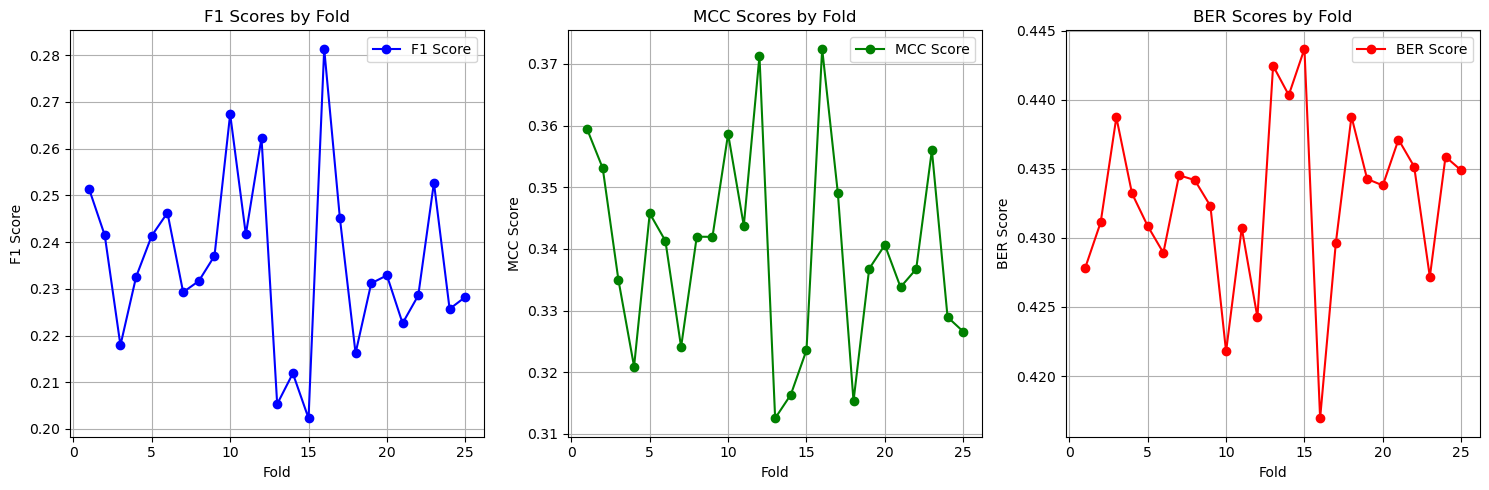

In [58]:
import matplotlib.pyplot as plt  # matplotlib.pyplot을 plt로 import

# 시각화
folds = range(1, len(f1_scores) + 1)

plt.figure(figsize=(15, 5))

# F1 score plot
plt.subplot(1, 3, 1)
plt.plot(folds, f1_scores, marker='o', linestyle='-', color='b', label='F1 Score')
plt.title('F1 Scores by Fold')
plt.xlabel('Fold')
plt.ylabel('F1 Score')
plt.grid(True)
plt.legend()

# MCC score plot
plt.subplot(1, 3, 2)
plt.plot(folds, mcc_scores, marker='o', linestyle='-', color='g', label='MCC Score')
plt.title('MCC Scores by Fold')
plt.xlabel('Fold')
plt.ylabel('MCC Score')
plt.grid(True)
plt.legend()

# BER score plot
plt.subplot(1, 3, 3)
plt.plot(folds, ber_scores, marker='o', linestyle='-', color='r', label='BER Score')
plt.title('BER Scores by Fold')
plt.xlabel('Fold')
plt.ylabel('BER Score')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

In [61]:
test_preds_1 = []
test_preds_lst = []
for i in range(len(models_1)):
    pred = models_1[i].predict(X_test)
    test_preds_1.append(pred)
    
test_preds_1 = np.mean(test_preds_1,axis=0)

# LGBM REGRESSOR

In [62]:
X = df_train.drop(columns = ['target'])
columns_to_keep = X.columns[X.columns != 'easy_hard']
X_test = df_test[columns_to_keep]
y = df_train['target'].values

In [63]:
import pandas as pd
import numpy as np
import lightgbm as lgbm
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, roc_auc_score
import matplotlib.pyplot as plt
# import seaborn as sns

def lgb_f1_score(y_hat, data):
    y_true = data.get_label()
    y_hat = np.where(y_hat < 0.5, 0, 1)  # scikit-learn's f1 doesn't like probabilities
    return 'f1', f1_score(y_true, y_hat), True

train = X
y = y
models_2 = []
evals_result = {}
test_preds = []

for state in [1, 5, 42, 77, 777]:
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=state)

    for train_index, test_index in skf.split(train,train['easy_hard']):
        X_train, X_val = train.drop(columns=['easy_hard']).iloc[train_index], train.drop(columns=['easy_hard']).iloc[test_index]
        y_train, y_val = y[train_index], y[test_index]

        print(X_train.shape, X_val.shape)

        y_pred_list = []
        
        dtrain = lgbm.Dataset(X_train, y_train)
        dvalid = lgbm.Dataset(X_val, y_val)
        print(state)
        params = {
            "objective": "regression",
            "metric": "rmse",
            "verbosity": -1,
            "boosting_type": "gbdt",
            'max_depth': 16, 
            'num_leaves': 333, 
            'learning_rate': 0.021471027173361846,
             'lambda_l1': 0.005384441312585211,
            'lambda_l2': 0.000648197586104832, 
             'bagging_fraction': 0.48644143461088324,
            'feature_fraction': 0.5120050389226708, 
            'max_bin': 66,
            "early_stopping_round": 100}
        params["seed"] = state
        
        model = lgbm.train(
            params,
            dtrain,
            valid_sets=[dvalid],
            feval=lgb_f1_score,
            num_boost_round=500
        )

        y_pred_list.append(model.predict(X_val))
        print(roc_auc_score(y_val, np.mean(y_pred_list, axis=0)))
        y_val_f1 = np.where(y_val >= 0.15, 1, 0)
        y_pred_f1 = np.where(np.mean(y_pred_list, axis=0) >= 0.15, 1, 0)
        print(f1_score(y_val_f1, y_pred_f1, average='binary'))

        models_2.append(model)

(36455, 306) (4051, 306)
1
0.739013706825636
0.27364185110663986
(36455, 306) (4051, 306)
1
0.7619851927822826
0.29535864978902954
(36455, 306) (4051, 306)
1
0.7412376488418329
0.2661737523105361
(36455, 306) (4051, 306)
1
0.716167488157507
0.24663677130044842
(36455, 306) (4051, 306)
1
0.7335136271505579
0.3012048192771084
(36455, 306) (4051, 306)
1
0.759800086918731
0.2691511387163561
(36456, 306) (4050, 306)
1
0.7270916567097303
0.28571428571428575
(36456, 306) (4050, 306)
1
0.7480205957633281
0.3080168776371308
(36456, 306) (4050, 306)
1
0.7415211856451649
0.2554112554112554
(36456, 306) (4050, 306)
1
0.7277612343293707
0.24675324675324678
(36455, 306) (4051, 306)
5
0.7319020150428386
0.24561403508771928
(36455, 306) (4051, 306)
5
0.7116737949131181
0.2683982683982684
(36455, 306) (4051, 306)
5
0.7292451585162858
0.28244274809160314
(36455, 306) (4051, 306)
5
0.7318680446952698
0.27350427350427353
(36455, 306) (4051, 306)
5
0.7169408897014016
0.23255813953488375
(36455, 306) (4051,

In [64]:
test_preds_2 = []

for i in range(len(models_2)):
    pred = models_2[i].predict(X_test)
    test_preds_2.append(pred)

sorted_probs = np.sort(test_preds_2, axis=0)
test_preds_2 = np.mean(sorted_probs[:],axis=0)

# CAT

In [65]:
X = df_train.drop(columns = ['target'])
columns_to_keep = X.columns[X.columns != 'easy_hard']
X_test = df_test[columns_to_keep]
y = df_train['target'].values

In [66]:
from sklearn.model_selection import StratifiedKFold
from catboost import CatBoostClassifier
from sklearn.metrics import f1_score, matthews_corrcoef
import numpy as np
import gc

model_cat_1 = []
is_holdout = False
f1_scores = []
mcc_scores = []  
n_split_list = [10]

for state in [1, 5, 42, 77, 777]:
    for split in n_split_list:
        fold_idx = 1
        cv = StratifiedKFold(n_splits=split, shuffle=True, random_state=state)
        for train_index, valid_index in cv.split(X, X['easy_hard']):
            X_train, X_valid = X.drop(columns=['easy_hard']).iloc[train_index], X.drop(columns=['easy_hard']).iloc[valid_index]
            Y_train, Y_valid = y[train_index], y[valid_index]
            print("="*50)
            
            model = CatBoostClassifier(
                iterations=3000,
                random_state=state,
                task_type="CPU",
                depth=3,
                eval_metric="F1",
                bootstrap_type='Bayesian', 
                random_strength=4,
                l2_leaf_reg=4,
                bagging_temperature=0.5,
                grow_policy='Depthwise',
                learning_rate=0.7,
            )
            
            model.fit(
                X_train, Y_train,
                eval_set=(X_valid, Y_valid),   
                early_stopping_rounds=300, 
                verbose=100
            )
            
            pred = model.predict_proba(X_valid)[:, 1]
            threshold = 0.5

            pred = np.where(pred >= threshold, True, False)
            
            # F1 score 계산
            f1 = f1_score(Y_valid, pred, labels=[True, False], average='binary')
            # MCC 계산
            mcc = matthews_corrcoef(Y_valid, pred)
            
            print(fold_idx, "Fold Validation F1 score:", f1)
            print(fold_idx, "Fold Validation MCC score:", mcc)
            
            f1_scores.append(f1)
            mcc_scores.append(mcc)
            model_cat_1.append(model)
            fold_idx += 1
            
            gc.collect()
            
            if is_holdout:
                break 
    print(state, '학습 완료')
    
print("Validation : F1:", np.mean(f1_scores))
print("Validation : MCC:", np.mean(mcc_scores))

0:	learn: 0.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 90.7ms	remaining: 4m 31s
100:	learn: 0.3623077	test: 0.2534247	best: 0.2576271 (64)	total: 3.27s	remaining: 1m 34s
200:	learn: 0.4668110	test: 0.2539683	best: 0.2640264 (153)	total: 6.49s	remaining: 1m 30s
300:	learn: 0.5458921	test: 0.2445141	best: 0.2649842 (208)	total: 9.72s	remaining: 1m 27s
400:	learn: 0.6118572	test: 0.2367601	best: 0.2649842 (208)	total: 13s	remaining: 1m 24s
500:	learn: 0.6743967	test: 0.2269939	best: 0.2649842 (208)	total: 16.3s	remaining: 1m 21s
Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.2649842271
bestIteration = 208

Shrink model to first 209 iterations.
1 Fold Validation F1 score: 0.26498422712933756
1 Fold Validation MCC score: 0.296862389418611
0:	learn: 0.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 43.5ms	remaining: 2m 10s
100:	learn: 0.3562597	test: 0.2657807	best: 0.2684564 (86)	total: 3.25s	remaining: 1m 33s
200:	learn: 0.4678236	test: 0.2451613	best: 0.27

100:	learn: 0.3589744	test: 0.2140221	best: 0.2156134 (92)	total: 3.26s	remaining: 1m 33s
200:	learn: 0.4679785	test: 0.2428571	best: 0.2491103 (152)	total: 6.46s	remaining: 1m 30s
300:	learn: 0.5542413	test: 0.2474227	best: 0.2542955 (285)	total: 9.67s	remaining: 1m 26s
400:	learn: 0.6143876	test: 0.2533333	best: 0.2600000 (394)	total: 12.9s	remaining: 1m 23s
500:	learn: 0.6873846	test: 0.2402597	best: 0.2640264 (422)	total: 16.2s	remaining: 1m 20s
600:	learn: 0.7454439	test: 0.2356688	best: 0.2640264 (422)	total: 19.4s	remaining: 1m 17s
700:	learn: 0.7929665	test: 0.2341772	best: 0.2640264 (422)	total: 22.7s	remaining: 1m 14s
Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.2640264026
bestIteration = 422

Shrink model to first 423 iterations.
1 Fold Validation F1 score: 0.264026402640264
1 Fold Validation MCC score: 0.2842921480286203
0:	learn: 0.0104463	test: 0.0155642	best: 0.0155642 (0)	total: 41.4ms	remaining: 2m 4s
100:	learn: 0.3574468	test: 0.2250804	best: 

0:	learn: 0.0103189	test: 0.0173160	best: 0.0173160 (0)	total: 41.4ms	remaining: 2m 4s
100:	learn: 0.3649524	test: 0.2746479	best: 0.2826855 (57)	total: 3.22s	remaining: 1m 32s
200:	learn: 0.4614286	test: 0.2808219	best: 0.2937063 (111)	total: 6.38s	remaining: 1m 28s
300:	learn: 0.5328767	test: 0.2960526	best: 0.2980132 (297)	total: 9.64s	remaining: 1m 26s
400:	learn: 0.5985593	test: 0.2866667	best: 0.3036304 (383)	total: 12.9s	remaining: 1m 23s
500:	learn: 0.6691659	test: 0.2967742	best: 0.3061889 (462)	total: 16.2s	remaining: 1m 20s
600:	learn: 0.7258065	test: 0.2965300	best: 0.3061889 (462)	total: 19.5s	remaining: 1m 17s
700:	learn: 0.7778096	test: 0.2866044	best: 0.3061889 (462)	total: 22.7s	remaining: 1m 14s
800:	learn: 0.8260270	test: 0.3076923	best: 0.3148148 (771)	total: 26s	remaining: 1m 11s
900:	learn: 0.8680149	test: 0.3048780	best: 0.3148148 (771)	total: 29.4s	remaining: 1m 8s
1000:	learn: 0.9010080	test: 0.2865672	best: 0.3148148 (771)	total: 32.7s	remaining: 1m 5s
Stopped

0:	learn: 0.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 37ms	remaining: 1m 51s
100:	learn: 0.3713305	test: 0.2596491	best: 0.2717770 (94)	total: 3.21s	remaining: 1m 32s
200:	learn: 0.4727403	test: 0.2679739	best: 0.2751678 (171)	total: 6.38s	remaining: 1m 28s
300:	learn: 0.5497275	test: 0.2459547	best: 0.2751678 (171)	total: 9.62s	remaining: 1m 26s
400:	learn: 0.6159844	test: 0.2555911	best: 0.2751678 (171)	total: 12.8s	remaining: 1m 23s
Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.2751677852
bestIteration = 171

Shrink model to first 172 iterations.
9 Fold Validation F1 score: 0.2751677852348993
9 Fold Validation MCC score: 0.32327687281714995
0:	learn: 0.0018832	test: 0.0000000	best: 0.0000000 (0)	total: 36.3ms	remaining: 1m 48s
100:	learn: 0.3682008	test: 0.2642857	best: 0.2700730 (82)	total: 3.23s	remaining: 1m 32s
200:	learn: 0.4601579	test: 0.2596491	best: 0.2700730 (82)	total: 6.4s	remaining: 1m 29s
300:	learn: 0.5382514	test: 0.2534247	best: 0.270

0:	learn: 0.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 40.6ms	remaining: 2m 1s
100:	learn: 0.3730099	test: 0.2000000	best: 0.2148148 (71)	total: 3.23s	remaining: 1m 32s
200:	learn: 0.4685265	test: 0.1928571	best: 0.2148148 (71)	total: 6.43s	remaining: 1m 29s
300:	learn: 0.5503219	test: 0.2013889	best: 0.2148148 (71)	total: 9.69s	remaining: 1m 26s
Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.2148148148
bestIteration = 71

Shrink model to first 72 iterations.
9 Fold Validation F1 score: 0.2148148148148148
9 Fold Validation MCC score: 0.27849177134544667
0:	learn: 0.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 40.2ms	remaining: 2m
100:	learn: 0.3660578	test: 0.2560554	best: 0.2666667 (77)	total: 3.24s	remaining: 1m 32s
200:	learn: 0.4521739	test: 0.2751678	best: 0.2913907 (163)	total: 6.42s	remaining: 1m 29s
300:	learn: 0.5373544	test: 0.2658228	best: 0.2913907 (163)	total: 9.65s	remaining: 1m 26s
400:	learn: 0.6181701	test: 0.2687500	best: 0.2913907 

0:	learn: 0.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 35.3ms	remaining: 1m 45s
100:	learn: 0.3601236	test: 0.2700965	best: 0.2810458 (64)	total: 3.23s	remaining: 1m 32s
200:	learn: 0.4545122	test: 0.2893082	best: 0.3009404 (189)	total: 6.39s	remaining: 1m 29s
300:	learn: 0.5326877	test: 0.2707692	best: 0.3009404 (189)	total: 9.6s	remaining: 1m 26s
400:	learn: 0.6055409	test: 0.2686567	best: 0.3009404 (189)	total: 12.9s	remaining: 1m 23s
Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.3009404389
bestIteration = 189

Shrink model to first 190 iterations.
9 Fold Validation F1 score: 0.30094043887147337
9 Fold Validation MCC score: 0.3512506997912548
0:	learn: 0.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 35ms	remaining: 1m 44s
100:	learn: 0.3752843	test: 0.2517986	best: 0.2661871 (80)	total: 3.21s	remaining: 1m 32s
200:	learn: 0.4621457	test: 0.2689655	best: 0.2727273 (172)	total: 6.43s	remaining: 1m 29s
300:	learn: 0.5503219	test: 0.2620690	best: 0.27

In [67]:
test_preds_3 = []

for i in range(len(model_cat_1)):
    pred = model_cat_1[i].predict(X_test)
    test_preds_3.append(pred)

sorted_probs = np.sort(test_preds_3, axis=0)
test_preds_3 = np.mean(sorted_probs[:],axis=0)

# XGB

In [68]:
X = df_train.drop(columns = ['target'])
columns_to_keep = X.columns[X.columns != 'easy_hard']
X_test = df_test[columns_to_keep]
y = df_train['target'].values

In [69]:
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, matthews_corrcoef
import numpy as np
import gc

model_xgb_1 = []
is_holdout = False
f1_scores = []
mcc_scores = []  
n_split_list = [10]

# For reproducibility
for state in [1, 5, 42, 77, 777]:
    for split in n_split_list:
        fold_idx = 1
        cv = StratifiedKFold(n_splits=split, shuffle=True, random_state=state)
        for train_index, valid_index in cv.split(X, X['easy_hard']):
            X_train, X_valid = X.drop(columns=['easy_hard']).iloc[train_index], X.drop(columns=['easy_hard']).iloc[valid_index]
            Y_train, Y_valid = y[train_index], y[valid_index]
            print("="*50)
            
            model = XGBClassifier(
                n_estimators=3000,
                random_state=state,
                max_depth=12,
                learning_rate=0.05,
                scale_pos_weight=1, 
                colsample_bytree=0.9, 
                subsample=1.0, 
                tree_method='gpu_hist', 
                gpu_id=0,
                grow_policy='depthwise',  
                use_label_encoder=False,
                early_stopping_rounds=20,
                verbosity=1
            )
            
            model.fit(
                X_train, Y_train,
                eval_set=[(X_valid, Y_valid)],
                verbose=True
            )
            
            pred = model.predict_proba(X_valid)[:, 1]
            threshold = 0.15

            pred = np.where(pred >= threshold, True, False)
            
            # F1 score 계산
            f1 = f1_score(Y_valid, pred, labels=[True, False], average='binary')
            # MCC 계산
            mcc = matthews_corrcoef(Y_valid, pred)
            
            print(fold_idx, "Fold Validation F1 score:", f1)
            print(fold_idx, "Fold Validation MCC score:", mcc)
            
            f1_scores.append(f1)
            mcc_scores.append(mcc)  # MCC 점수를 리스트에 추가
            model_xgb_1.append(model)
            fold_idx += 1
            
            gc.collect()
            
            if is_holdout:
                break 
    print(state, '학습 완료')
    
print("Validation : F1:", np.mean(f1_scores))
print("Validation : MCC:", np.mean(mcc_scores))

[0]	validation_0-logloss:0.25881
[1]	validation_0-logloss:0.25349
[2]	validation_0-logloss:0.24878
[3]	validation_0-logloss:0.24455
[4]	validation_0-logloss:0.24048
[5]	validation_0-logloss:0.23663
[6]	validation_0-logloss:0.23316
[7]	validation_0-logloss:0.22990
[8]	validation_0-logloss:0.22710
[9]	validation_0-logloss:0.22461
[10]	validation_0-logloss:0.22194
[11]	validation_0-logloss:0.21962
[12]	validation_0-logloss:0.21719
[13]	validation_0-logloss:0.21520
[14]	validation_0-logloss:0.21335
[15]	validation_0-logloss:0.21158
[16]	validation_0-logloss:0.20998
[17]	validation_0-logloss:0.20856
[18]	validation_0-logloss:0.20717
[19]	validation_0-logloss:0.20585
[20]	validation_0-logloss:0.20468
[21]	validation_0-logloss:0.20360
[22]	validation_0-logloss:0.20268
[23]	validation_0-logloss:0.20167
[24]	validation_0-logloss:0.20074
[25]	validation_0-logloss:0.19984
[26]	validation_0-logloss:0.19919
[27]	validation_0-logloss:0.19849
[28]	validation_0-logloss:0.19789
[29]	validation_0-loglos

[53]	validation_0-logloss:0.18829
[54]	validation_0-logloss:0.18830
[55]	validation_0-logloss:0.18822
[56]	validation_0-logloss:0.18815
[57]	validation_0-logloss:0.18818
[58]	validation_0-logloss:0.18809
[59]	validation_0-logloss:0.18816
[60]	validation_0-logloss:0.18810
[61]	validation_0-logloss:0.18824
[62]	validation_0-logloss:0.18819
[63]	validation_0-logloss:0.18833
[64]	validation_0-logloss:0.18837
[65]	validation_0-logloss:0.18840
[66]	validation_0-logloss:0.18846
[67]	validation_0-logloss:0.18844
[68]	validation_0-logloss:0.18850
[69]	validation_0-logloss:0.18848
[70]	validation_0-logloss:0.18853
[71]	validation_0-logloss:0.18855
[72]	validation_0-logloss:0.18859
[73]	validation_0-logloss:0.18862
[74]	validation_0-logloss:0.18851
[75]	validation_0-logloss:0.18857
[76]	validation_0-logloss:0.18863
[77]	validation_0-logloss:0.18852
3 Fold Validation F1 score: 0.2894168466522678
3 Fold Validation MCC score: 0.2471767828243375
[0]	validation_0-logloss:0.25187
[1]	validation_0-loglo

[55]	validation_0-logloss:0.17294
[56]	validation_0-logloss:0.17278
[57]	validation_0-logloss:0.17269
[58]	validation_0-logloss:0.17270
[59]	validation_0-logloss:0.17273
[60]	validation_0-logloss:0.17275
[61]	validation_0-logloss:0.17271
[62]	validation_0-logloss:0.17277
[63]	validation_0-logloss:0.17258
[64]	validation_0-logloss:0.17257
[65]	validation_0-logloss:0.17249
[66]	validation_0-logloss:0.17250
[67]	validation_0-logloss:0.17257
[68]	validation_0-logloss:0.17250
[69]	validation_0-logloss:0.17262
[70]	validation_0-logloss:0.17266
[71]	validation_0-logloss:0.17256
[72]	validation_0-logloss:0.17260
[73]	validation_0-logloss:0.17260
[74]	validation_0-logloss:0.17264
[75]	validation_0-logloss:0.17268
[76]	validation_0-logloss:0.17268
[77]	validation_0-logloss:0.17278
[78]	validation_0-logloss:0.17282
[79]	validation_0-logloss:0.17281
[80]	validation_0-logloss:0.17285
[81]	validation_0-logloss:0.17289
[82]	validation_0-logloss:0.17280
[83]	validation_0-logloss:0.17284
[84]	validatio

[36]	validation_0-logloss:0.19465
[37]	validation_0-logloss:0.19428
[38]	validation_0-logloss:0.19389
[39]	validation_0-logloss:0.19366
[40]	validation_0-logloss:0.19338
[41]	validation_0-logloss:0.19329
[42]	validation_0-logloss:0.19312
[43]	validation_0-logloss:0.19288
[44]	validation_0-logloss:0.19281
[45]	validation_0-logloss:0.19280
[46]	validation_0-logloss:0.19267
[47]	validation_0-logloss:0.19269
[48]	validation_0-logloss:0.19268
[49]	validation_0-logloss:0.19262
[50]	validation_0-logloss:0.19263
[51]	validation_0-logloss:0.19250
[52]	validation_0-logloss:0.19251
[53]	validation_0-logloss:0.19239
[54]	validation_0-logloss:0.19233
[55]	validation_0-logloss:0.19232
[56]	validation_0-logloss:0.19234
[57]	validation_0-logloss:0.19230
[58]	validation_0-logloss:0.19227
[59]	validation_0-logloss:0.19227
[60]	validation_0-logloss:0.19227
[61]	validation_0-logloss:0.19230
[62]	validation_0-logloss:0.19234
[63]	validation_0-logloss:0.19242
[64]	validation_0-logloss:0.19238
[65]	validatio

[35]	validation_0-logloss:0.20449
[36]	validation_0-logloss:0.20422
[37]	validation_0-logloss:0.20393
[38]	validation_0-logloss:0.20382
[39]	validation_0-logloss:0.20360
[40]	validation_0-logloss:0.20347
[41]	validation_0-logloss:0.20331
[42]	validation_0-logloss:0.20332
[43]	validation_0-logloss:0.20330
[44]	validation_0-logloss:0.20320
[45]	validation_0-logloss:0.20309
[46]	validation_0-logloss:0.20307
[47]	validation_0-logloss:0.20298
[48]	validation_0-logloss:0.20302
[49]	validation_0-logloss:0.20301
[50]	validation_0-logloss:0.20281
[51]	validation_0-logloss:0.20298
[52]	validation_0-logloss:0.20318
[53]	validation_0-logloss:0.20327
[54]	validation_0-logloss:0.20322
[55]	validation_0-logloss:0.20349
[56]	validation_0-logloss:0.20354
[57]	validation_0-logloss:0.20358
[58]	validation_0-logloss:0.20380
[59]	validation_0-logloss:0.20392
[60]	validation_0-logloss:0.20396
[61]	validation_0-logloss:0.20405
[62]	validation_0-logloss:0.20425
[63]	validation_0-logloss:0.20436
[64]	validatio

[40]	validation_0-logloss:0.18828
[41]	validation_0-logloss:0.18803
[42]	validation_0-logloss:0.18769
[43]	validation_0-logloss:0.18744
[44]	validation_0-logloss:0.18725
[45]	validation_0-logloss:0.18720
[46]	validation_0-logloss:0.18707
[47]	validation_0-logloss:0.18698
[48]	validation_0-logloss:0.18696
[49]	validation_0-logloss:0.18689
[50]	validation_0-logloss:0.18690
[51]	validation_0-logloss:0.18691
[52]	validation_0-logloss:0.18689
[53]	validation_0-logloss:0.18698
[54]	validation_0-logloss:0.18698
[55]	validation_0-logloss:0.18686
[56]	validation_0-logloss:0.18689
[57]	validation_0-logloss:0.18680
[58]	validation_0-logloss:0.18678
[59]	validation_0-logloss:0.18672
[60]	validation_0-logloss:0.18682
[61]	validation_0-logloss:0.18690
[62]	validation_0-logloss:0.18688
[63]	validation_0-logloss:0.18679
[64]	validation_0-logloss:0.18682
[65]	validation_0-logloss:0.18679
[66]	validation_0-logloss:0.18686
[67]	validation_0-logloss:0.18692
[68]	validation_0-logloss:0.18699
[69]	validatio

[0]	validation_0-logloss:0.24981
[1]	validation_0-logloss:0.24440
[2]	validation_0-logloss:0.23962
[3]	validation_0-logloss:0.23512
[4]	validation_0-logloss:0.23096
[5]	validation_0-logloss:0.22727
[6]	validation_0-logloss:0.22369
[7]	validation_0-logloss:0.22042
[8]	validation_0-logloss:0.21748
[9]	validation_0-logloss:0.21461
[10]	validation_0-logloss:0.21198
[11]	validation_0-logloss:0.20968
[12]	validation_0-logloss:0.20742
[13]	validation_0-logloss:0.20545
[14]	validation_0-logloss:0.20359
[15]	validation_0-logloss:0.20173
[16]	validation_0-logloss:0.20006
[17]	validation_0-logloss:0.19856
[18]	validation_0-logloss:0.19717
[19]	validation_0-logloss:0.19582
[20]	validation_0-logloss:0.19457
[21]	validation_0-logloss:0.19343
[22]	validation_0-logloss:0.19238
[23]	validation_0-logloss:0.19149
[24]	validation_0-logloss:0.19038
[25]	validation_0-logloss:0.18937
[26]	validation_0-logloss:0.18846
[27]	validation_0-logloss:0.18749
[28]	validation_0-logloss:0.18679
[29]	validation_0-loglos

[78]	validation_0-logloss:0.17538
[79]	validation_0-logloss:0.17532
[80]	validation_0-logloss:0.17530
[81]	validation_0-logloss:0.17521
[82]	validation_0-logloss:0.17518
[83]	validation_0-logloss:0.17523
[84]	validation_0-logloss:0.17526
[85]	validation_0-logloss:0.17532
[86]	validation_0-logloss:0.17521
[87]	validation_0-logloss:0.17519
[88]	validation_0-logloss:0.17523
[89]	validation_0-logloss:0.17519
[90]	validation_0-logloss:0.17522
[91]	validation_0-logloss:0.17514
[92]	validation_0-logloss:0.17512
[93]	validation_0-logloss:0.17508
[94]	validation_0-logloss:0.17507
[95]	validation_0-logloss:0.17504
[96]	validation_0-logloss:0.17501
[97]	validation_0-logloss:0.17504
[98]	validation_0-logloss:0.17505
[99]	validation_0-logloss:0.17513
[100]	validation_0-logloss:0.17518
[101]	validation_0-logloss:0.17523
[102]	validation_0-logloss:0.17529
[103]	validation_0-logloss:0.17530
[104]	validation_0-logloss:0.17524
[105]	validation_0-logloss:0.17525
[106]	validation_0-logloss:0.17534
[107]	v

[28]	validation_0-logloss:0.18566
[29]	validation_0-logloss:0.18490
[30]	validation_0-logloss:0.18426
[31]	validation_0-logloss:0.18364
[32]	validation_0-logloss:0.18306
[33]	validation_0-logloss:0.18260
[34]	validation_0-logloss:0.18211
[35]	validation_0-logloss:0.18156
[36]	validation_0-logloss:0.18118
[37]	validation_0-logloss:0.18072
[38]	validation_0-logloss:0.18051
[39]	validation_0-logloss:0.18016
[40]	validation_0-logloss:0.17974
[41]	validation_0-logloss:0.17943
[42]	validation_0-logloss:0.17908
[43]	validation_0-logloss:0.17883
[44]	validation_0-logloss:0.17858
[45]	validation_0-logloss:0.17839
[46]	validation_0-logloss:0.17816
[47]	validation_0-logloss:0.17791
[48]	validation_0-logloss:0.17762
[49]	validation_0-logloss:0.17750
[50]	validation_0-logloss:0.17745
[51]	validation_0-logloss:0.17752
[52]	validation_0-logloss:0.17748
[53]	validation_0-logloss:0.17735
[54]	validation_0-logloss:0.17726
[55]	validation_0-logloss:0.17714
[56]	validation_0-logloss:0.17717
[57]	validatio

[26]	validation_0-logloss:0.19692
[27]	validation_0-logloss:0.19615
[28]	validation_0-logloss:0.19558
[29]	validation_0-logloss:0.19499
[30]	validation_0-logloss:0.19441
[31]	validation_0-logloss:0.19395
[32]	validation_0-logloss:0.19339
[33]	validation_0-logloss:0.19287
[34]	validation_0-logloss:0.19241
[35]	validation_0-logloss:0.19213
[36]	validation_0-logloss:0.19188
[37]	validation_0-logloss:0.19164
[38]	validation_0-logloss:0.19154
[39]	validation_0-logloss:0.19123
[40]	validation_0-logloss:0.19097
[41]	validation_0-logloss:0.19075
[42]	validation_0-logloss:0.19070
[43]	validation_0-logloss:0.19059
[44]	validation_0-logloss:0.19047
[45]	validation_0-logloss:0.19042
[46]	validation_0-logloss:0.19035
[47]	validation_0-logloss:0.19020
[48]	validation_0-logloss:0.19010
[49]	validation_0-logloss:0.19005
[50]	validation_0-logloss:0.19001
[51]	validation_0-logloss:0.18990
[52]	validation_0-logloss:0.18977
[53]	validation_0-logloss:0.18967
[54]	validation_0-logloss:0.18955
[55]	validatio

[5]	validation_0-logloss:0.23421
[6]	validation_0-logloss:0.23085
[7]	validation_0-logloss:0.22762
[8]	validation_0-logloss:0.22467
[9]	validation_0-logloss:0.22204
[10]	validation_0-logloss:0.21953
[11]	validation_0-logloss:0.21733
[12]	validation_0-logloss:0.21530
[13]	validation_0-logloss:0.21352
[14]	validation_0-logloss:0.21159
[15]	validation_0-logloss:0.20981
[16]	validation_0-logloss:0.20813
[17]	validation_0-logloss:0.20662
[18]	validation_0-logloss:0.20531
[19]	validation_0-logloss:0.20411
[20]	validation_0-logloss:0.20285
[21]	validation_0-logloss:0.20167
[22]	validation_0-logloss:0.20071
[23]	validation_0-logloss:0.19977
[24]	validation_0-logloss:0.19905
[25]	validation_0-logloss:0.19825
[26]	validation_0-logloss:0.19766
[27]	validation_0-logloss:0.19692
[28]	validation_0-logloss:0.19630
[29]	validation_0-logloss:0.19553
[30]	validation_0-logloss:0.19508
[31]	validation_0-logloss:0.19458
[32]	validation_0-logloss:0.19404
[33]	validation_0-logloss:0.19352
[34]	validation_0-l

[68]	validation_0-logloss:0.19126
[69]	validation_0-logloss:0.19122
1 Fold Validation F1 score: 0.23201856148491878
1 Fold Validation MCC score: 0.18955433286699414
[0]	validation_0-logloss:0.26343
[1]	validation_0-logloss:0.25781
[2]	validation_0-logloss:0.25241
[3]	validation_0-logloss:0.24759
[4]	validation_0-logloss:0.24322
[5]	validation_0-logloss:0.23937
[6]	validation_0-logloss:0.23569
[7]	validation_0-logloss:0.23230
[8]	validation_0-logloss:0.22910
[9]	validation_0-logloss:0.22649
[10]	validation_0-logloss:0.22376
[11]	validation_0-logloss:0.22112
[12]	validation_0-logloss:0.21892
[13]	validation_0-logloss:0.21691
[14]	validation_0-logloss:0.21469
[15]	validation_0-logloss:0.21278
[16]	validation_0-logloss:0.21126
[17]	validation_0-logloss:0.20956
[18]	validation_0-logloss:0.20839
[19]	validation_0-logloss:0.20717
[20]	validation_0-logloss:0.20606
[21]	validation_0-logloss:0.20480
[22]	validation_0-logloss:0.20376
[23]	validation_0-logloss:0.20273
[24]	validation_0-logloss:0.2

[2]	validation_0-logloss:0.24838
[3]	validation_0-logloss:0.24432
[4]	validation_0-logloss:0.24002
[5]	validation_0-logloss:0.23649
[6]	validation_0-logloss:0.23297
[7]	validation_0-logloss:0.22984
[8]	validation_0-logloss:0.22676
[9]	validation_0-logloss:0.22414
[10]	validation_0-logloss:0.22170
[11]	validation_0-logloss:0.21937
[12]	validation_0-logloss:0.21728
[13]	validation_0-logloss:0.21542
[14]	validation_0-logloss:0.21345
[15]	validation_0-logloss:0.21177
[16]	validation_0-logloss:0.21016
[17]	validation_0-logloss:0.20870
[18]	validation_0-logloss:0.20724
[19]	validation_0-logloss:0.20590
[20]	validation_0-logloss:0.20450
[21]	validation_0-logloss:0.20347
[22]	validation_0-logloss:0.20254
[23]	validation_0-logloss:0.20149
[24]	validation_0-logloss:0.20079
[25]	validation_0-logloss:0.20002
[26]	validation_0-logloss:0.19925
[27]	validation_0-logloss:0.19859
[28]	validation_0-logloss:0.19803
[29]	validation_0-logloss:0.19759
[30]	validation_0-logloss:0.19707
[31]	validation_0-logl

[68]	validation_0-logloss:0.16853
[69]	validation_0-logloss:0.16853
[70]	validation_0-logloss:0.16854
[71]	validation_0-logloss:0.16852
[72]	validation_0-logloss:0.16848
[73]	validation_0-logloss:0.16853
[74]	validation_0-logloss:0.16856
[75]	validation_0-logloss:0.16854
[76]	validation_0-logloss:0.16853
[77]	validation_0-logloss:0.16855
[78]	validation_0-logloss:0.16839
[79]	validation_0-logloss:0.16840
[80]	validation_0-logloss:0.16842
[81]	validation_0-logloss:0.16838
[82]	validation_0-logloss:0.16842
[83]	validation_0-logloss:0.16842
[84]	validation_0-logloss:0.16847
[85]	validation_0-logloss:0.16847
[86]	validation_0-logloss:0.16843
[87]	validation_0-logloss:0.16846
[88]	validation_0-logloss:0.16845
[89]	validation_0-logloss:0.16843
[90]	validation_0-logloss:0.16846
[91]	validation_0-logloss:0.16845
[92]	validation_0-logloss:0.16840
[93]	validation_0-logloss:0.16845
[94]	validation_0-logloss:0.16850
[95]	validation_0-logloss:0.16851
[96]	validation_0-logloss:0.16849
[97]	validatio

[19]	validation_0-logloss:0.20150
[20]	validation_0-logloss:0.20036
[21]	validation_0-logloss:0.19934
[22]	validation_0-logloss:0.19833
[23]	validation_0-logloss:0.19743
[24]	validation_0-logloss:0.19652
[25]	validation_0-logloss:0.19583
[26]	validation_0-logloss:0.19513
[27]	validation_0-logloss:0.19439
[28]	validation_0-logloss:0.19366
[29]	validation_0-logloss:0.19297
[30]	validation_0-logloss:0.19245
[31]	validation_0-logloss:0.19190
[32]	validation_0-logloss:0.19137
[33]	validation_0-logloss:0.19081
[34]	validation_0-logloss:0.19028
[35]	validation_0-logloss:0.18993
[36]	validation_0-logloss:0.18978
[37]	validation_0-logloss:0.18942
[38]	validation_0-logloss:0.18915
[39]	validation_0-logloss:0.18895
[40]	validation_0-logloss:0.18863
[41]	validation_0-logloss:0.18834
[42]	validation_0-logloss:0.18825
[43]	validation_0-logloss:0.18817
[44]	validation_0-logloss:0.18805
[45]	validation_0-logloss:0.18798
[46]	validation_0-logloss:0.18798
[47]	validation_0-logloss:0.18800
[48]	validatio

[0]	validation_0-logloss:0.24604
[1]	validation_0-logloss:0.24019
[2]	validation_0-logloss:0.23503
[3]	validation_0-logloss:0.23038
[4]	validation_0-logloss:0.22633
[5]	validation_0-logloss:0.22211
[6]	validation_0-logloss:0.21838
[7]	validation_0-logloss:0.21486
[8]	validation_0-logloss:0.21180
[9]	validation_0-logloss:0.20883
[10]	validation_0-logloss:0.20599
[11]	validation_0-logloss:0.20348
[12]	validation_0-logloss:0.20116
[13]	validation_0-logloss:0.19896
[14]	validation_0-logloss:0.19688
[15]	validation_0-logloss:0.19488
[16]	validation_0-logloss:0.19319
[17]	validation_0-logloss:0.19152
[18]	validation_0-logloss:0.18987
[19]	validation_0-logloss:0.18845
[20]	validation_0-logloss:0.18727
[21]	validation_0-logloss:0.18601
[22]	validation_0-logloss:0.18486
[23]	validation_0-logloss:0.18369
[24]	validation_0-logloss:0.18262
[25]	validation_0-logloss:0.18185
[26]	validation_0-logloss:0.18094
[27]	validation_0-logloss:0.18015
[28]	validation_0-logloss:0.17934
[29]	validation_0-loglos

[68]	validation_0-logloss:0.18397
[69]	validation_0-logloss:0.18393
[70]	validation_0-logloss:0.18388
[71]	validation_0-logloss:0.18386
[72]	validation_0-logloss:0.18389
[73]	validation_0-logloss:0.18388
[74]	validation_0-logloss:0.18403
[75]	validation_0-logloss:0.18428
[76]	validation_0-logloss:0.18432
[77]	validation_0-logloss:0.18434
[78]	validation_0-logloss:0.18439
[79]	validation_0-logloss:0.18442
5 Fold Validation F1 score: 0.25837320574162675
5 Fold Validation MCC score: 0.2212232073249164
[0]	validation_0-logloss:0.25209
[1]	validation_0-logloss:0.24686
[2]	validation_0-logloss:0.24229
[3]	validation_0-logloss:0.23814
[4]	validation_0-logloss:0.23408
[5]	validation_0-logloss:0.23048
[6]	validation_0-logloss:0.22708
[7]	validation_0-logloss:0.22402
[8]	validation_0-logloss:0.22114
[9]	validation_0-logloss:0.21853
[10]	validation_0-logloss:0.21599
[11]	validation_0-logloss:0.21374
[12]	validation_0-logloss:0.21167
[13]	validation_0-logloss:0.20967
[14]	validation_0-logloss:0.20

[75]	validation_0-logloss:0.19020
[76]	validation_0-logloss:0.19027
[77]	validation_0-logloss:0.19025
[78]	validation_0-logloss:0.19036
[79]	validation_0-logloss:0.19043
[80]	validation_0-logloss:0.19054
[81]	validation_0-logloss:0.19052
[82]	validation_0-logloss:0.19059
[83]	validation_0-logloss:0.19065
[84]	validation_0-logloss:0.19063
[85]	validation_0-logloss:0.19070
[86]	validation_0-logloss:0.19075
8 Fold Validation F1 score: 0.24830699774266368
8 Fold Validation MCC score: 0.2059429357477981
[0]	validation_0-logloss:0.26110
[1]	validation_0-logloss:0.25559
[2]	validation_0-logloss:0.25088
[3]	validation_0-logloss:0.24643
[4]	validation_0-logloss:0.24259
[5]	validation_0-logloss:0.23868
[6]	validation_0-logloss:0.23520
[7]	validation_0-logloss:0.23199
[8]	validation_0-logloss:0.22912
[9]	validation_0-logloss:0.22620
[10]	validation_0-logloss:0.22365
[11]	validation_0-logloss:0.22135
[12]	validation_0-logloss:0.21910
[13]	validation_0-logloss:0.21720
[14]	validation_0-logloss:0.21

In [70]:
test_preds_4 = []

for i in range(len(model_xgb_1)):
    pred = model_xgb_1[i].predict(X_test)
    test_preds_4.append(pred)

sorted_probs = np.sort(test_preds_4, axis=0)
test_preds_4 = np.mean(sorted_probs[:],axis=0)

# ENSEMBLE WITH LGBM, XGB

In [75]:
test_preds_final = (test_preds_1*0.2 + test_preds_2*0.2 + test_preds_3*0.4 + test_preds_4*0.2)

In [76]:
test_preds_final = np.where(test_preds_final >= 0.202, "AbNormal","Normal")

In [77]:
pd.Series(test_preds_final).value_counts()

Normal      17093
AbNormal      268
Name: count, dtype: int64

# ENSEMBLE WITH DEEP & 후처리

In [78]:
submission_clof = pd.read_csv("submission_clof.csv")
submission_dbn = pd.read_csv('submission_dbn_원본.csv')
submission_transformer = pd.read_csv('submission_tf_원본.csv')

In [79]:
submission_clof_index = set(submission_clof[submission_clof['target']>np.percentile(submission_clof['target'], 98)].index)
submission_dbn_index = set(submission_dbn[submission_dbn['target']>np.percentile(submission_dbn['target'], 91.3)].index)
submission_transformer_index = set(submission_transformer[submission_transformer['target']>np.percentile(submission_transformer['target'], 91.3)].index)
intersection =  submission_clof_index & submission_transformer_index & submission_dbn_index

intersection_list_1 = list(intersection)

In [80]:
len(intersection_list_1)

122

In [81]:
submission_clof_index = set(submission_clof[submission_clof['target']<np.percentile(submission_clof['target'], 81.9)].index)
submission_dbn_index = set(submission_dbn[submission_dbn['target']<np.percentile(submission_dbn['target'], 81.9)].index)
submission_transformer_index = set(submission_transformer[submission_transformer['target']<np.percentile(submission_transformer['target'], 81.9)].index)

intersection = submission_clof_index  & submission_transformer_index & submission_dbn_index

intersection_list_2 = list(intersection)

In [82]:
k1 = df_test_후처리용[df_test_후처리용['Receip No Collect Result_Dam']!=df_test_후처리용['Receip No Collect Result_Fill1']].index
k2 = df_test_후처리용[df_test_후처리용['Receip No Collect Result_Fill2']!=df_test_후처리용['Receip No Collect Result_Fill1']].index
k3 = df_test_후처리용[df_test_후처리용['Receip No Collect Result_Dam']!=df_test_후처리용['Receip No Collect Result_Fill2']].index

union_1 = list(set(k1) | set(k2) | set(k3))

k1 = df_test_후처리용[df_test_후처리용['Production Qty Collect Result_Dam']!=df_test_후처리용['Production Qty Collect Result_Fill2']].index
k2 = df_test_후처리용[df_test_후처리용['Production Qty Collect Result_Fill2']!=df_test_후처리용['Production Qty Collect Result_Fill1']].index
k3 = df_test_후처리용[df_test_후처리용['Production Qty Collect Result_Dam']!=df_test_후처리용['Production Qty Collect Result_Fill1']].index
union_2 = list(set(k1) | set(k2) | set(k3))
union_3 = list(set(union_1) | set(union_2))

df_sub = pd.read_csv("submission.csv")
df_sub.loc[X_test.index,"target"] = test_preds_final

df_sub.loc[intersection_list_1,"target"] ='AbNormal'  # 딥 후처리 여기서
df_sub.loc[intersection_list_2,"target"] ='Normal'

df_sub['target'].value_counts()

target
Normal      17085
AbNormal      276
Name: count, dtype: int64

In [83]:
df_train_tt['target'] = np.where(df_train_tt['target'] == 'Normal', 0, 1)

# 그룹화하고 mean 값 계산
grouped_df = df_train_tt.groupby(['Workorder', 'Collect Date_AutoClave'])['target'].mean()

# mean 값이 1인 행만 필터링
filtered_df = grouped_df[grouped_df >= 0.6]

# index로 'Workorder'와 'Collect Date_AutoClave'를 리스트화
filtered_list = list(filtered_df.index)

In [84]:
submission = df_sub

df_test_tt['target'] = submission['target']

df_test_tt.loc[df_test_tt.set_index(['Workorder', 'Collect Date_AutoClave']).index.isin(filtered_list), 'target'] = 'AbNormal'

submission['target'] = df_test_tt['target']

In [85]:
submission.loc[union_3,"target"] = 'AbNormal'

In [86]:
submission['target'].value_counts()

target
Normal      17006
AbNormal      355
Name: count, dtype: int64

In [87]:
submission

,Set ID,target
0,0001be084fbc4aaa9d921f39e595961b,Normal
1,0005bbd180064abd99e63f9ed3e1ac80,Normal
2,000948934c4140d883d670adcb609584,Normal
3,000a6bfd02874c6296dc7b2e9c5678a7,Normal
4,0018e78ce91343678716e2ea27a51c95,Normal
...,...,...
17356,ffea508b59934d689b540f95eb3fa730,Normal
17357,ffed8923c8a448a98afc641b770be153,Normal
17358,fff1e73734da40adbe805359b3efb462,Normal
17359,fff8e38bdd09470baf95f71e92075dec,Normal


In [89]:
submission.to_csv("submission.csv", index=False)